<a href="https://colab.research.google.com/github/nikhilanand91/Forget/blob/main/ForgettingExperimentsPrototyping02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reproducing some results from [Toneva et al.](https://openreview.net/pdf?id=BJlxm30cKm)



We'd like to set up some code to do the following:
1.   Automatically generate models using OpenLTH.
2.   Reproduce some of the forgetting experiments on CIFAR10/100 from Toneva et al.
3.   Automate some of the scripting and experiment management, instead of having to write new SLURM scripts for each experiment.



## Load OpenLTH

Get OpenLTH (only need to do once)

In [ ]:
!git clone https://github.com/facebookresearch/open_lth.git

Cloning into 'open_lth'...
remote: Enumerating objects: 112, done.
remote: Total 112 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (112/112), 88.23 KiB | 5.51 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
!python open_lth/open_lth.py

usage: open_lth.py subcommand
open_lth.py: error: the following arguments are required: subcommand
OpenLTH: A Framework for Research on Lottery Tickets and Beyond
----------------------------------------------------------------------------------
Choose a command to run:
    * open_lth/open_lth.py train [...] => Train a model.
    * open_lth/open_lth.py lottery [...] => Run a lottery ticket hypothesis experiment.
    * open_lth/open_lth.py lottery_branch [...] => Run a lottery branch.


In [ ]:
import sys
sys.path.append('/content/open_lth/')

## Set model+data hyperparameters

We need to first define model hyperparameters, which can be done by using the `hparams` object

In [ ]:
from foundations import hparams
from models import registry

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

In [ ]:
model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

In [ ]:
model_1 = registry.get(model_hparams)

In [ ]:
from datasets import registry

In [ ]:
dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

In [ ]:
train_set = registry.get(
    dataset_hparams,
    train = True
)

Files already downloaded and verified


## Load data and plot some images to check normalization

In [ ]:
#don't need this - OpenLTH automatically gives the DataLoader
# train, val = random_split(train_set, [55000,5000])
# train_loader = DataLoader(train, batch_size=32)
# val_loader = DataLoader(val, batch_size=32)

In [ ]:
images, labels = next(iter(train_set))
images[3].size() #images are 3 x 32 x 32, but to plot, it seems like we need 32 x 32 x 3

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


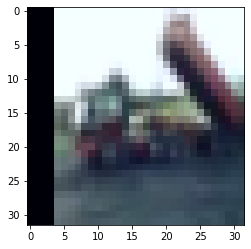

Grid format

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


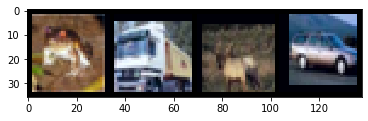

In [ ]:
import numpy as np

gridlist = [images[0]*.23 + 0.45,images[1]*0.23 + 0.45,(images[3]*.23)+0.45,(images[4]*.23)+0.45]
gridimgs = utils.make_grid(gridlist)
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(gridimgs)

## Train and save base model at 60 ep, with no modifications

put the model on GPU

In [ ]:
model_1_cuda = model_1.cuda() #remember to change runtime type

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1_cuda.parameters(), lr=1e-2)

In [ ]:
#ONLY RUN THIS CELL ONCE
from pathlib import Path
Path("/content/models/base/").mkdir(parents=True, exist_ok=True)

In [ ]:
#log output
train_output = open("/content/models/base/train_output.txt", "x")

#training and validation loop
nb_epochs = 60
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()
    model_1_cuda.train()
    for batch in train_set:
        x, y = batch
        x = x.cuda()

        #1. forward pass
            #with torch.no_grad():
        l = model_1_cuda(x)

        #2. compute objective function
        J = loss(l, y.cuda())

        #3. cleaning the gradients
        model_1_cuda.zero_grad()

        #4. accumulate partial derivatives
        J.backward()

        #5. step in opposite direction
        optimizer.step()

        #6. monitor loss
        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

    print(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
    print(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

    train_output.write(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
    train_output.write(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

train_output.close()

Epoch 1, train loss: 2.09 

Training accuracy: 0.22 

Epoch 2, train loss: 1.83 

Training accuracy: 0.31 

Epoch 3, train loss: 1.72 

Training accuracy: 0.35 

Epoch 4, train loss: 1.63 

Training accuracy: 0.39 

Epoch 5, train loss: 1.57 

Training accuracy: 0.41 

Epoch 6, train loss: 1.52 

Training accuracy: 0.43 

Epoch 7, train loss: 1.48 

Training accuracy: 0.45 

Epoch 8, train loss: 1.43 

Training accuracy: 0.47 

Epoch 9, train loss: 1.39 

Training accuracy: 0.49 

Epoch 10, train loss: 1.35 

Training accuracy: 0.51 

Epoch 11, train loss: 1.32 

Training accuracy: 0.52 

Epoch 12, train loss: 1.28 

Training accuracy: 0.53 

Epoch 13, train loss: 1.25 

Training accuracy: 0.55 

Epoch 14, train loss: 1.22 

Training accuracy: 0.56 

Epoch 15, train loss: 1.20 

Training accuracy: 0.57 

Epoch 16, train loss: 1.17 

Training accuracy: 0.58 

Epoch 17, train loss: 1.14 

Training accuracy: 0.59 

Epoch 18, train loss: 1.12 

Training accuracy: 0.60 

Epoch 19, train los

In [ ]:
model_1_cuda.eval()

Model(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
torch.tensor(accuracies)

tensor([0.7734, 0.8203, 0.7812, 0.7891, 0.7500, 0.6797, 0.6953, 0.7422, 0.7734,
        0.8203, 0.7422, 0.7656, 0.7891, 0.7734, 0.7734, 0.7344, 0.7734, 0.7812,
        0.7734, 0.8125, 0.8359, 0.7734, 0.8359, 0.7109, 0.7656, 0.7344, 0.6484,
        0.7891, 0.7812, 0.7812, 0.7578, 0.7969, 0.7188, 0.8047, 0.8125, 0.7422,
        0.8203, 0.7578, 0.7422, 0.7031, 0.7188, 0.7656, 0.7344, 0.6875, 0.7188,
        0.7266, 0.7891, 0.7734, 0.7344, 0.8047, 0.7734, 0.7734, 0.7188, 0.7812,
        0.7812, 0.7578, 0.7500, 0.7422, 0.7891, 0.6875, 0.8828, 0.7188, 0.7578,
        0.7656, 0.7578, 0.8359, 0.7031, 0.7656, 0.7422, 0.7266, 0.7188, 0.7969,
        0.8047, 0.7578, 0.8047, 0.7578, 0.7734, 0.7734, 0.7969, 0.7422, 0.7891,
        0.7109, 0.7969, 0.8125, 0.8125, 0.7031, 0.6953, 0.7109, 0.7500, 0.8203,
        0.8203, 0.7500, 0.7656, 0.8203, 0.7266, 0.8125, 0.7188, 0.7344, 0.7500,
        0.7422, 0.8125, 0.7266, 0.7656, 0.7734, 0.8125, 0.8438, 0.7969, 0.6641,
        0.7422, 0.7422, 0.7578, 0.7734, 

Save the model

In [ ]:
torch.save(model_1_cuda, "/content/models/base/model_1_cuda_base.pt")

In [ ]:
#Create a txt file with model information
model_info_file = open("/content/models/base/base_model_info.txt", "x")
model_info_file.write(f"Model hyperparameters: {model_hparams} \n")
model_info_file.write(f"Dataset parameters: {dataset_hparams} \n")
model_info_file.write(f"Epochs trained: {nb_epochs} \n")
model_info_file.close()

FileExistsError: ignored

## Now keep track of forgetting events

## Total number of forgetting events

In [ ]:
from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_1_forget = registry.get(model_hparams)
model_1_forget_cuda = model_1_forget.cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

Files already downloaded and verified


In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1_forget_cuda.parameters(), lr=1e-3, momentum=0.9) #note changes here to match Toneva et al

In [ ]:
#ONLY RUN THIS CELL ONCE
from pathlib import Path
Path("/content/models/forget1/").mkdir(parents=True, exist_ok=True)

In [ ]:
#log output
#train_output = open("/content/models/forget1/train_output.txt", "x")
#forget_output = open("/content/models/forget1/forget_output.txt", "x")

#intialize forget list which tracks how much each example has been forgotten
#initialized to 0 because at first, nothing is forgotten
a_i = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i = torch.zeros(len(train_set),128)
forget_matrix = torch.zeros(len(train_set),128)
batch_tracker = 0 #track which batch we're in

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification

#training and validation loop
nb_epochs = 75
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()

    model_1_forget_cuda.train()
    for batch in train_set:
        x, y = batch
        x = x.cuda()

        #1. forward pass
            #with torch.no_grad():
        l = model_1_forget_cuda(x)

        #check if it's correctly classified
        l_softmax = softmaxfunc(l)
        for k in range(len(l_softmax)):
            if torch.argmax(l_softmax[k])==y[k]:
                a_i[batch_tracker, k] = 1
            else:
                a_i[batch_tracker, k] = 0

            if a_i[batch_tracker, k] < a_tilde_i[batch_tracker, k]:
                forget_matrix[batch_tracker, k] += 1
            
            a_tilde_i[batch_tracker, k] = a_i[batch_tracker, k]


        #2. compute objective function
        J = loss(l, y.cuda())

        #3. cleaning the gradients
        model_1_forget_cuda.zero_grad()

        #4. accumulate partial derivatives
        J.backward()

        #5. step in opposite direction
        optimizer.step()

        #6. monitor loss
        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1

    print(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
    print(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

    batch_tracker = 0

 #   train_output.write(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
 #   train_output.write(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

#forget_output.write(f"{forget_matrix}")

#forget_output.close()
#train_output.close()

Epoch 1, train loss: 2.14 

Training accuracy: 0.20 

Epoch 2, train loss: 1.82 

Training accuracy: 0.31 

Epoch 3, train loss: 1.70 

Training accuracy: 0.36 

Epoch 4, train loss: 1.63 

Training accuracy: 0.39 

Epoch 5, train loss: 1.56 

Training accuracy: 0.42 

Epoch 6, train loss: 1.51 

Training accuracy: 0.44 

Epoch 7, train loss: 1.45 

Training accuracy: 0.47 

Epoch 8, train loss: 1.39 

Training accuracy: 0.49 

Epoch 9, train loss: 1.34 

Training accuracy: 0.51 

Epoch 10, train loss: 1.30 

Training accuracy: 0.52 

Epoch 11, train loss: 1.26 

Training accuracy: 0.54 

Epoch 12, train loss: 1.23 

Training accuracy: 0.55 

Epoch 13, train loss: 1.20 

Training accuracy: 0.56 

Epoch 14, train loss: 1.17 

Training accuracy: 0.57 

Epoch 15, train loss: 1.15 

Training accuracy: 0.58 

Epoch 16, train loss: 1.12 

Training accuracy: 0.59 

Epoch 17, train loss: 1.10 

Training accuracy: 0.60 

Epoch 18, train loss: 1.08 

Training accuracy: 0.61 

Epoch 19, train los

In [ ]:
print(torch.flatten(forget_matrix.round()))
max_val = torch.max(torch.flatten(forget_matrix))
torch.histc(torch.flatten(forget_matrix.round()), bins = 12, min = 0, max = max_val)
#torch.max(torch.flatten(forget_matrix))

tensor([1., 3., 4.,  ..., 0., 0., 0.])


tensor([1.3456e+04, 9.4620e+03, 7.3750e+03, 6.1620e+03, 5.0850e+03, 3.8940e+03,
        2.5570e+03, 1.3400e+03, 5.3600e+02, 1.4900e+02, 2.8000e+01, 4.0000e+00])

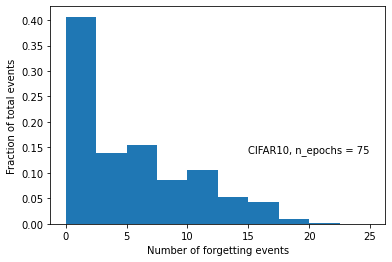

In [ ]:
import numpy as np
forgetlen = len(torch.flatten(forget_matrix))
hist = plt.hist(torch.flatten(forget_matrix), label = "Events", weights = np.ones(forgetlen)/forgetlen)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(15, .14, r'CIFAR10, n_epochs = 75')
plt.show()

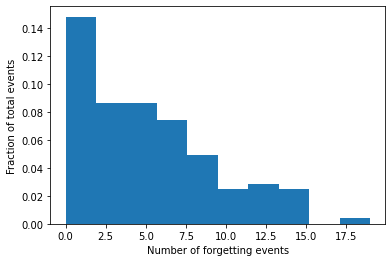

In [ ]:
hist = plt.hist(torch.flatten(forget_matrix[5]),density=True, label = "Events") #in a single batch
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.show()

In [ ]:
print(softmaxfunc(l)[1])
print(sum(softmaxfunc(l)[1]))
print(torch.argmax(softmaxfunc(l)[1]))
print(torch.argmax(softmaxfunc(l)[1])==5)
print(labels[1:40])

tensor([0.0428, 0.0738, 0.1496, 0.0976, 0.0977, 0.1973, 0.0257, 0.1183, 0.0573,
        0.1399], device='cuda:0', grad_fn=<SelectBackward>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(5, device='cuda:0')
tensor(True, device='cuda:0')
tensor([9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2,
        6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3])


## Add noise to CIFAR10 labels

In [ ]:
#ONLY RUN THIS CELL ONCE
from pathlib import Path
Path("/content/models/forgetnoise/").mkdir(parents=True, exist_ok=True)

In [ ]:
from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_1_forget_noise = registry.get(model_hparams)
model_1_forget_noise_cuda = model_1_forget_noise.cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1_forget_noise_cuda.parameters(), lr=1e-3, momentum=0.9) #note changes here to match Toneva et al

Files already downloaded and verified


KeyboardInterrupt: ignored

In [ ]:
import random

#log output
#train_output = open("/content/models/forget1/train_output.txt", "x")
#forget_output = open("/content/models/forget1/forget_output.txt", "x")

#intialize forget list which tracks how much each example has been forgotten
#initialized to 0 because at first, nothing is forgotten
a_i = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i = torch.zeros(len(train_set),128)
forget_matrix_noise = torch.zeros(len(train_set),128)
batch_tracker = 0 #track which batch we're in

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification

#training and validation loop
nb_epochs = 75
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()

    model_1_forget_noise_cuda.train()
    for batch in train_set:
        x, y = batch
        x = x.cuda()

        #1. forward pass
            #with torch.no_grad():
        l = model_1_forget_noise_cuda(x)

        #shuffle 20 percent of labels
        indices = torch.randint(0, len(y), (round(0.2*len(y))+1,))
        newlabels = torch.clone(y)

        for idx in indices:
            newlabels[idx] = random.randint(0,9)

        #check if it's correctly classified
        l_softmax = softmaxfunc(l)
        for k in range(len(l_softmax)):
            if torch.argmax(l_softmax[k])==newlabels[k]:
                a_i[batch_tracker, k] = 1
            else:
                a_i[batch_tracker, k] = 0

            if a_i[batch_tracker, k] < a_tilde_i[batch_tracker, k]:
                forget_matrix_noise[batch_tracker, k] += 1
            
            a_tilde_i[batch_tracker, k] = a_i[batch_tracker, k]


        #2. compute objective function
        J = loss(l, newlabels.cuda())

        #3. cleaning the gradients
        model_1_forget_noise_cuda.zero_grad()

        #4. accumulate partial derivatives
        J.backward()

        #5. step in opposite direction
        optimizer.step()

        #6. monitor loss
        losses.append(J.item())
        accuracies.append(newlabels.eq(l.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1

    print(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
    print(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

    batch_tracker = 0

    #train_output.write(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
    #train_output.write(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

#forget_output.write(f"{forget_matrix}")

#forget_output.close()
#train_output.close()

Epoch 1, train loss: 2.24 

Training accuracy: 0.16 

Epoch 2, train loss: 2.04 

Training accuracy: 0.25 

Epoch 3, train loss: 1.97 

Training accuracy: 0.29 

Epoch 4, train loss: 1.94 

Training accuracy: 0.31 

Epoch 5, train loss: 1.91 

Training accuracy: 0.33 

Epoch 6, train loss: 1.88 

Training accuracy: 0.34 

Epoch 7, train loss: 1.85 

Training accuracy: 0.36 

Epoch 8, train loss: 1.82 

Training accuracy: 0.37 

Epoch 9, train loss: 1.79 

Training accuracy: 0.39 

Epoch 10, train loss: 1.77 

Training accuracy: 0.40 

Epoch 11, train loss: 1.75 

Training accuracy: 0.41 

Epoch 12, train loss: 1.72 

Training accuracy: 0.42 

Epoch 13, train loss: 1.71 

Training accuracy: 0.44 

Epoch 14, train loss: 1.70 

Training accuracy: 0.44 

Epoch 15, train loss: 1.68 

Training accuracy: 0.45 

Epoch 16, train loss: 1.66 

Training accuracy: 0.46 

Epoch 17, train loss: 1.65 

Training accuracy: 0.47 

Epoch 18, train loss: 1.64 

Training accuracy: 0.47 

Epoch 19, train los

In [ ]:
from pathlib import Path
Path("/content/models/forgetnoise/").mkdir(parents=True, exist_ok=True)
forget_output = open("/content/models/forgetnoise/forget_output_noise.txt", "x")
forget_output.write(f"{forget_matrix_noise}")
forget_output.close()

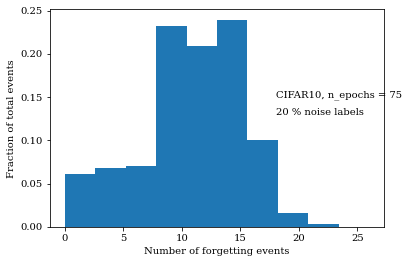

In [ ]:
import numpy as np
forgetlen_noise = len(torch.flatten(forget_matrix_noise))
plt.rcParams["font.family"] = "serif"
hist = plt.hist(torch.flatten(forget_matrix_noise), label = "Events", weights = np.ones(forgetlen_noise)/forgetlen_noise)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(18, .15, r'CIFAR10, n_epochs = 75')
plt.text(18, .13, r'20 % noise labels')
plt.show()

# What happens if most forgotten examples are dropped from dataset?

In [ ]:
from pathlib import Path
Path("/content/models/forget_mask/").mkdir(parents=True, exist_ok=True)

first we need create a mask so that we can remove most forgotten examples. We set the mask threshold to be = 4 here (so we remove it if it's forgotten 4 or more times).

In [ ]:
from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_1_forget_mask = registry.get(model_hparams)
model_1_forget_mask_cuda = model_1_forget_mask.cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1_forget_mask_cuda.parameters(), lr=1e-3, momentum=0.9) #note changes here to match Toneva et al

In [ ]:
#log output
#train_output = open("/content/models/forget1/train_output.txt", "x")
forget_output = open("/content/models/forget_mask/forget_output.py", "x")

#intialize forget list which tracks how much each example has been forgotten
#initialized to 0 because at first, nothing is forgotten
a_i = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i = torch.zeros(len(train_set),128)
forget_matrix = torch.zeros(len(train_set),128)
forget_mask = torch.ones(len(train_set),128, dtype=torch.bool)
mask_threshold = 4
batch_tracker = 0 #track which batch we're in

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification

#training and validation loop
nb_epochs = 40
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()

    model_1_forget_mask_cuda.train()
    for batch in train_set:
        x, y = batch
        x = x.cuda()

        #1. forward pass
            #with torch.no_grad():
        l = model_1_forget_mask_cuda(x)

        #check if it's correctly classified
        l_softmax = softmaxfunc(l)
        for k in range(len(l_softmax)):
            if torch.argmax(l_softmax[k])==y[k]:
                a_i[batch_tracker, k] = 1
            else:
                a_i[batch_tracker, k] = 0

            if a_i[batch_tracker, k] < a_tilde_i[batch_tracker, k]:
                forget_matrix[batch_tracker, k] += 1

                if forget_matrix[batch_tracker, k] >= mask_threshold:
                    forget_mask[batch_tracker, k] = False
            
            a_tilde_i[batch_tracker, k] = a_i[batch_tracker, k]


        #2. compute objective function
        J = loss(l, y.cuda())

        #3. cleaning the gradients
        model_1_forget_mask_cuda.zero_grad()

        #4. accumulate partial derivatives
        J.backward()

        #5. step in opposite direction
        optimizer.step()

        #6. monitor loss
        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1

    print(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
    print(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

    batch_tracker = 0

 #   train_output.write(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
 #   train_output.write(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

forget_output.write(f"forget_matrix = {forget_matrix}")

forget_output.close()
#train_output.close()

In [ ]:
forget_output = open("/content/models/forget_mask/forget_output.py", "x")

forget_output.write(f"forget_matrix = {forget_matrix}")

forget_output.close()

In [ ]:
from models.forget_mask import forget_output

NameError: ignored

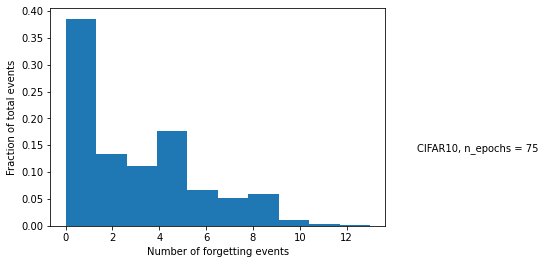

In [ ]:
import numpy as np
forgetlen = len(torch.flatten(forget_matrix))
hist = plt.hist(torch.flatten(forget_matrix), label = "Events", weights = np.ones(forgetlen)/forgetlen)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(15, .14, r'CIFAR10, n_epochs = 75')
plt.show()

Test accuracy

In [ ]:
test_set = registry.get(
    dataset_hparams,
    train = False
)

In [ ]:
model_1_forget_mask_cuda.eval()
test_accuracy = list()
for batch in test_set:
    x, y = batch
    x = x.cuda()

    with torch.no_grad():
        l = model_1_forget_mask_cuda(x)
        
    test_accuracy.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())
        
    print(f"Test accuracy: {torch.tensor(test_accuracy).mean():.2f} \n")

In [ ]:
test_accuracy

[tensor(0.7500),
 tensor(0.7266),
 tensor(0.7109),
 tensor(0.7344),
 tensor(0.8047),
 tensor(0.6875),
 tensor(0.6641),
 tensor(0.7500),
 tensor(0.6875),
 tensor(0.7344),
 tensor(0.6797),
 tensor(0.7031),
 tensor(0.7266),
 tensor(0.7344),
 tensor(0.8047),
 tensor(0.6875),
 tensor(0.6719),
 tensor(0.7188),
 tensor(0.6953),
 tensor(0.6797),
 tensor(0.7188),
 tensor(0.7109),
 tensor(0.7734),
 tensor(0.7500),
 tensor(0.7734),
 tensor(0.6406),
 tensor(0.6641),
 tensor(0.7031),
 tensor(0.6875),
 tensor(0.7266),
 tensor(0.7422),
 tensor(0.7344),
 tensor(0.7266),
 tensor(0.7266),
 tensor(0.7656),
 tensor(0.6797),
 tensor(0.7891),
 tensor(0.7656),
 tensor(0.7266),
 tensor(0.7578),
 tensor(0.6953),
 tensor(0.7109),
 tensor(0.7266),
 tensor(0.6953),
 tensor(0.7266),
 tensor(0.6875),
 tensor(0.6797),
 tensor(0.7031),
 tensor(0.6328),
 tensor(0.7656),
 tensor(0.6641),
 tensor(0.7344),
 tensor(0.6719),
 tensor(0.7188),
 tensor(0.6719),
 tensor(0.7422),
 tensor(0.7656),
 tensor(0.7578),
 tensor(0.7734

then retrain with mask

In [ ]:
from foundations import hparams
from models import registry

model_hparams_2 = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_1_forget_with_mask = registry.get(model_hparams_2)
model_1_forget_with_mask_cuda = model_1_forget_with_mask.cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1_forget_with_mask_cuda.parameters(), lr=1e-3, momentum=0.9) #note changes here to match Toneva et al

In [ ]:
model_1_forget_with_mask_cuda.eval()
test_accuracy_2 = list()
for batch in test_set:
    x, y = batch
    x = x.cuda()

    with torch.no_grad():
        l1 = model_1_forget_with_mask_cuda(x)
        l2 = model_1_forget_mask_cuda(x)
        #print(l1 - l2)

    test_accuracy_2.append(y.eq(l1.detach().argmax(dim=1).cpu()).float().mean())
        
    print(f"Test accuracy: {torch.tensor(test_accuracy_2).mean():.2f} \n")

Test accuracy: 0.12 

Test accuracy: 0.09 

Test accuracy: 0.09 

Test accuracy: 0.10 

Test accuracy: 0.09 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.11 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accuracy: 0.10 

Test accur

In [ ]:
#log output
#train_output = open("/content/models/forget1/train_output.txt", "x")
#forget_output = open("/content/models/forget1/forget_output.txt", "x")

#intialize forget list which tracks how much each example has been forgotten
#initialized to 0 because at first, nothing is forgotten
a_i_mask = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_mask = torch.zeros(len(train_set),128)
forget_matrix_mask = torch.zeros(len(train_set),128)
#forget_mask = torch.ones(len(train_set),128, dtype=torch.bool)
#mask_threshold = 4
batch_tracker = 0 #track which batch we're in

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification

#correct the last element of the forget mask so that it matches the last batch
forget_mask_last = forget_mask[len(train_set)-1,0:50000%128]

#training and validation loop
nb_epochs = 40
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()

    model_1_forget_with_mask_cuda.train()
    for batch in train_set:
        x, y = batch
        x = x.cuda()

        if(batch_tracker==len(train_set)-1):
            xp = x[forget_mask_last == True,:]
            yp = y[forget_mask_last == True]
        else:
            xp = x[forget_mask[batch_tracker] == True,:] 
            yp = y[forget_mask[batch_tracker] == True] 

        #1. forward pass
            #with torch.no_grad():
        l = model_1_forget_with_mask_cuda(xp)

        #check if it's correctly classified
        l_softmax = softmaxfunc(l)
        for k in range(len(l_softmax)):
            if torch.argmax(l_softmax[k])==y[k]:
                a_i_mask[batch_tracker, k] = 1
            else:
                a_i_mask[batch_tracker, k] = 0

            if a_i_mask[batch_tracker, k] < a_tilde_i_mask[batch_tracker, k]:
                forget_matrix_mask[batch_tracker, k] += 1
            
            a_tilde_i_mask[batch_tracker, k] = a_i_mask[batch_tracker, k]


        #2. compute objective function
        J = loss(l, yp.cuda())

        #3. cleaning the gradients
        model_1_forget_with_mask_cuda.zero_grad()

        #4. accumulate partial derivatives
        J.backward()

        #5. step in opposite direction
        optimizer.step()

        #6. monitor loss
        losses.append(J.item())
        accuracies.append(yp.eq(l.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1

    print(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
    print(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

    batch_tracker = 0

 #   train_output.write(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
 #   train_output.write(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

#forget_output.write(f"{forget_matrix}")

#forget_output.close()
#train_output.close()

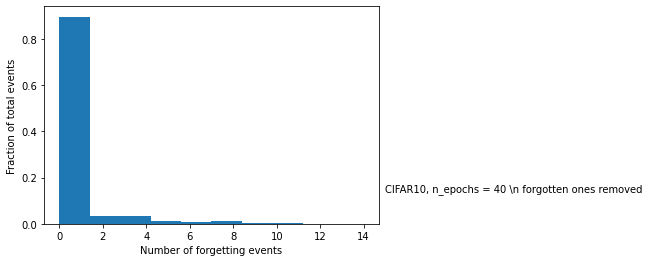

In [ ]:
import numpy as np
forgetlen = len(torch.flatten(forget_matrix_mask))
hist = plt.hist(torch.flatten(forget_matrix_mask), label = "Events", weights = np.ones(forgetlen)/forgetlen)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(15, .14, r'CIFAR10, n_epochs = 40 \n forgotten ones removed')
plt.show()

In [ ]:
torch.tensor(accuracies).mean()

tensor(0.7532)

In [ ]:
forget_mask_last = forget_mask[len(train_set)-1,0:(50000%128)]

In [ ]:
forget_mask[len(train_set)-1] = forget_mask_last[0:]

RuntimeError: ignored

In [ ]:
trker = 0
for batch in train_set:
    images, labels = batch
    model_1_forget_with_mask_cuda.eval()

    print(f"{trker}")

    if trker==len(train_set)
        imagesmasked

    imagesmasked = images[forget_mask[trker] == True,:] #torch.masked_select(images, forget_mask[0])
    print(imagesmasked.size())
    labelsmasked = labels[forget_mask[trker] == True] #torch.masked_select(images, forget_mask[0])
    trker+=1
#
#model_1_forget_with_mask_cuda(imagesmasked.cuda())

#forget_mask[0]

IndexError: ignored

In [ ]:
len(train_set)

391

In [ ]:
50000%128

80

In [ ]:
newmask = forget_mask[390,0:80] #forget_mask[390]
images.size()

torch.Size([80, 3, 32, 32])

In [ ]:
images.size()

torch.Size([80, 3, 32, 32])

In [ ]:
other, other2 = next(iter(train_set))

In [ ]:
other.size()

torch.Size([128, 3, 32, 32])

In [ ]:
len(images[forget_mask[0] == True,:])

79

In [ ]:
def select_mask(images, mask):
    images_masked = torch.empty() #(len(images),3,32,32)
    for i in range(len(mask)):
        if mask[i]==True:
            images_masked_2 = torch.cat(images_masked,images[i])
    return images_masked_2


In [ ]:
imagesmasked

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

In [ ]:
imagesmasked = select_mask(images, forget_mask[0])

In [ ]:
test_forget_mask = torch.zeros(5, dtype=torch.bool)
print(test_forget_mask)
test_forget_mask[2] = True
print(test_forget_mask)
test_select = torch.rand(5)
print(test_select)

tensor([False, False, False, False, False])
tensor([False, False,  True, False, False])
tensor([0.4376, 0.2636, 0.6580, 0.5527, 0.8292])


In [ ]:
torch.masked_select(test_select, torch.BoolTensor(test_forget_mask))

tensor([0.6580])

# Merging classes

## Merge neighboring classes (dogs and cats)

There are a bunch of options of how to merge. For example, we could take cats + dogs into a superclass 'pets' vs. two completely unrelated classes like airplanes and dogs into a superclass.

On general grounds, we hypothesize grouping similar classes to do better but let's try and check this.

First train a model as usual on all classes.

In [ ]:
from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_1_class = registry.get(model_hparams)
model_1_class_cuda = model_1_class.cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

Files already downloaded and verified


In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1_class.parameters(), lr=1e-3, momentum=0.9) #note changes here to match Toneva et al

In [ ]:
#log output
#train_output = open("/content/models/forget1/train_output.txt", "x")
#forget_output = open("/content/models/forget1/forget_output.txt", "x")

#intialize forget list which tracks how much each example has been forgotten
#initialized to 0 because at first, nothing is forgotten
a_i = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i = torch.zeros(len(train_set),128)
forget_matrix_class = torch.zeros(len(train_set),128)
batch_tracker = 0 #track which batch we're in

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification

#training and validation loop
nb_epochs = 40
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()

    model_1_class_cuda.train()
    for batch in train_set:
        x, y = batch
        x = x.cuda()

        #1. forward pass
            #with torch.no_grad():
        l = model_1_class_cuda(x)

        #check if it's correctly classified
        l_softmax = softmaxfunc(l)
        for k in range(len(l_softmax)):
            if torch.argmax(l_softmax[k])==y[k]:
                a_i[batch_tracker, k] = 1
            else:
                a_i[batch_tracker, k] = 0

            if a_i[batch_tracker, k] < a_tilde_i[batch_tracker, k]:
                forget_matrix_class[batch_tracker, k] += 1
            
            a_tilde_i[batch_tracker, k] = a_i[batch_tracker, k]


        #2. compute objective function
        J = loss(l, y.cuda())

        #3. cleaning the gradients
        model_1_class_cuda.zero_grad()

        #4. accumulate partial derivatives
        J.backward()

        #5. step in opposite direction
        optimizer.step()

        #6. monitor loss
        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1

    print(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
    print(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

    batch_tracker = 0

 #   train_output.write(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
 #   train_output.write(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

#forget_output.write(f"{forget_matrix}")

#forget_output.close()
#train_output.close()

Epoch 1, train loss: 2.13 

Training accuracy: 0.20 

Epoch 2, train loss: 1.83 

Training accuracy: 0.31 

Epoch 3, train loss: 1.72 

Training accuracy: 0.35 

Epoch 4, train loss: 1.64 

Training accuracy: 0.38 

Epoch 5, train loss: 1.58 

Training accuracy: 0.41 

Epoch 6, train loss: 1.52 

Training accuracy: 0.44 

Epoch 7, train loss: 1.46 

Training accuracy: 0.46 

Epoch 8, train loss: 1.41 

Training accuracy: 0.49 

Epoch 9, train loss: 1.36 

Training accuracy: 0.51 

Epoch 10, train loss: 1.31 

Training accuracy: 0.52 

Epoch 11, train loss: 1.27 

Training accuracy: 0.54 

Epoch 12, train loss: 1.24 

Training accuracy: 0.55 

Epoch 13, train loss: 1.21 

Training accuracy: 0.56 

Epoch 14, train loss: 1.18 

Training accuracy: 0.58 

Epoch 15, train loss: 1.15 

Training accuracy: 0.58 

Epoch 16, train loss: 1.13 

Training accuracy: 0.59 

Epoch 17, train loss: 1.10 

Training accuracy: 0.60 

Epoch 18, train loss: 1.08 

Training accuracy: 0.61 

Epoch 19, train los

Next train a model on merged classes. First try merging optically similar classes: cats + dogs = pets

In [ ]:
from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_1_class_merged = registry.get(model_hparams)
model_1_class_merged_cuda = model_1_class_merged.cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

Files already downloaded and verified


In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1_class_merged.parameters(), lr=1e-3, momentum=0.9) #note changes here to match Toneva et al

#log output
#train_output = open("/content/models/forget1/train_output.txt", "x")
#forget_output = open("/content/models/forget1/forget_output.txt", "x")

#intialize forget list which tracks how much each example has been forgotten
#initialized to 0 because at first, nothing is forgotten
a_i = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i = torch.zeros(len(train_set),128)
forget_matrix_class = torch.zeros(len(train_set),128)
batch_tracker = 0 #track which batch we're in

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification

#training and validation loop
nb_epochs = 40
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()

    model_1_class_merged_cuda.train()
    for batch in train_set:
        x, y = batch
        x = x.cuda()

        y[y==3] = y[y==5] = 5 #treat every cat and dog as dog

        #1. forward pass
            #with torch.no_grad():
        l = model_1_class_merged(x)

        #check if it's correctly classified
        l_softmax = softmaxfunc(l)
        for k in range(len(l_softmax)):
            if torch.argmax(l_softmax[k])==y[k]:
                a_i[batch_tracker, k] = 1
            else:
                a_i[batch_tracker, k] = 0

            if a_i[batch_tracker, k] < a_tilde_i[batch_tracker, k]:
                forget_matrix_class[batch_tracker, k] += 1
            
            a_tilde_i[batch_tracker, k] = a_i[batch_tracker, k]


        #2. compute objective function
        J = loss(l, y.cuda())

        #3. cleaning the gradients
        model_1_class_merged_cuda.zero_grad()

        #4. accumulate partial derivatives
        J.backward()

        #5. step in opposite direction
        optimizer.step()

        #6. monitor loss
        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1

    print(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
    print(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

    batch_tracker = 0

 #   train_output.write(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
 #   train_output.write(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

#forget_output.write(f"{forget_matrix}")

#forget_output.close()
#train_output.close()

Epoch 1, train loss: 1.98 

Training accuracy: 0.28 

Epoch 2, train loss: 1.66 

Training accuracy: 0.39 

Epoch 3, train loss: 1.55 

Training accuracy: 0.43 

Epoch 4, train loss: 1.47 

Training accuracy: 0.46 

Epoch 5, train loss: 1.40 

Training accuracy: 0.48 

Epoch 6, train loss: 1.34 

Training accuracy: 0.51 

Epoch 7, train loss: 1.29 

Training accuracy: 0.53 

Epoch 8, train loss: 1.24 

Training accuracy: 0.55 

Epoch 9, train loss: 1.20 

Training accuracy: 0.57 

Epoch 10, train loss: 1.16 

Training accuracy: 0.59 

Epoch 11, train loss: 1.12 

Training accuracy: 0.60 

Epoch 12, train loss: 1.09 

Training accuracy: 0.61 

Epoch 13, train loss: 1.06 

Training accuracy: 0.62 

Epoch 14, train loss: 1.03 

Training accuracy: 0.63 

Epoch 15, train loss: 1.00 

Training accuracy: 0.64 

Epoch 16, train loss: 0.98 

Training accuracy: 0.65 

Epoch 17, train loss: 0.96 

Training accuracy: 0.66 

Epoch 18, train loss: 0.93 

Training accuracy: 0.67 

Epoch 19, train los

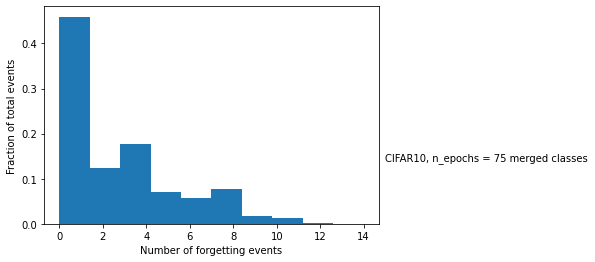

In [ ]:
import numpy as np
forgetlen = len(torch.flatten(forget_matrix_class))
hist = plt.hist(torch.flatten(forget_matrix_class), label = "Events", weights = np.ones(forgetlen)/forgetlen)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(15, .14, r'CIFAR10, n_epochs = 75 merged classes')
plt.show()

Now test both on merged classes criteria.

In [ ]:
model_1_class_merged_cuda.eval()
model_1_class_cuda.eval()

test_set = registry.get(
    dataset_hparams,
    train = True
)

accuracies_model_1 = list()
accuracies_model_2 = list()

for batch in test_set:
    x, y = batch
    l1 = model_1_class_cuda(x.cuda())
    l2 = model_1_class_merged_cuda(x.cuda())

    y[y==3] = y[y==5] = 5

    for k in range(len(l1)):
        l1_max = torch.max(l1[k,3], l1[k,5])
        l1_min = torch.min(l1[k,3], l1[k,5])
        l1_remain1 = l1[k,0:3]
        l1_remain2 = l1[k,6:]

        l1[k] = torch.tensor((l1_remain1[0], l1_remain1[1], l1_remain1[2], l1_min, l1[k,4], l1_max, l1_remain2[0], l1_remain2[1], l1_remain2[2], l1_remain2[3])).cuda()

    accuracies_model_1.append(y.eq(l1.detach().argmax(dim=1).cpu()).float().mean())
    accuracies_model_2.append(y.eq(l2.detach().argmax(dim=1).cpu()).float().mean())
    
    print(f'Test accuracy for model 1: {torch.tensor(accuracies_model_1).mean():.2f}')
    print(f'Test accuracy for model 2: {torch.tensor(accuracies_model_2).mean():.2f}')

Files already downloaded and verified
Test accuracy for model 1: 0.81
Test accuracy for model 2: 0.78
Test accuracy for model 1: 0.80
Test accuracy for model 2: 0.80
Test accuracy for model 1: 0.80
Test accuracy for model 2: 0.77
Test accuracy for model 1: 0.78
Test accuracy for model 2: 0.76
Test accuracy for model 1: 0.77
Test accuracy for model 2: 0.77
Test accuracy for model 1: 0.76
Test accuracy for model 2: 0.75
Test accuracy for model 1: 0.76
Test accuracy for model 2: 0.75
Test accuracy for model 1: 0.77
Test accuracy for model 2: 0.75
Test accuracy for model 1: 0.77
Test accuracy for model 2: 0.75
Test accuracy for model 1: 0.78
Test accuracy for model 2: 0.76
Test accuracy for model 1: 0.77
Test accuracy for model 2: 0.76
Test accuracy for model 1: 0.77
Test accuracy for model 2: 0.76
Test accuracy for model 1: 0.77
Test accuracy for model 2: 0.76
Test accuracy for model 1: 0.77
Test accuracy for model 2: 0.76
Test accuracy for model 1: 0.77
Test accuracy for model 2: 0.76
Te

In [ ]:
model_1_class_merged_cuda.eval()
model_1_class_cuda.eval()

test_set = registry.get(
    dataset_hparams,
    train = True
)

x, y = next(iter(test_set))
l1 = model_1_class_cuda(x.cuda())
l2 = model_1_class_merged_cuda(x.cuda())

for k in range(len(l1)):
        l1_max = torch.max(l1[k,3], l1[k,5])
        l1_remain1 = l1[k,0:3]
        l1_remain2 = l1[k,6:]

        l1[k] = torch.tensor((l1_remain1[0], l1_remain1[1], l1_remain1[2], 0., l1[k,4], l1_max, l1_remain2[0], l1_remain2[1], l1_remain2[2], l1_remain2[3])).cuda()

softmaxfunc=nn.Softmax(dim=1)
tempnum = 9
print(softmaxfunc(l1)[tempnum].round())
print(softmaxfunc(l2)[tempnum].round())
print(y[tempnum])

Files already downloaded and verified
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<RoundBackward>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<RoundBackward>)
tensor(3)


In [ ]:
softmaxfunc(l1)[tempnum]

tensor([0.0073, 0.0201, 0.0262, 0.0321, 0.0225, 0.7338, 0.1283, 0.0181, 0.0021,
        0.0095], device='cuda:0', grad_fn=<SelectBackward>)

they are roughly comparable in this case:

In [ ]:
print(torch.tensor(accuracies_model_1).mean())
print(torch.tensor(accuracies_model_2).mean())

tensor(0.7629)
tensor(0.7640)


## Merge random classes

Now try merging optically unrelated classes e.g. horse + automobile = means of transport

In [ ]:
from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_1_class = registry.get(model_hparams)
model_1_class_cuda = model_1_class.cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

Files already downloaded and verified


In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1_class.parameters(), lr=1e-3, momentum=0.9) #note changes here to match Toneva et al

a_i = torch.zeros(len(train_set),128)
a_tilde_i = torch.zeros(len(train_set),128)
forget_matrix_class = torch.zeros(len(train_set),128)
batch_tracker = 0 #track which batch we're in

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification

#training and validation loop
nb_epochs = 40
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()

    model_1_class_cuda.train()
    for batch in train_set:
        x, y = batch
        x = x.cuda()

        #1. forward pass
            #with torch.no_grad():
        l = model_1_class_cuda(x)

        #check if it's correctly classified
        l_softmax = softmaxfunc(l)
        for k in range(len(l_softmax)):
            if torch.argmax(l_softmax[k])==y[k]:
                a_i[batch_tracker, k] = 1
            else:
                a_i[batch_tracker, k] = 0

            if a_i[batch_tracker, k] < a_tilde_i[batch_tracker, k]:
                forget_matrix_class[batch_tracker, k] += 1
            
            a_tilde_i[batch_tracker, k] = a_i[batch_tracker, k]


        #2. compute objective function
        J = loss(l, y.cuda())

        #3. cleaning the gradients
        model_1_class_cuda.zero_grad()

        #4. accumulate partial derivatives
        J.backward()

        #5. step in opposite direction
        optimizer.step()

        #6. monitor loss
        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1

    print(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
    print(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

    batch_tracker = 0

 #   train_output.write(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
 #   train_output.write(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

#forget_output.write(f"{forget_matrix}")

#forget_output.close()
#train_output.close()

Epoch 1, train loss: 2.14 

Training accuracy: 0.20 

Epoch 2, train loss: 1.86 

Training accuracy: 0.30 

Epoch 3, train loss: 1.76 

Training accuracy: 0.34 

Epoch 4, train loss: 1.69 

Training accuracy: 0.37 

Epoch 5, train loss: 1.63 

Training accuracy: 0.39 

Epoch 6, train loss: 1.58 

Training accuracy: 0.41 

Epoch 7, train loss: 1.53 

Training accuracy: 0.43 

Epoch 8, train loss: 1.48 

Training accuracy: 0.46 

Epoch 9, train loss: 1.43 

Training accuracy: 0.48 

Epoch 10, train loss: 1.38 

Training accuracy: 0.50 

Epoch 11, train loss: 1.33 

Training accuracy: 0.51 

Epoch 12, train loss: 1.29 

Training accuracy: 0.53 

Epoch 13, train loss: 1.26 

Training accuracy: 0.54 

Epoch 14, train loss: 1.22 

Training accuracy: 0.56 

Epoch 15, train loss: 1.19 

Training accuracy: 0.57 

Epoch 16, train loss: 1.17 

Training accuracy: 0.58 

Epoch 17, train loss: 1.14 

Training accuracy: 0.59 

Epoch 18, train loss: 1.12 

Training accuracy: 0.60 

Epoch 19, train los

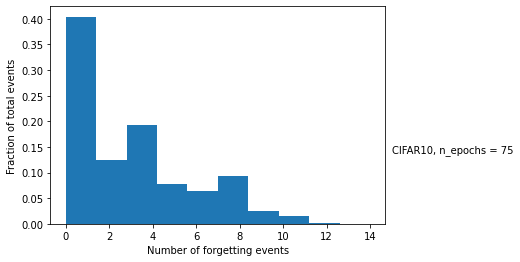

In [ ]:
import numpy as np
forgetlen = len(torch.flatten(forget_matrix_class))
hist = plt.hist(torch.flatten(forget_matrix_class), label = "Events", weights = np.ones(forgetlen)/forgetlen)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(15, .14, r'CIFAR10, n_epochs = 75')
plt.show()

In [ ]:
from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_1_class_merged = registry.get(model_hparams)
model_1_class_merged_cuda = model_1_class_merged.cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1_class_merged.parameters(), lr=1e-3, momentum=0.9) #note changes here to match Toneva et al

#log output
#train_output = open("/content/models/forget1/train_output.txt", "x")
#forget_output = open("/content/models/forget1/forget_output.txt", "x")

#intialize forget list which tracks how much each example has been forgotten
#initialized to 0 because at first, nothing is forgotten
a_i = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i = torch.zeros(len(train_set),128)
forget_matrix_class = torch.zeros(len(train_set),128)
batch_tracker = 0 #track which batch we're in

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification

#training and validation loop
nb_epochs = 40
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()

    model_1_class_merged_cuda.train()
    for batch in train_set:
        x, y = batch
        x = x.cuda()

        y[y==0] = y[y==7] = 7 #treat every horse and airplane as airplane

        #1. forward pass
            #with torch.no_grad():
        l = model_1_class_merged(x)

        #check if it's correctly classified
        l_softmax = softmaxfunc(l)
        for k in range(len(l_softmax)):
            if torch.argmax(l_softmax[k])==y[k]:
                a_i[batch_tracker, k] = 1
            else:
                a_i[batch_tracker, k] = 0

            if a_i[batch_tracker, k] < a_tilde_i[batch_tracker, k]:
                forget_matrix_class[batch_tracker, k] += 1
            
            a_tilde_i[batch_tracker, k] = a_i[batch_tracker, k]


        #2. compute objective function
        J = loss(l, y.cuda())

        #3. cleaning the gradients
        model_1_class_merged_cuda.zero_grad()

        #4. accumulate partial derivatives
        J.backward()

        #5. step in opposite direction
        optimizer.step()

        #6. monitor loss
        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1

    print(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
    print(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

    batch_tracker = 0

 #   train_output.write(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
 #   train_output.write(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

#forget_output.write(f"{forget_matrix}")

#forget_output.close()
#train_output.close()

Files already downloaded and verified
Epoch 1, train loss: 2.02 

Training accuracy: 0.24 

Epoch 2, train loss: 1.75 

Training accuracy: 0.32 

Epoch 3, train loss: 1.64 

Training accuracy: 0.37 

Epoch 4, train loss: 1.57 

Training accuracy: 0.40 

Epoch 5, train loss: 1.51 

Training accuracy: 0.43 

Epoch 6, train loss: 1.44 

Training accuracy: 0.46 

Epoch 7, train loss: 1.39 

Training accuracy: 0.48 

Epoch 8, train loss: 1.34 

Training accuracy: 0.50 

Epoch 9, train loss: 1.30 

Training accuracy: 0.51 

Epoch 10, train loss: 1.27 

Training accuracy: 0.53 

Epoch 11, train loss: 1.24 

Training accuracy: 0.54 

Epoch 12, train loss: 1.21 

Training accuracy: 0.55 

Epoch 13, train loss: 1.18 

Training accuracy: 0.57 

Epoch 14, train loss: 1.15 

Training accuracy: 0.58 

Epoch 15, train loss: 1.13 

Training accuracy: 0.58 

Epoch 16, train loss: 1.11 

Training accuracy: 0.59 

Epoch 17, train loss: 1.09 

Training accuracy: 0.60 

Epoch 18, train loss: 1.06 

Trainin

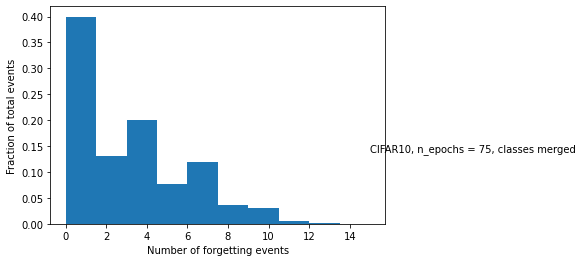

In [ ]:
import numpy as np
forgetlen = len(torch.flatten(forget_matrix_class))
hist = plt.hist(torch.flatten(forget_matrix_class), label = "Events", weights = np.ones(forgetlen)/forgetlen)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(15, .14, r'CIFAR10, n_epochs = 75, classes merged')
plt.show()

In [ ]:
model_1_class_merged_cuda.eval()
model_1_class_cuda.eval()

test_set = registry.get(
    dataset_hparams,
    train = True
)

accuracies_model_1 = list()
accuracies_model_2 = list()

for batch in test_set:
    x, y = batch
    l1 = model_1_class_cuda(x.cuda())
    l2 = model_1_class_merged_cuda(x.cuda())

    y[y==0] = y[y==7] = 7

    for k in range(len(l1)):
        l1_max = torch.max(l1[k,0], l1[k,7])
        l1_remain1 = l1[k,1:7]
        l1_remain2 = l1[k,8:]

        l1[k] = torch.tensor((0, l1_remain1[0], l1_remain1[1], l1_remain1[2], l1_remain1[3], l1_remain1[4], l1_remain1[5], l1_max, l1_remain2[0], l1_remain2[1])).cuda()

    accuracies_model_1.append(y.eq(l1.detach().argmax(dim=1).cpu()).float().mean())
    accuracies_model_2.append(y.eq(l2.detach().argmax(dim=1).cpu()).float().mean())
    
    print(f'Test accuracy for model 1: {torch.tensor(accuracies_model_1).mean():.2f}')
    print(f'Test accuracy for model 2: {torch.tensor(accuracies_model_2).mean():.2f}')

Files already downloaded and verified
Test accuracy for model 1: 0.72
Test accuracy for model 2: 0.73
Test accuracy for model 1: 0.76
Test accuracy for model 2: 0.76
Test accuracy for model 1: 0.74
Test accuracy for model 2: 0.76
Test accuracy for model 1: 0.74
Test accuracy for model 2: 0.75
Test accuracy for model 1: 0.74
Test accuracy for model 2: 0.74
Test accuracy for model 1: 0.71
Test accuracy for model 2: 0.73
Test accuracy for model 1: 0.71
Test accuracy for model 2: 0.73
Test accuracy for model 1: 0.71
Test accuracy for model 2: 0.72
Test accuracy for model 1: 0.70
Test accuracy for model 2: 0.72
Test accuracy for model 1: 0.71
Test accuracy for model 2: 0.73
Test accuracy for model 1: 0.72
Test accuracy for model 2: 0.73
Test accuracy for model 1: 0.72
Test accuracy for model 2: 0.73
Test accuracy for model 1: 0.72
Test accuracy for model 2: 0.73
Test accuracy for model 1: 0.72
Test accuracy for model 2: 0.72
Test accuracy for model 1: 0.72
Test accuracy for model 2: 0.73
Te

In [ ]:
print(torch.tensor(accuracies_model_1).mean())
print(torch.tensor(accuracies_model_2).mean())

tensor(0.7233)
tensor(0.7265)


## Merge a bunch of classes

In [ ]:
from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_1_class_merged = registry.get(model_hparams)
model_1_class_merged_cuda = model_1_class_merged.cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1_class_merged.parameters(), lr=1e-3, momentum=0.9) #note changes here to match Toneva et al

#log output
#train_output = open("/content/models/forget1/train_output.txt", "x")
#forget_output = open("/content/models/forget1/forget_output.txt", "x")

#intialize forget list which tracks how much each example has been forgotten
#initialized to 0 because at first, nothing is forgotten
a_i = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i = torch.zeros(len(train_set),128)
forget_matrix_class = torch.zeros(len(train_set),128)
batch_tracker = 0 #track which batch we're in

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification

#training and validation loop
nb_epochs = 40
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()

    model_1_class_merged_cuda.train()
    for batch in train_set:
        x, y = batch
        x = x.cuda()

        y[y==0] = y[y==1] = y[y==2] = y[y==3] = 3 

        #1. forward pass
            #with torch.no_grad():
        l = model_1_class_merged(x)

        #check if it's correctly classified
        l_softmax = softmaxfunc(l)
        for k in range(len(l_softmax)):
            if torch.argmax(l_softmax[k])==y[k]:
                a_i[batch_tracker, k] = 1
            else:
                a_i[batch_tracker, k] = 0

            if a_i[batch_tracker, k] < a_tilde_i[batch_tracker, k]:
                forget_matrix_class[batch_tracker, k] += 1
            
            a_tilde_i[batch_tracker, k] = a_i[batch_tracker, k]


        #2. compute objective function
        J = loss(l, y.cuda())

        #3. cleaning the gradients
        model_1_class_merged_cuda.zero_grad()

        #4. accumulate partial derivatives
        J.backward()

        #5. step in opposite direction
        optimizer.step()

        #6. monitor loss
        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1

    print(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
    print(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

    batch_tracker = 0

 #   train_output.write(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
 #   train_output.write(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

#forget_output.write(f"{forget_matrix}")

#forget_output.close()
#train_output.close()

Files already downloaded and verified
Epoch 1, train loss: 1.69 

Training accuracy: 0.39 

Epoch 2, train loss: 1.46 

Training accuracy: 0.42 

Epoch 3, train loss: 1.37 

Training accuracy: 0.46 

Epoch 4, train loss: 1.31 

Training accuracy: 0.48 

Epoch 5, train loss: 1.27 

Training accuracy: 0.50 

Epoch 6, train loss: 1.22 

Training accuracy: 0.52 

Epoch 7, train loss: 1.17 

Training accuracy: 0.55 

Epoch 8, train loss: 1.13 

Training accuracy: 0.56 

Epoch 9, train loss: 1.10 

Training accuracy: 0.58 

Epoch 10, train loss: 1.06 

Training accuracy: 0.59 

Epoch 11, train loss: 1.03 

Training accuracy: 0.61 

Epoch 12, train loss: 1.00 

Training accuracy: 0.62 

Epoch 13, train loss: 0.98 

Training accuracy: 0.63 

Epoch 14, train loss: 0.95 

Training accuracy: 0.64 

Epoch 15, train loss: 0.93 

Training accuracy: 0.65 

Epoch 16, train loss: 0.91 

Training accuracy: 0.65 

Epoch 17, train loss: 0.89 

Training accuracy: 0.66 

Epoch 18, train loss: 0.87 

Trainin

In [ ]:
model_1_class_merged_cuda.eval()
model_1_class_cuda.eval()

test_set = registry.get(
    dataset_hparams,
    train = True
)

accuracies_model_1 = list()
accuracies_model_2 = list()

for batch in test_set:
    x, y = batch
    l1 = model_1_class_cuda(x.cuda())
    l2 = model_1_class_merged_cuda(x.cuda())

    y[y==0] = y[y==1] = y[y==2] = y[y==3] = 3

    for k in range(len(l1)):
        l1_max = torch.max(l1[k,0:4])
        l1_remain1 = l1[k,4:10]

        l1[k] = torch.tensor((0, 0, l1_max, l1_max, l1_remain1[0], l1_remain1[1], l1_remain1[2], l1_remain1[3],l1_remain1[4], l1_remain1[5])).cuda()

    accuracies_model_1.append(y.eq(l1.detach().argmax(dim=1).cpu()).float().mean())
    accuracies_model_2.append(y.eq(l2.detach().argmax(dim=1).cpu()).float().mean())
    
    print(f'Test accuracy for model 1: {torch.tensor(accuracies_model_1).mean():.2f}')
    print(f'Test accuracy for model 2: {torch.tensor(accuracies_model_2).mean():.2f}')

Files already downloaded and verified
Test accuracy for model 1: 0.40
Test accuracy for model 2: 0.82
Test accuracy for model 1: 0.45
Test accuracy for model 2: 0.79
Test accuracy for model 1: 0.44
Test accuracy for model 2: 0.79
Test accuracy for model 1: 0.44
Test accuracy for model 2: 0.78
Test accuracy for model 1: 0.45
Test accuracy for model 2: 0.77
Test accuracy for model 1: 0.44
Test accuracy for model 2: 0.76
Test accuracy for model 1: 0.43
Test accuracy for model 2: 0.77
Test accuracy for model 1: 0.44
Test accuracy for model 2: 0.77
Test accuracy for model 1: 0.44
Test accuracy for model 2: 0.76
Test accuracy for model 1: 0.45
Test accuracy for model 2: 0.77
Test accuracy for model 1: 0.46
Test accuracy for model 2: 0.76
Test accuracy for model 1: 0.45
Test accuracy for model 2: 0.77
Test accuracy for model 1: 0.45
Test accuracy for model 2: 0.77
Test accuracy for model 1: 0.45
Test accuracy for model 2: 0.76
Test accuracy for model 1: 0.46
Test accuracy for model 2: 0.76
Te

In [ ]:
print(torch.tensor(accuracies_model_1).mean())
print(torch.tensor(accuracies_model_2).mean())

tensor(0.7507)
tensor(0.7626)


## Merge all but 1 class

In [ ]:
from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_1_class_merged = registry.get(model_hparams)
model_1_class_merged_cuda = model_1_class_merged.cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1_class_merged.parameters(), lr=1e-3, momentum=0.9) #note changes here to match Toneva et al

#log output
#train_output = open("/content/models/forget1/train_output.txt", "x")
#forget_output = open("/content/models/forget1/forget_output.txt", "x")

#intialize forget list which tracks how much each example has been forgotten
#initialized to 0 because at first, nothing is forgotten
a_i = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i = torch.zeros(len(train_set),128)
forget_matrix_class = torch.zeros(len(train_set),128)
batch_tracker = 0 #track which batch we're in

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification

#training and validation loop
nb_epochs = 40
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()

    model_1_class_merged_cuda.train()
    for batch in train_set:
        x, y = batch
        x = x.cuda()

        y[y==0] = y[y==1] = y[y==2] = y[y==3] = y[y==4] = y[y==5] = y[y==6] = y[y==7] = y[y==8] = 8 

        #1. forward pass
            #with torch.no_grad():
        l = model_1_class_merged(x)

        #check if it's correctly classified
        l_softmax = softmaxfunc(l)
        for k in range(len(l_softmax)):
            if torch.argmax(l_softmax[k])==y[k]:
                a_i[batch_tracker, k] = 1
            else:
                a_i[batch_tracker, k] = 0

            if a_i[batch_tracker, k] < a_tilde_i[batch_tracker, k]:
                forget_matrix_class[batch_tracker, k] += 1
            
            a_tilde_i[batch_tracker, k] = a_i[batch_tracker, k]


        #2. compute objective function
        J = loss(l, y.cuda())

        #3. cleaning the gradients
        model_1_class_merged_cuda.zero_grad()

        #4. accumulate partial derivatives
        J.backward()

        #5. step in opposite direction
        optimizer.step()

        #6. monitor loss
        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1

    print(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
    print(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

    batch_tracker = 0

 #   train_output.write(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f} \n")
 #   train_output.write(f"Training accuracy: {torch.tensor(accuracies).mean():.2f} \n")

#forget_output.write(f"{forget_matrix}")

#forget_output.close()
#train_output.close()

Files already downloaded and verified
Epoch 1, train loss: 0.41 

Training accuracy: 0.87 

Epoch 2, train loss: 0.26 

Training accuracy: 0.90 

Epoch 3, train loss: 0.24 

Training accuracy: 0.90 

Epoch 4, train loss: 0.23 

Training accuracy: 0.91 

Epoch 5, train loss: 0.22 

Training accuracy: 0.91 

Epoch 6, train loss: 0.21 

Training accuracy: 0.92 

Epoch 7, train loss: 0.20 

Training accuracy: 0.92 

Epoch 8, train loss: 0.19 

Training accuracy: 0.92 

Epoch 9, train loss: 0.19 

Training accuracy: 0.92 

Epoch 10, train loss: 0.18 

Training accuracy: 0.93 

Epoch 11, train loss: 0.18 

Training accuracy: 0.93 

Epoch 12, train loss: 0.17 

Training accuracy: 0.93 

Epoch 13, train loss: 0.17 

Training accuracy: 0.93 

Epoch 14, train loss: 0.16 

Training accuracy: 0.94 

Epoch 15, train loss: 0.16 

Training accuracy: 0.94 

Epoch 16, train loss: 0.15 

Training accuracy: 0.94 

Epoch 17, train loss: 0.15 

Training accuracy: 0.94 

Epoch 18, train loss: 0.15 

Trainin

In [ ]:
model_1_class_merged_cuda.eval()
model_1_class_cuda.eval()

test_set = registry.get(
    dataset_hparams,
    train = True
)

accuracies_model_1 = list()
accuracies_model_2 = list()

for batch in test_set:
    x, y = batch
    l1 = model_1_class_cuda(x.cuda())
    l2 = model_1_class_merged_cuda(x.cuda())

    y[y==0] = y[y==1] = y[y==2] = y[y==3] = y[y==4] = y[y==5] = y[y==6] = y[y==7] = y[y==8] =  8

    for k in range(len(l1)):
        l1_max = torch.max(l1[k,0:9])
        l1_remain1 = l1[k,9]

        l1[k] = torch.tensor((0, 0, 0, 0, 0, 0, 0, 0, l1_max, l1_remain1)).cuda()

    accuracies_model_1.append(y.eq(l1.detach().argmax(dim=1).cpu()).float().mean())
    accuracies_model_2.append(y.eq(l2.detach().argmax(dim=1).cpu()).float().mean())
    
    print(f'Test accuracy for model 1: {torch.tensor(accuracies_model_1).mean():.2f}')
    print(f'Test accuracy for model 2: {torch.tensor(accuracies_model_2).mean():.2f}')

Files already downloaded and verified
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.93
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.95
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.94
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.95
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.95
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.95
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.95
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.96
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.96
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.96
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.95
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.96
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.96
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.96
Test accuracy for model 1: 0.97
Test accuracy for model 2: 0.96
Te

In [ ]:
torch.tensor(accuracies_model_1).mean()

tensor(0.9662)

In [ ]:
torch.tensor(accuracies_model_2).mean()

tensor(0.9626)

In [ ]:
testvec=[0,1,2,3,4,5,6,7,8,9]
print(testvec[0:9])
print(testvec[9])

[0, 1, 2, 3, 4, 5, 6, 7, 8]
9



# Distillation (with MSE loss)

(Note: restart runtime before running)

In this section we want to consider two models, A and B.

Model A trains as usual on CIFAR10. Model B attempts to copy model A. However, when model A forgets an example, model B aim to copy the logits (output vectors) of model A before A forgot. We could do this latter step in a number of ways, but one simple way is to just use the output vectors for the example at the epoch before it was forgottten. Another way is to look for the minimum loss.

To code this up we need the following:


1.   A way to keep track of logits between epochs. For now, we will just need the "most recent" set of logits.
2.   A method to compute the cross entropy between logits (note that torch's CrossEntropy() assumes you are giving it a list of classes, but we can easily come up with a slight modification to this)
3.   We will need to construct a temp set of logits, say l_A_prime, which are optimal and feed those into the loss function to get B's loss.



In [ ]:
#First load models, dataset

!git clone https://github.com/facebookresearch/open_lth.git
import sys
sys.path.append('/content/open_lth/')

from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_A = registry.get(model_hparams).cuda()
model_B = registry.get(model_hparams).cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss_A = nn.CrossEntropyLoss()
loss_B =  nn.MSELoss() #nn.KLDivLoss() #nn.CrossEntropyLoss()
optimizer_A = optim.SGD(model_A.parameters(), lr=1e-3, momentum=0.9)
optimizer_B = optim.SGD(model_B.parameters(), lr=1e-3, momentum=0.9)

fatal: destination path 'open_lth' already exists and is not an empty directory.
Files already downloaded and verified


In [ ]:
nb_epochs = 60
batch_size = 128
#output_vectors = torch.empty(nb_epochs, len(train_set), batch_size, 10)
a_i_A = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_A = torch.zeros(len(train_set),128)

model_B_on_A_acc = torch.zeros(len(train_set),128)
model_B_on_A_acc_tilde = torch.zeros(len(train_set),128)

a_i_B = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_B = torch.zeros(len(train_set),128)

forget_matrix_A = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of A
forget_matrix_B = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of B wrt image classification
forget_matrix_B_on_A = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of B wrt A logits

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification
batch_tracker = 0

#initialize previous logits
model_A.eval()
#first_x, first_y = next(iter(train_set))

l_A_previous = torch.zeros(nb_epochs, len(train_set), 128, 10)

model_A.eval()
model_B.eval()

acc_A_global = list()
acc_B_global = list()
acc_A_unmodified_global = list()

model_A.train()
model_B.train()
batch_tracker = 0

for epoch in range(nb_epochs):
    losses_A = list()
    accuracies_A = list()
    accuracies_A_unmodified = list()

    losses_B = list()
    accuracies_B = list()

    for batch in train_set:
        x, y = batch
        x = x.cuda()

        l_A = model_A(x)
        l_A_prime = l_A.detach().clone()
        l_B = model_B(x.detach().clone())
        
        with torch.no_grad():
            l_A_unmod = model_A(x)

        with torch.no_grad():
            l_A_previous[epoch, batch_tracker, 0:len(l_A)] = l_A.detach().clone() #set previous logits equal to current logits to start with
    
        #batch_size_current = len(batch[1])
        #output_vectors[epoch, batch_tracker, 0:batch_size_current] = l_A

        #check if model A's prediction is correctly classified
        l_A_softmax = softmaxfunc(l_A)
        if epoch >1:
            l_A_previous_softmax = softmaxfunc(l_A_previous[epoch-1, batch_tracker])

        for k in range(len(l_A_softmax)):
            if torch.argmax(l_A_softmax[k])==y[k]: #if it is, mark as '1'
                a_i_A[batch_tracker, k] = 1
            else:
                a_i_A[batch_tracker, k] = 0 #otherwise 0

            if a_i_A[batch_tracker, k] < a_tilde_i_A[batch_tracker, k]: #and if we find that the marker has decreased, we've forgotten the example
                forget_matrix_A[epoch, batch_tracker, k] += 1
                
                #if we forgot the example, build new logits which involve previous ones
                #we will use this to rewind the logits
                #try:
                if epoch > 1 and torch.argmax(l_A_previous_softmax[k])==y[k]:
                    #print(f"Forgot example! Replacing {l_A_prime[k]} with {l_A_previous[epoch-1,batch_tracker, k]} \n")
                    #print(f"Was it classified correctly before? {torch.argmax(l_A_previous_softmax[k])==y[k]}")
                    l_A_prime[k] = l_A_previous[epoch-1,batch_tracker, k]
                #except IndexError:
                    #print(f"batch_Tracker {batch_tracker} k {k}")

            a_tilde_i_A[batch_tracker, k] = a_i_A[batch_tracker, k]
    
        #now do the same with model B
        l_B_softmax = softmaxfunc(l_B)

        for k in range(len(l_B_softmax)):
            if torch.argmax(l_B_softmax[k])==y[k]:
                a_i_B[batch_tracker, k] = 1
            else:
                a_i_B[batch_tracker, k] = 0

            if a_i_B[batch_tracker, k] < a_tilde_i_B[batch_tracker, k]:
                forget_matrix_B[epoch, batch_tracker, k] += 1

            a_tilde_i_B[batch_tracker, k] = a_i_B[batch_tracker, k]

            #also measure how much it forgets w.r.t. the task it is trained for
            #(how much it forgets model A's logits)
            if torch.argmax(l_B_softmax[k])==torch.argmax(l_A_softmax[k]):
                model_B_on_A_acc[batch_tracker, k] = 0
            else:
                model_B_on_A_acc[batch_tracker, k] = 1
            
            if model_B_on_A_acc[batch_tracker, k] < model_B_on_A_acc_tilde[batch_tracker, k]:
                forget_matrix_B_on_A[epoch, batch_tracker, k] += 1
            
            model_B_on_A_acc_tilde[batch_tracker, k] = model_B_on_A_acc[batch_tracker, k]



        #2. compute objective function for A and B
        J_A = loss_A(l_A, y.cuda())
        #print(J_A)

        #we need to first see if the example got forgotten
        #if so, we need to feed in l_A_previous to model_B's loss function
        #otherwise, use the current logits

        #model B's loss is to compute cross entropy between its output and the output of model A
        
        #J_B = loss_B(l_B, l_A_prime)
        J_B = loss_B(l_B, l_A_prime.cuda())

        #3. cleaning the gradients
        model_A.zero_grad()
        model_B.zero_grad()

        #reset previous logits
        #l_A_previous[] = l_A

        #4. accumulate partial derivatives
        J_A.backward()

        #J_A.backward(retain_graph=True)
        J_B.backward() #bug!

        #5. step in opposite direction
        optimizer_A.step()
        optimizer_B.step()

        #6. monitor loss
        losses_A.append(J_A.item())
        losses_B.append(J_B.item())
        accuracies_A.append(y.eq(l_A.detach().argmax(dim=1).cpu()).float().mean())
        accuracies_B.append(y.eq(l_B.detach().argmax(dim=1).cpu()).float().mean())
        accuracies_A_unmodified.append(y.eq(l_A_unmod.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1


    print(f"Epoch {epoch +1}, train loss A, B: {torch.tensor(losses_A).mean():.2f} , {torch.tensor(losses_B).mean():.2f} \n")
    print(f"Training accuracy for A, B: {torch.tensor(accuracies_A).mean():.2f} , {torch.tensor(accuracies_B).mean():.2f}\n")
    #print(f"Training accuracy for A on unmodified set: {torch.tensor(accuracies_A).mean():.2f} , {torch.tensor(accuracies_A_unmodified).mean():.2f} \n")

    acc_A_global.append(torch.tensor(accuracies_A).mean())
    acc_B_global.append(torch.tensor(accuracies_B).mean())
    acc_A_unmodified_global.append(torch.tensor(accuracies_A_unmodified).mean())

    batch_tracker = 0

Epoch 1, train loss A, B: 2.10 , 0.17 

Training accuracy for A, B: 0.22 , 0.18

Epoch 2, train loss A, B: 1.86 , 0.17 

Training accuracy for A, B: 0.31 , 0.25

Epoch 3, train loss A, B: 1.72 , 0.24 

Training accuracy for A, B: 0.36 , 0.29

Epoch 4, train loss A, B: 1.63 , 0.29 

Training accuracy for A, B: 0.39 , 0.32

Epoch 5, train loss A, B: 1.57 , 0.31 

Training accuracy for A, B: 0.41 , 0.34

Epoch 6, train loss A, B: 1.51 , 0.33 

Training accuracy for A, B: 0.44 , 0.36

Epoch 7, train loss A, B: 1.46 , 0.35 

Training accuracy for A, B: 0.46 , 0.38

Epoch 8, train loss A, B: 1.42 , 0.37 

Training accuracy for A, B: 0.48 , 0.40

Epoch 9, train loss A, B: 1.38 , 0.39 

Training accuracy for A, B: 0.50 , 0.41

Epoch 10, train loss A, B: 1.34 , 0.42 

Training accuracy for A, B: 0.51 , 0.43

Epoch 11, train loss A, B: 1.30 , 0.45 

Training accuracy for A, B: 0.53 , 0.44

Epoch 12, train loss A, B: 1.27 , 0.46 

Training accuracy for A, B: 0.54 , 0.46

Epoch 13, train loss A, B

Test accuracy

In [ ]:
test_set = registry.get(
    dataset_hparams,
    train = False
)

model_A.eval()
model_B.eval()
test_accuracy_A = list()
test_accuracy_B = list()

batch_counter = 0
for batch in test_set:
    x, y = batch
    x = x.cuda()

    with torch.no_grad():
        l_A = model_A(x)
        l_B = model_B(x)
        
    test_accuracy_A.append(y.eq(l_A.detach().argmax(dim=1).cpu()).float().mean())
    test_accuracy_B.append(y.eq(l_B.detach().argmax(dim=1).cpu()).float().mean())
    
    if batch_counter%10 == 0:
        print(f"Test accuracy A: {torch.tensor(test_accuracy_A).mean():.2f} \n")
        print(f"Test accuracy B: {torch.tensor(test_accuracy_B).mean():.2f} \n")
    
    batch_counter+=1

Files already downloaded and verified
Test accuracy A: 0.77 

Test accuracy B: 0.72 

Test accuracy A: 0.77 

Test accuracy B: 0.73 

Test accuracy A: 0.76 

Test accuracy B: 0.72 

Test accuracy A: 0.76 

Test accuracy B: 0.71 

Test accuracy A: 0.76 

Test accuracy B: 0.72 

Test accuracy A: 0.76 

Test accuracy B: 0.72 

Test accuracy A: 0.76 

Test accuracy B: 0.72 

Test accuracy A: 0.76 

Test accuracy B: 0.72 



In [ ]:
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [10, 7]

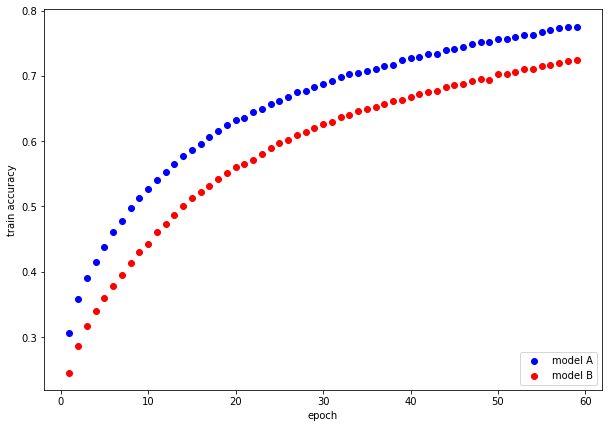

In [ ]:
import numpy as np
eplist= np.arange(nb_epochs)
plt.scatter(eplist[1:], acc_A_global[1:], c ="blue", label = "model A")
#plt.scatter(eplist[1:], acc_A_unmodified_global[1:], c ="green", label = "model A on original set")
plt.scatter(eplist[1:], acc_B_global[1:], c ="red", label = "model B")

plt.xlabel("epoch")
plt.ylabel("train accuracy")
plt.legend(loc='lower right')
plt.show()

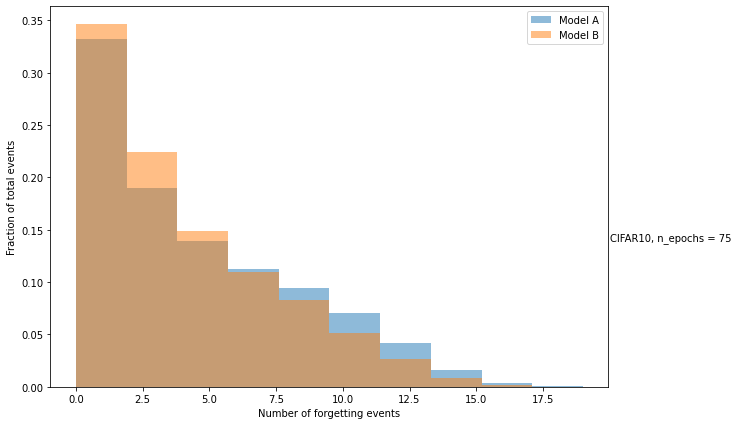

In [ ]:
import numpy as np
cumulative_forgetting_A = torch.sum(forget_matrix_A, 0)
cumulative_forgetting_B = torch.sum(forget_matrix_B, 0)

forgetlen_A = len(torch.flatten(cumulative_forgetting_A))
forgetlen_B = len(torch.flatten(cumulative_forgetting_B))

hist_A = plt.hist(torch.flatten(cumulative_forgetting_A), alpha=0.5, label = "Model A", weights = np.ones(forgetlen_A)/forgetlen_A)
hist_B = plt.hist(torch.flatten(cumulative_forgetting_B), alpha=0.5, label = "Model B", weights = np.ones(forgetlen_B)/forgetlen_B)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(20, .14, r'CIFAR10, n_epochs = 75')
plt.legend(loc='upper right')
plt.show()

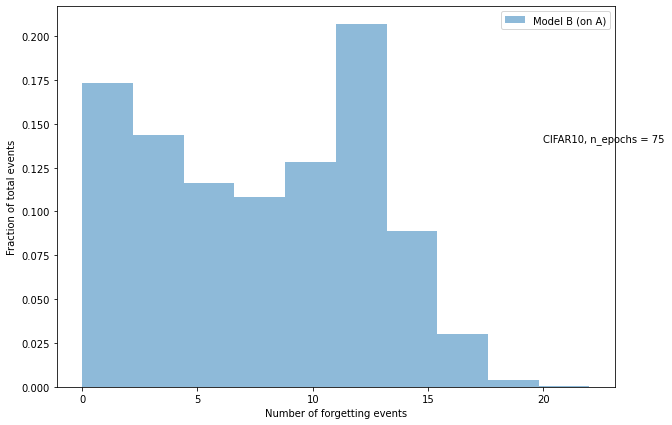

In [ ]:
cumulative_forgetting_B_on_A = torch.sum(forget_matrix_B_on_A, 0)

forgetlen_B_on_A = len(torch.flatten(cumulative_forgetting_B_on_A))

hist_B = plt.hist(torch.flatten(cumulative_forgetting_B_on_A), alpha=0.5, label = "Model B (on A)", weights = np.ones(forgetlen_B_on_A)/forgetlen_B_on_A)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(20, .14, r'CIFAR10, n_epochs = 75')
plt.legend(loc='upper right')
plt.show()

In [ ]:
forget_matrix_A[0:2].size()

torch.Size([2, 391, 128])

In [ ]:
torch.flatten(forget_matrix_A[0:2], 1).size()

torch.Size([2, 50048])

In [ ]:
forget_fcn_epoch_A = list()
forget_fcn_epoch_B = list()
forget_fcn_epoch_B_on_A=list()

for i in range(nb_epochs):
    forget_fcn_epoch_A.append(torch.sum(torch.flatten(forget_matrix_A[i]),0))
    forget_fcn_epoch_B.append(torch.sum(torch.flatten(forget_matrix_B[i]),0))
    forget_fcn_epoch_B_on_A.append(torch.sum(torch.flatten(forget_matrix_B_on_A[i]),0))

In [ ]:
torch.flatten(forget_matrix_A[20])

torch.Size([50048])

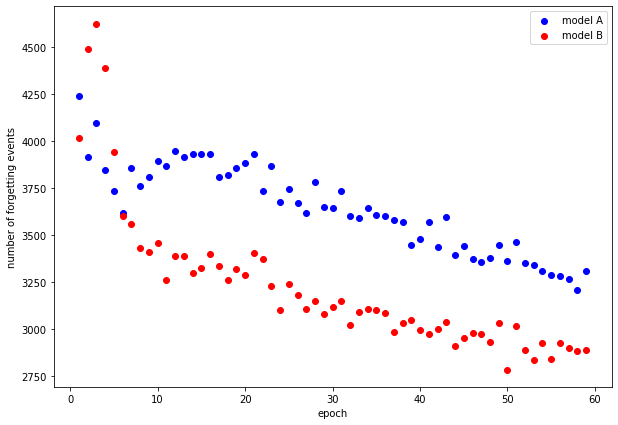

In [ ]:
eplist= np.arange(nb_epochs)
plt.scatter(eplist[1:], forget_fcn_epoch_A[1:], c ="blue", label = "model A")
plt.scatter(eplist[1:], forget_fcn_epoch_B[1:], c ="red", label = "model B")
#plt.scatter(eplist[1:], forget_fcn_epoch_B_on_A[1:], c ="green", label = "model B on A")
plt.xlabel("epoch")
plt.ylabel("number of forgetting events")
plt.legend(loc='upper right')
plt.show()

what is the scaling?

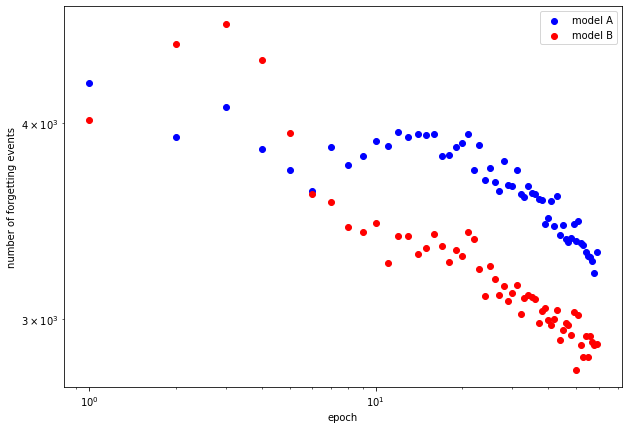

In [ ]:
eplist= np.arange(nb_epochs)
plt.scatter(eplist[1:], forget_fcn_epoch_A[1:], c ="blue", label = "model A")
plt.scatter(eplist[1:], forget_fcn_epoch_B[1:], c ="red", label = "model B")
plt.yscale('log')
plt.xscale('log')

plt.xlabel("epoch")
plt.ylabel("number of forgetting events")
plt.legend(loc='upper right')
plt.show()

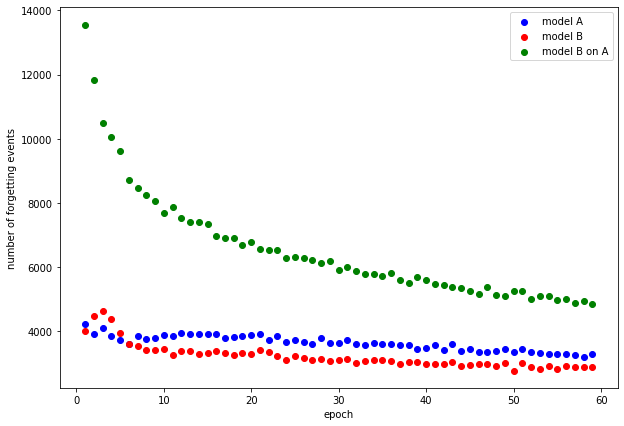

In [ ]:
eplist= np.arange(nb_epochs)
plt.scatter(eplist[1:], forget_fcn_epoch_A[1:], c ="blue", label = "model A")
plt.scatter(eplist[1:], forget_fcn_epoch_B[1:], c ="red", label = "model B")
plt.scatter(eplist[1:], forget_fcn_epoch_B_on_A[1:], c ="green", label = "model B on A")
plt.xlabel("epoch")
plt.ylabel("number of forgetting events")
plt.legend(loc='upper right')
plt.show()

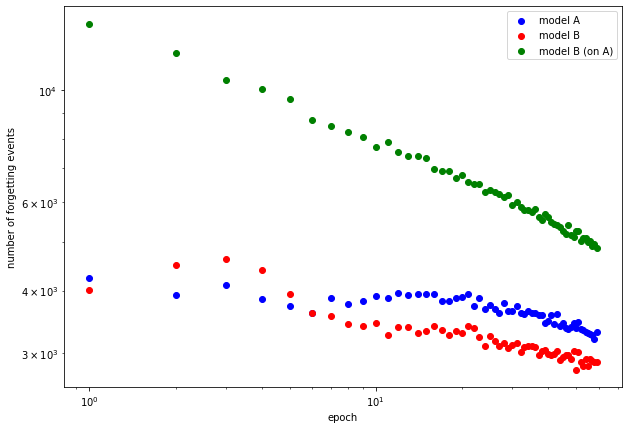

In [ ]:
plt.scatter(eplist[1:], forget_fcn_epoch_A[1:], c ="blue", label = "model A")
plt.scatter(eplist[1:], forget_fcn_epoch_B[1:], c ="red", label = "model B")
plt.scatter(eplist[1:], forget_fcn_epoch_B_on_A[1:], c ="green", label = "model B (on A)")
plt.yscale('log')
plt.xscale('log')

plt.xlabel("epoch")
plt.ylabel("number of forgetting events")
plt.legend(loc='upper right')
plt.show()

## Scratch

In [ ]:
testA = torch.flatten(cumulative_forgetting_A)
testAnonzero = testA[testA!=0]

testB = torch.flatten(cumulative_forgetting_B)
testBnonzero = testB[testB!=0]

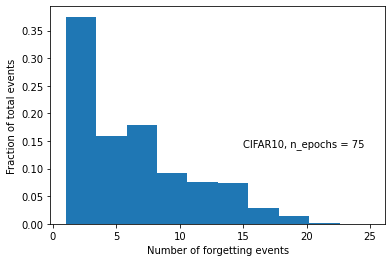

In [ ]:
plt.hist(testAnonzero, label = "Events", weights = np.ones(len(testAnonzero))/len(testAnonzero))
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(15, .14, r'CIFAR10, n_epochs = 75')
plt.show()

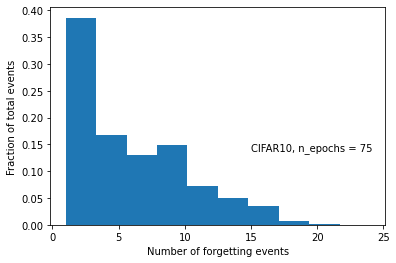

In [ ]:
plt.hist(testBnonzero, label = "Events", weights = np.ones(len(testBnonzero))/len(testBnonzero))
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(15, .14, r'CIFAR10, n_epochs = 75')
plt.show()

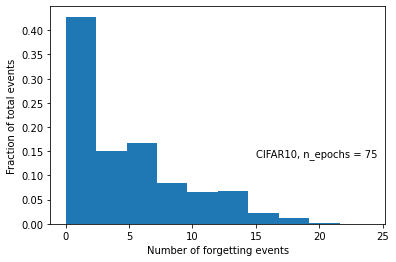

In [ ]:
hist_B = plt.hist(torch.flatten(cumulative_forgetting_B), label = "Events", weights = np.ones(forgetlen_B)/forgetlen_B)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(15, .14, r'CIFAR10, n_epochs = 75')
plt.show()

In [ ]:
torch.sum(torch.sum(cumulative_forgetting_A,0))

tensor(232525.)

In [ ]:
torch.sum(torch.sum(cumulative_forgetting_B,0))

tensor(235151.)

In [ ]:
cumulative_forgetting_B -cumulative_forgetting_A

tensor([[ -7.,  -4.,   0.,  ...,   1.,   2.,   4.],
        [ -5.,   1., -12.,  ...,  -7.,   6.,   0.],
        [  2.,   1.,  -7.,  ...,   1.,   1.,   0.],
        ...,
        [ -6.,   7.,  -2.,  ...,   0.,  -7.,  -2.],
        [ -4.,   3.,   0.,  ...,   2.,  -2.,   1.],
        [  2.,   0.,   0.,  ...,   0.,   0.,   0.]])

In [ ]:
forget_matrix_A.size()

torch.Size([10, 391, 128])

In [ ]:
x,y = next(iter(train_set))
x=x.cuda()

In [ ]:
lb = model_B(x.cuda())
la = model_A(x.cuda())

In [ ]:
la.size()

torch.Size([128, 10])

In [ ]:
len(la)

128

# With Cross Entropy loss

In [ ]:
#First load models, dataset

!git clone https://github.com/facebookresearch/open_lth.git
import sys
sys.path.append('/content/open_lth/')

from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_A = registry.get(model_hparams).cuda()
model_B = registry.get(model_hparams).cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss_A = nn.CrossEntropyLoss()
loss_B =  nn.CrossEntropyLoss() #nn.KLDivLoss() #nn.CrossEntropyLoss()
optimizer_A = optim.SGD(model_A.parameters(), lr=1e-3, momentum=0.9)
optimizer_B = optim.SGD(model_B.parameters(), lr=1e-3, momentum=0.9)

fatal: destination path 'open_lth' already exists and is not an empty directory.
Files already downloaded and verified


In [ ]:
nb_epochs = 80
batch_size = 128
#output_vectors = torch.empty(nb_epochs, len(train_set), batch_size, 10)
a_i_A = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_A = torch.zeros(len(train_set),128)

model_B_on_A_acc = torch.zeros(len(train_set),128)
model_B_on_A_acc_tilde = torch.zeros(len(train_set),128)

a_i_B = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_B = torch.zeros(len(train_set),128)

forget_matrix_A = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of A
forget_matrix_B = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of B wrt image classification
forget_matrix_B_on_A = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of B wrt A logits

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification
batch_tracker = 0

#initialize previous logits
model_A.eval()
#first_x, first_y = next(iter(train_set))

l_A_previous = torch.zeros(nb_epochs, len(train_set), 128, 10)

model_A.eval()
model_B.eval()

#initialize previous logits
# for batch in train_set:
#     x, y = batch
#     x=x.cuda()
#     l_A = model_A(x)
#     with torch.no_grad():
#         l_A_previous[0, batch_tracker, 0:len(l_A)] = l_A #set previous logits equal to current logits to start with
#     batch_tracker += 1

model_A.train()
model_B.train()
batch_tracker = 0

for epoch in range(nb_epochs):
    losses_A = list()
    accuracies_A = list()

    losses_B = list()
    accuracies_B = list()

    for batch in train_set:
        x, y = batch
        x = x.cuda()

        l_A = model_A(x)
        l_A_prime = model_A(x)
        l_B = model_B(x)

        with torch.no_grad():
            l_A_previous[epoch, batch_tracker, 0:len(l_A)] = l_A #set previous logits equal to current logits to start with
    
        #batch_size_current = len(batch[1])
        #output_vectors[epoch, batch_tracker, 0:batch_size_current] = l_A

        #check if model A's prediction is correctly classified
        l_A_softmax = softmaxfunc(l_A)
        if epoch >1:
            l_A_previous_softmax = softmaxfunc(l_A_previous[epoch-1, batch_tracker])

        for k in range(len(l_A_softmax)):
            if torch.argmax(l_A_softmax[k])==y[k]: #if it is, mark as '1'
                a_i_A[batch_tracker, k] = 1
            else:
                a_i_A[batch_tracker, k] = 0 #otherwise 0

            if a_i_A[batch_tracker, k] < a_tilde_i_A[batch_tracker, k]: #and if we find that the marker has decreased, we've forgotten the example
                forget_matrix_A[epoch, batch_tracker, k] += 1
                
                #if we forgot the example, build new logits which involve previous ones
                #we will use this to rewind the logits
                #try:
                if epoch > 1 and torch.argmax(l_A_previous_softmax[k])==y[k]:
                    #print(f"Forgot example! Replacing {l_A_prime[k]} with {l_A_previous[epoch-1,batch_tracker, k]} \n")
                    #print(f"Was it classified correctly before? {torch.argmax(l_A_previous_softmax[k])==y[k]}")
                    l_A_prime[k] = l_A_previous[epoch-1,batch_tracker, k]
                #except IndexError:
                    #print(f"batch_Tracker {batch_tracker} k {k}")

            a_tilde_i_A[batch_tracker, k] = a_i_A[batch_tracker, k]
    
        #now do the same with model B
        l_B_softmax = softmaxfunc(l_B)

        for k in range(len(l_B_softmax)):
            if torch.argmax(l_B_softmax[k])==y[k]:
                a_i_B[batch_tracker, k] = 1
            else:
                a_i_B[batch_tracker, k] = 0

            if a_i_B[batch_tracker, k] < a_tilde_i_B[batch_tracker, k]:
                forget_matrix_B[epoch, batch_tracker, k] += 1

            a_tilde_i_B[batch_tracker, k] = a_i_B[batch_tracker, k]

            #also measure how much it forgets w.r.t. the task it is trained for
            #(how much it forgets model A's logits)
            if torch.argmax(l_B_softmax[k])==torch.argmax(l_A_softmax[k]):
                model_B_on_A_acc[batch_tracker, k] = 0
            else:
                model_B_on_A_acc[batch_tracker, k] = 1
            
            if model_B_on_A_acc[batch_tracker, k] < model_B_on_A_acc_tilde[batch_tracker, k]:
                forget_matrix_B_on_A[epoch, batch_tracker, k] += 1
            
            model_B_on_A_acc_tilde[batch_tracker, k] = model_B_on_A_acc[batch_tracker, k]



        #2. compute objective function for A and B
        J_A = loss_A(l_A, y.cuda())
        #print(J_A)

        #we need to first see if the example got forgotten
        #if so, we need to feed in l_A_previous to model_B's loss function
        #otherwise, use the current logits

        #model B's loss is to compute cross entropy between its output and the output of model A
        
        targets=torch.argmax(l_A_prime, 1)
        #J_B = loss_B(l_B, l_A_prime)
        J_B = loss_B(l_B, targets)

        #3. cleaning the gradients
        model_A.zero_grad()
        model_B.zero_grad()

        #reset previous logits
        #l_A_previous[] = l_A

        #4. accumulate partial derivatives
        J_A.backward()

        #J_A.backward(retain_graph=True)
        J_B.backward() #bug!

        #5. step in opposite direction
        optimizer_A.step()
        optimizer_B.step()

        #6. monitor loss
        losses_A.append(J_A.item())
        losses_B.append(J_B.item())
        accuracies_A.append(y.eq(l_A.detach().argmax(dim=1).cpu()).float().mean())
        accuracies_B.append(y.eq(l_B.detach().argmax(dim=1).cpu()).float().mean())



        batch_tracker+=1


    print(f"Epoch {epoch +1}, train loss A, B: {torch.tensor(losses_A).mean():.2f} , {torch.tensor(losses_B).mean():.2f} \n")
    print(f"Training accuracy for A, B: {torch.tensor(accuracies_A).mean():.2f} , {torch.tensor(accuracies_B).mean():.2f} \n")
    batch_tracker = 0

Epoch 1, train loss A, B: 2.12 , 1.61 

Training accuracy for A, B: 0.22 , 0.17 

Epoch 2, train loss A, B: 1.81 , 1.24 

Training accuracy for A, B: 0.33 , 0.28 

Epoch 3, train loss A, B: 1.69 , 1.04 

Training accuracy for A, B: 0.37 , 0.33 

Epoch 4, train loss A, B: 1.62 , 0.94 

Training accuracy for A, B: 0.39 , 0.36 

Epoch 5, train loss A, B: 1.56 , 0.89 

Training accuracy for A, B: 0.42 , 0.39 

Epoch 6, train loss A, B: 1.51 , 0.86 

Training accuracy for A, B: 0.44 , 0.40 

Epoch 7, train loss A, B: 1.46 , 0.85 

Training accuracy for A, B: 0.46 , 0.42 

Epoch 8, train loss A, B: 1.41 , 0.84 

Training accuracy for A, B: 0.48 , 0.44 

Epoch 9, train loss A, B: 1.37 , 0.83 

Training accuracy for A, B: 0.50 , 0.46 

Epoch 10, train loss A, B: 1.33 , 0.82 

Training accuracy for A, B: 0.52 , 0.47 

Epoch 11, train loss A, B: 1.29 , 0.80 

Training accuracy for A, B: 0.53 , 0.49 

Epoch 12, train loss A, B: 1.25 , 0.78 

Training accuracy for A, B: 0.55 , 0.50 

Epoch 13, tra

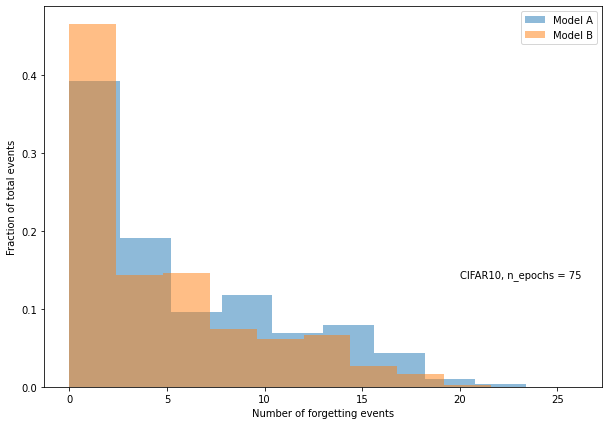

In [ ]:
import numpy as np
cumulative_forgetting_A = torch.sum(forget_matrix_A, 0)
cumulative_forgetting_B = torch.sum(forget_matrix_B, 0)

forgetlen_A = len(torch.flatten(cumulative_forgetting_A))
forgetlen_B = len(torch.flatten(cumulative_forgetting_B))

hist_A = plt.hist(torch.flatten(cumulative_forgetting_A), alpha=0.5, label = "Model A", weights = np.ones(forgetlen_A)/forgetlen_A)
hist_B = plt.hist(torch.flatten(cumulative_forgetting_B), alpha=0.5, label = "Model B", weights = np.ones(forgetlen_B)/forgetlen_B)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(20, .14, r'CIFAR10, n_epochs = 75')
plt.legend(loc='upper right')
plt.show()

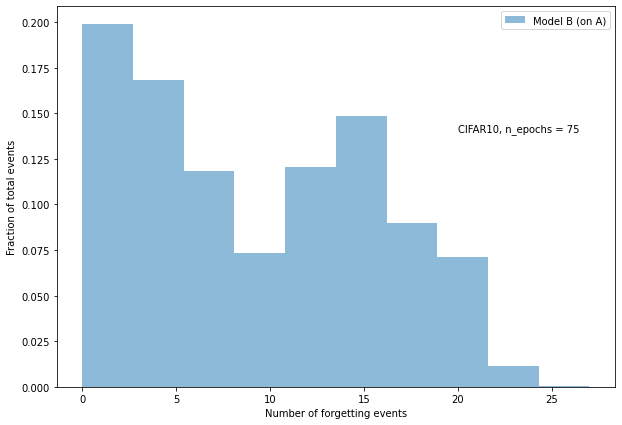

In [ ]:
cumulative_forgetting_B_on_A = torch.sum(forget_matrix_B_on_A, 0)

forgetlen_B_on_A = len(torch.flatten(cumulative_forgetting_B_on_A))

hist_B = plt.hist(torch.flatten(cumulative_forgetting_B_on_A), alpha=0.5, label = "Model B (on A)", weights = np.ones(forgetlen_B_on_A)/forgetlen_B_on_A)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(20, .14, r'CIFAR10, n_epochs = 75')
plt.legend(loc='upper right')
plt.show()

In [ ]:
forget_fcn_epoch_A = list()
forget_fcn_epoch_B = list()
forget_fcn_epoch_B_on_A=list()

for i in range(nb_epochs):
    forget_fcn_epoch_A.append(torch.sum(torch.flatten(forget_matrix_A[i]),0))
    forget_fcn_epoch_B.append(torch.sum(torch.flatten(forget_matrix_B[i]),0))
    forget_fcn_epoch_B_on_A.append(torch.sum(torch.flatten(forget_matrix_B_on_A[i]),0))

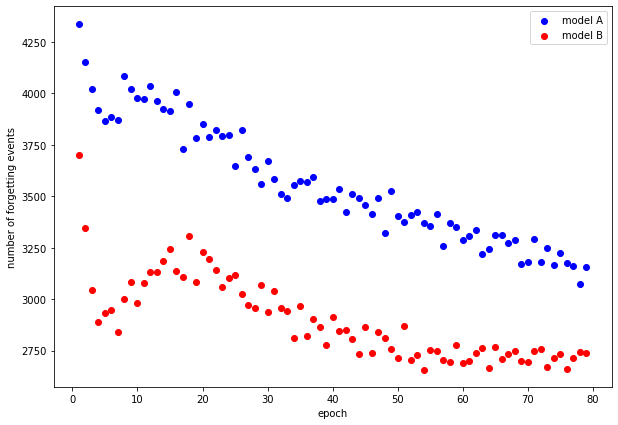

In [ ]:
eplist= np.arange(nb_epochs)
plt.scatter(eplist[1:], forget_fcn_epoch_A[1:], c ="blue", label = "model A")
plt.scatter(eplist[1:], forget_fcn_epoch_B[1:], c ="red", label = "model B")
#plt.scatter(eplist[1:], forget_fcn_epoch_B_on_A[1:], c ="green", label = "model B on A")
plt.xlabel("epoch")
plt.ylabel("number of forgetting events")
plt.legend(loc='upper right')
plt.show()

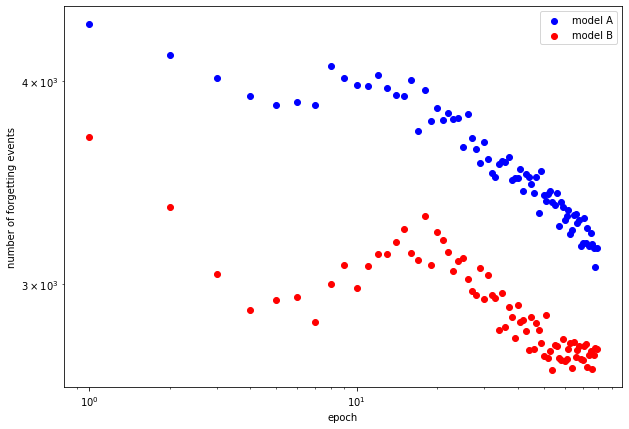

In [ ]:
eplist= np.arange(nb_epochs)
plt.scatter(eplist[1:], forget_fcn_epoch_A[1:], c ="blue", label = "model A")
plt.scatter(eplist[1:], forget_fcn_epoch_B[1:], c ="red", label = "model B")
#plt.scatter(eplist[1:], forget_fcn_epoch_B_on_A[1:], c ="green", label = "model B on A")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("epoch")
plt.ylabel("number of forgetting events")
plt.legend(loc='upper right')
plt.show()

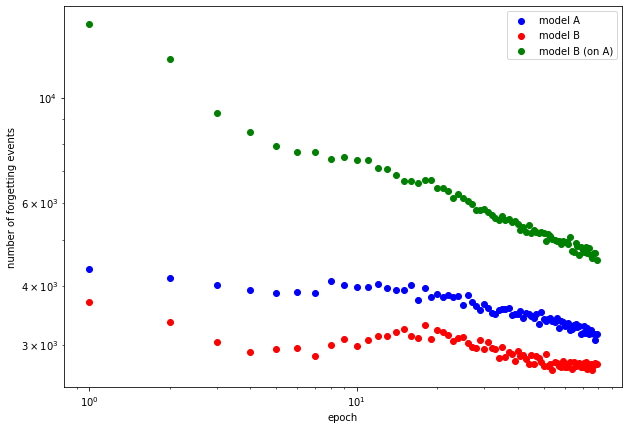

In [ ]:
plt.scatter(eplist[1:], forget_fcn_epoch_A[1:], c ="blue", label = "model A")
plt.scatter(eplist[1:], forget_fcn_epoch_B[1:], c ="red", label = "model B")
plt.scatter(eplist[1:], forget_fcn_epoch_B_on_A[1:], c ="green", label = "model B (on A)")
plt.yscale('log')
plt.xscale('log')

plt.xlabel("epoch")
plt.ylabel("number of forgetting events")
plt.legend(loc='upper right')
plt.show()

In [ ]:
total_A = torch.sum(torch.flatten(cumulative_forgetting_A))
total_B = torch.sum(torch.flatten(cumulative_forgetting_B))
print(total_A)
print(total_B)
print(total_A/total_B)

tensor(281272.)
tensor(228934.)
tensor(1.2286)


trace the history of a specific example

In [ ]:
torch.sum(forget_matrix_A[79],

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
cumulative_forgotten_ex_B.size()

torch.Size([79])

In [ ]:
len(eplist[1:])

79

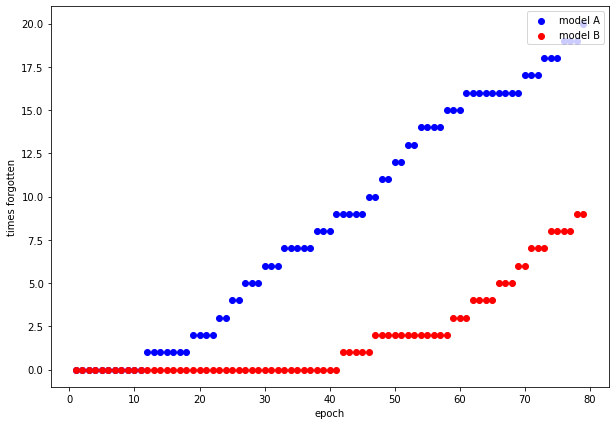

In [ ]:
cumulative_forgotten_ex_A = torch.flatten(torch.cumsum(forget_matrix_A[0:80,45,0],0))
cumulative_forgotten_ex_B = torch.flatten(torch.cumsum(forget_matrix_B[0:80,45,0],0))

plt.scatter(eplist[1:], cumulative_forgotten_ex_A[1:], c ="blue", label = "model A")
plt.scatter(eplist[1:], cumulative_forgotten_ex_B[1:], c ="red", label = "model B")
#plt.scatter(eplist[1:], forget_fcn_epoch_B_on_A[1:], c ="green", label = "model B on A")
plt.xlabel("epoch")
plt.ylabel("times forgotten")
plt.legend(loc='upper right')
plt.show()

check training accuracy between the different models

In [ ]:
test_set = registry.get(
    dataset_hparams,
    train = False
)

model_A.eval()
model_B.eval()
test_accuracy_A = list()
test_accuracy_B = list()

batch_counter = 0
for batch in test_set:
    x, y = batch
    x = x.cuda()

    with torch.no_grad():
        l_A = model_A(x)
        l_B = model_B(x)
        
    test_accuracy_A.append(y.eq(l_A.detach().argmax(dim=1).cpu()).float().mean())
    test_accuracy_B.append(y.eq(l_B.detach().argmax(dim=1).cpu()).float().mean())
    
    if batch_counter%10 == 0:
        print(f"Test accuracy A: {torch.tensor(test_accuracy_A).mean():.2f} \n")
        print(f"Test accuracy B: {torch.tensor(test_accuracy_B).mean():.2f} \n")
    
    batch_counter+=1

Files already downloaded and verified
Test accuracy A: 0.84 

Test accuracy B: 0.78 

Test accuracy A: 0.79 

Test accuracy B: 0.76 

Test accuracy A: 0.78 

Test accuracy B: 0.75 

Test accuracy A: 0.78 

Test accuracy B: 0.76 

Test accuracy A: 0.79 

Test accuracy B: 0.76 

Test accuracy A: 0.79 

Test accuracy B: 0.76 

Test accuracy A: 0.79 

Test accuracy B: 0.76 

Test accuracy A: 0.79 

Test accuracy B: 0.76 



# Distillation when we Rewind to Minimal Loss Logits

Tried a bunch of things here where model B is distilled from A using lowest loss logits from A. Summary:


*   Cross entropy with targets still seems best loss function (??) for model B even though we are throwing out lots of information by argmax'ing over model A's logits. I tried wiht binary cross entropy with logits, as well as KLDivLoss.
*   Model B does better if rewinding only happens after forgetting events (always rewinding to minimal loss logits seems to do worse)



In [ ]:
!git clone https://github.com/facebookresearch/open_lth.git
import sys
sys.path.append('/content/open_lth/')

from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_A = registry.get(model_hparams).cuda()
model_B = registry.get(model_hparams).cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss_A = nn.CrossEntropyLoss()
loss_B =  nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()#nn.CrossEntropyLoss() #nn.KLDivLoss() #nn.CrossEntropyLoss()
optimizer_A = optim.SGD(model_A.parameters(), lr=1e-3, momentum=0.9)
optimizer_B = optim.SGD(model_B.parameters(), lr=1e-3, momentum=0.9)

Cloning into 'open_lth'...
remote: Enumerating objects: 112, done.
remote: Total 112 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (112/112), 88.23 KiB | 740.00 KiB/s, done.
Resolving deltas: 100% (18/18), done.


  0%|          | 0/170498071 [00:00<?, ?it/s]

## Scratch

In [ ]:
losses_tracker = torch.zeros(3, len(train_set),128)
btracker = 0
l_A_previous = torch.zeros(3, len(train_set), 128, 10)


import random 

for epoch in range(3):
    for batch in train_set:
        x,y = next(iter(train_set)) #load the batch
        x=x.cuda()
        y=y.cuda()

        l_A = model_A(x) #compute logits
        l_A_prime = l_A.detach()

        with torch.no_grad():
            l_A_previous[epoch, btracker, 0:len(l_A)] = l_A.detach() #set previous logits equal to current logits to start with

        loss_batch = loss_A(l_A, y.cuda()) #this computes the loss for the full batch

        for k in range(len(l_A)):
                losses_tracker[epoch, btracker, k] = loss_A(l_A[k: k+1].detach(),y[k: k+1].detach()) + random.random()
            #losses_tracker[1,btracker,k] = loss_A(l_A[k: k+1].detach(),y[k: k+1].detach()) + random.random()
            

        sorted, idx = torch.sort(losses_tracker,0)
        #modify current logits

        for k in range(len(l_A_prime)):
            for ep in range(len(3)):
                for id in idx[ep, btracker]:
                    if id==0:
                        l_A_prime[k] = l_A_previous[ep, btracker, k]
        
        targets=torch.argmax(l_A_prime, 1)
        l_B = model_B(l_A_prime, targets.cuda())
        
        btracker+=1
    btracker = 0

TypeError: ignored

In [ ]:
l_A_previous[0, 10, 1]

tensor([-1.6937, -1.2217, -1.2623,  0.6020, -1.4037,  1.5340,  0.0858,  0.1984,
         0.2974, -0.0422])

In [ ]:
idx[0,10]

tensor([1, 0, 1, 1, 2, 1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 1, 1, 0, 1, 2, 0, 2, 2, 1,
        2, 2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 0, 1, 0, 0, 2, 1, 0, 2, 0, 2,
        1, 1, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 0, 2, 0, 1, 1, 0, 1, 2, 0, 2, 1, 0,
        0, 2, 2, 0, 1, 2, 2, 0, 0, 1, 2, 0, 1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 0,
        0, 2, 0, 0, 0, 1, 1, 0])

In [ ]:
tmpbatch = 0
ep
[i for i in range(len(idx[tmpbatch])) if idx[tmpbatch, i] == 0]

RuntimeError: ignored

In [ ]:
tmpbatch = 0
for k in range(len(l_A_prime)):
    for ep in range(len(3)):
        for id in idx[ep, tmpbatch]:
            if id==0:
                l_A_prime[k] = l_A_previous[ep, tmpbatch, k]

In [ ]:
idx[0][0]

tensor([1, 0, 0, 2, 0, 0, 2, 1, 0, 2, 1, 2, 2, 1, 2, 2, 1, 1, 0, 2, 0, 0, 1, 1,
        1, 2, 2, 2, 0, 0, 2, 0, 1, 2, 1, 2, 1, 1, 0, 2, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 2, 0, 1, 1, 1, 2, 0, 2, 1, 1, 2, 2, 0, 2, 0, 1, 2, 1, 1, 1, 2,
        2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 2, 1, 0, 1, 2, 2, 1, 0, 1, 1,
        0, 2, 2, 1, 0, 1, 2, 0, 0, 1, 0, 1, 2, 0, 1, 2, 2, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 2, 0, 0])

In [ ]:
l_A[2]

tensor([-1.4280, -1.2980, -0.9409,  0.4770, -1.0139,  1.4150, -0.4508,  0.3935,
         0.6328,  0.1319], device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
print(idx[2,0])
print(idx[0,0])
print(idx[1,0])

tensor([0, 0, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 0, 1, 2, 0,
        2, 1, 1, 2, 0, 0, 2, 0, 1, 1, 0, 0, 1, 1, 2, 2, 0, 2, 0, 1, 2, 1, 1, 0,
        1, 1, 2, 1, 2, 1, 2, 2, 1, 0, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0, 2, 1, 2, 0,
        2, 0, 1, 2, 1, 0, 1, 1, 1, 0, 0, 2, 2, 1, 0, 2, 2, 0, 0, 2, 1, 0, 1, 1,
        1, 0, 2, 1, 2, 2, 0, 2, 0, 0, 1, 0, 1, 0, 2, 2, 1, 2, 0, 0, 0, 2, 2, 2,
        1, 1, 0, 2, 0, 1, 0, 1])
tensor([2, 1, 1, 0, 1, 0, 1, 2, 2, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 2, 2, 0, 1,
        0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 2,
        2, 2, 0, 2, 0, 0, 1, 0, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 1,
        1, 1, 2, 0, 2, 2, 0, 2, 2, 1, 1, 0, 0, 2, 1, 1, 0, 1, 1, 1, 2, 1, 0, 2,
        0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1,
        2, 2, 1, 0, 2, 2, 2, 2])
tensor([1, 2, 0, 2, 0, 2, 2, 0, 0, 2, 1, 0, 2, 1, 0, 2, 1, 2, 1, 1, 1, 0, 1, 2,
        1, 2, 2, 0, 2, 1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 1

In [ ]:
l_A[0]

tensor([-0.0431,  0.6108, -0.1781,  0.2541, -0.8880, -0.2022,  0.9137,  0.3573,
         0.0535,  0.5141], device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
l_A.size()

torch.Size([128, 10])

In [ ]:
idx.size()

torch.Size([2, 391, 128])

In [ ]:
print(idx.size())
print(losses_tracker.size())

torch.Size([3, 391, 128])
torch.Size([3, 391, 128])


In [ ]:
l_A_previous.size()

torch.Size([2, 391, 128, 10])

In [ ]:
l_A.size()

torch.Size([128, 10])

In [ ]:
len(l_A)

128

In [ ]:
print(idx[0,0])
print(idx[1,0])

tensor([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0])
tensor([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1])


In [ ]:
losses_tracker.size()
losses_sorted, idx = torch.sort(losses_tracker[0:2], 0)

In [ ]:
l_A

tensor([[-1.7503, -1.2346, -0.1005,  ...,  0.6142, -2.3046, -0.8745],
        [ 0.4934,  1.9253, -0.8022,  ...,  0.3051,  1.2250,  1.7169],
        [ 0.8733,  0.6798, -0.1956,  ...,  0.6543,  0.7015,  1.2924],
        ...,
        [-0.8566, -0.3387, -0.3000,  ...,  0.9149, -1.2799,  0.4120],
        [ 2.7103,  1.0410, -0.2073,  ..., -0.2489,  3.2315,  1.6605],
        [ 1.3707,  1.3316, -0.5506,  ...,  0.3252,  1.8202,  1.6500]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
l_A[idx[0,0]].size()

torch.Size([128, 10])

In [ ]:
print(loss_B(l_B, targets.cuda()))
softmaxfunc=nn.Softmax(dim=1)
#testloss=nn.functional.binary_cross_entropy_with_logits()#nn.KLDivLoss()
newloss = nn.functional.binary_cross_entropy_with_logits(softmaxfunc(l_B), softmaxfunc(l_A_prime.cuda()))

tensor(0.5021, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
newloss.backward()

RuntimeError: ignored

## Train

In [ ]:
nb_epochs = 40
batch_size = 128
#output_vectors = torch.empty(nb_epochs, len(train_set), batch_size, 10)
a_i_A = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_A = torch.zeros(len(train_set),128)

model_B_on_A_acc = torch.zeros(len(train_set),128)
model_B_on_A_acc_tilde = torch.zeros(len(train_set),128)

a_i_B = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_B = torch.zeros(len(train_set),128)

forget_matrix_A = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of A
forget_matrix_B = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of B wrt image classification
forget_matrix_B_on_A = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of B wrt A logits

losses_tracker = torch.zeros(nb_epochs, len(train_set),128)

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification
batch_tracker = 0
acc_A_global = list()
acc_B_global = list()

#initialize previous logits
model_A.eval()
#first_x, first_y = next(iter(train_set))

l_A_previous = torch.zeros(nb_epochs, len(train_set), 128, 10)

model_A.eval()
model_B.eval()

model_A.train()
model_B.train()
batch_tracker = 0

forget_thres = 4

for epoch in range(nb_epochs):
    losses_A = list()
    accuracies_A = list()

    losses_B = list()
    accuracies_B = list()

    for batch in train_set:
        x, y = batch
        x = x.cuda()

        l_A = model_A(x)
        l_A_prime = l_A.clone().detach()
        l_B = model_B(x.clone().detach())

        with torch.no_grad():
            l_A_previous[epoch, batch_tracker, 0:len(l_A)] = l_A.clone().detach() #set previous logits equal to current logits to start with
    
        #batch_size_current = len(batch[1])
        #output_vectors[epoch, batch_tracker, 0:batch_size_current] = l_A

        #check if model A's prediction is correctly classified
        l_A_softmax = softmaxfunc(l_A)

        if epoch >1:
            l_A_previous_softmax = softmaxfunc(l_A_previous[epoch-1, batch_tracker])

        for j in range(len(l_A)):
            with torch.no_grad():
                losses_tracker[epoch, batch_tracker, j] = loss_A(l_A[j: j+1].detach(),y[j: j+1].cuda().detach())
        
        #scan for lowest loss in previous epochs:
        if epoch > 1:
            losses_sorted, idx = torch.sort(losses_tracker[0:epoch+1], 0)

        for k in range(len(l_A_softmax)):
            if torch.argmax(l_A_softmax[k])==y[k]: #if it is, mark as '1'
                a_i_A[batch_tracker, k] = 1
            else:
                a_i_A[batch_tracker, k] = 0 #otherwise 0

            if a_i_A[batch_tracker, k] < a_tilde_i_A[batch_tracker, k]: #and if we find that the marker has decreased, we've forgotten the example
                forget_matrix_A[epoch, batch_tracker, k] += 1
                
                #if we forgot the example, build new logits which involve previous ones
                #we will use this to rewind the logits to lowest loss ones
                #try:
            if epoch > 1 and torch.sum(forget_matrix_A,0)[batch_tracker, k] > forget_thres:
                #and then change logits to lowest loss ones
                for ep in range(epoch):
                    for id in idx[ep, batch_tracker]:
                        if id==0:
                            l_A_prime[k] = l_A_previous[ep, batch_tracker, k]
                            #print(f"Rewound logits from {l_A_prime[k]} to {l_A_previous[ep, batch_tracker, k]} (loss from {losses_tracker[epoch, batch_tracker, k]} to {losses_tracker[ep, batch_tracker, k]}) \n")
                    

            a_tilde_i_A[batch_tracker, k] = a_i_A[batch_tracker, k]
    
        #now do the same with model B
        l_B_softmax = softmaxfunc(l_B)

        for k in range(len(l_B_softmax)):
            if torch.argmax(l_B_softmax[k])==y[k]:
                a_i_B[batch_tracker, k] = 1
            else:
                a_i_B[batch_tracker, k] = 0

            if a_i_B[batch_tracker, k] < a_tilde_i_B[batch_tracker, k]:
                forget_matrix_B[epoch, batch_tracker, k] += 1

            a_tilde_i_B[batch_tracker, k] = a_i_B[batch_tracker, k]

            #also measure how much it forgets w.r.t. the task it is trained for
            #(how much it forgets model A's logits)
            if torch.argmax(l_B_softmax[k])==torch.argmax(l_A_softmax[k]):
                model_B_on_A_acc[batch_tracker, k] = 0
            else:
                model_B_on_A_acc[batch_tracker, k] = 1
            
            if model_B_on_A_acc[batch_tracker, k] < model_B_on_A_acc_tilde[batch_tracker, k]:
                forget_matrix_B_on_A[epoch, batch_tracker, k] += 1
            
            model_B_on_A_acc_tilde[batch_tracker, k] = model_B_on_A_acc[batch_tracker, k]



        #2. compute objective function for A and B
        J_A = loss_A(l_A, y.cuda())
        #print(J_A)

        #we need to first see if the example got forgotten
        #if so, we need to feed in l_A_previous to model_B's loss function
        #otherwise, use the current logits

        #model B's loss is to compute cross entropy between its output and the output of model A
        
        targets=torch.argmax(l_A_prime, 1)
        #J_B = loss_B(l_B, l_A_prime)
        #l_A_prime_softmax = softmaxfunc(l_A_prime)
        #J_B = loss_B(l_B, l_A_prime_softmax.cuda())
        J_B = loss_B(l_B, targets.cuda())

        #3. cleaning the gradients
        model_A.zero_grad()
        model_B.zero_grad()

        #reset previous logits
        #l_A_previous[] = l_A

        #4. accumulate partial derivatives
        J_A.backward()

        #J_A.backward(retain_graph=True)
        J_B.backward() 

        #5. step in opposite direction
        optimizer_A.step()
        optimizer_B.step()

        #6. monitor loss
        losses_A.append(J_A.item())
        losses_B.append(J_B.item())
        accuracies_A.append(y.eq(l_A.detach().argmax(dim=1).cpu()).float().mean())
        accuracies_B.append(y.eq(l_B.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1

    acc_A_global.append(torch.tensor(accuracies_A).mean())
    acc_B_global.append(torch.tensor(accuracies_B).mean())

    print(f"Epoch {epoch +1}, train loss A, B: {torch.tensor(losses_A).mean():.2f} , {torch.tensor(losses_B).mean():.2f} \n")
    print(f"Training accuracy for A, B: {torch.tensor(accuracies_A).mean():.2f} , {torch.tensor(accuracies_B).mean():.2f} \n")
    batch_tracker = 0

In [ ]:
test_set = registry.get(
    dataset_hparams,
    train = False
)

model_A.eval()
model_B.eval()
test_accuracy_A = list()
test_accuracy_B = list()

batch_counter = 0
for batch in test_set:
    x, y = batch
    x = x.cuda()

    with torch.no_grad():
        l_A = model_A(x)
        l_B = model_B(x)
        
    test_accuracy_A.append(y.eq(l_A.detach().argmax(dim=1).cpu()).float().mean())
    test_accuracy_B.append(y.eq(l_B.detach().argmax(dim=1).cpu()).float().mean())
    
    if batch_counter%10 == 0:
        print(f"Test accuracy A: {torch.tensor(test_accuracy_A).mean():.2f} \n")
        print(f"Test accuracy B: {torch.tensor(test_accuracy_B).mean():.2f} \n")
    
    batch_counter+=1

Files already downloaded and verified
Test accuracy A: 0.70 

Test accuracy B: 0.59 

Test accuracy A: 0.70 

Test accuracy B: 0.62 

Test accuracy A: 0.69 

Test accuracy B: 0.63 

Test accuracy A: 0.68 

Test accuracy B: 0.62 

Test accuracy A: 0.69 

Test accuracy B: 0.64 

Test accuracy A: 0.69 

Test accuracy B: 0.63 

Test accuracy A: 0.69 

Test accuracy B: 0.63 

Test accuracy A: 0.68 

Test accuracy B: 0.63 



In [ ]:
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [10, 7]

In [ ]:
acc_A_global[1:]

[tensor(0.3206),
 tensor(0.3656),
 tensor(0.3954),
 tensor(0.4189),
 tensor(0.4455),
 tensor(0.4656),
 tensor(0.4853),
 tensor(0.4971),
 tensor(0.5124),
 tensor(0.5254),
 tensor(0.5366),
 tensor(0.5498)]

In [ ]:
import numpy as np
eplist= np.arange(nb_epochs)
plt.scatter(eplist[1:], acc_A_global[1:], c ="blue", label = "model A")
plt.scatter(eplist[1:], acc_B_global[1:], c ="red", label = "model B")
plt.xlabel("epoch")
plt.ylabel("train accuracy")
plt.show()

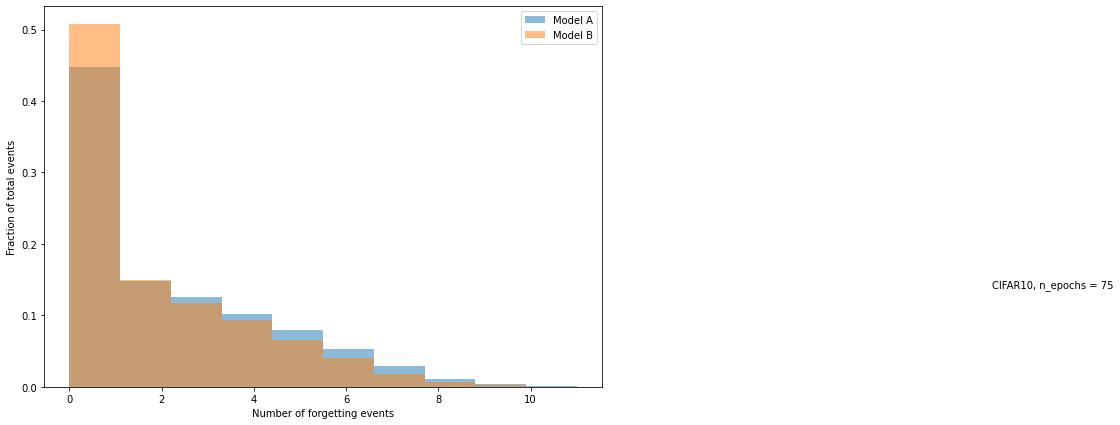

In [ ]:
import numpy as np
cumulative_forgetting_A = torch.sum(forget_matrix_A, 0)
cumulative_forgetting_B = torch.sum(forget_matrix_B, 0)

forgetlen_A = len(torch.flatten(cumulative_forgetting_A))
forgetlen_B = len(torch.flatten(cumulative_forgetting_B))

hist_A = plt.hist(torch.flatten(cumulative_forgetting_A), alpha=0.5, label = "Model A", weights = np.ones(forgetlen_A)/forgetlen_A)
hist_B = plt.hist(torch.flatten(cumulative_forgetting_B), alpha=0.5, label = "Model B", weights = np.ones(forgetlen_B)/forgetlen_B)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(20, .14, r'CIFAR10, n_epochs = 75')
plt.legend(loc='upper right')
plt.show()

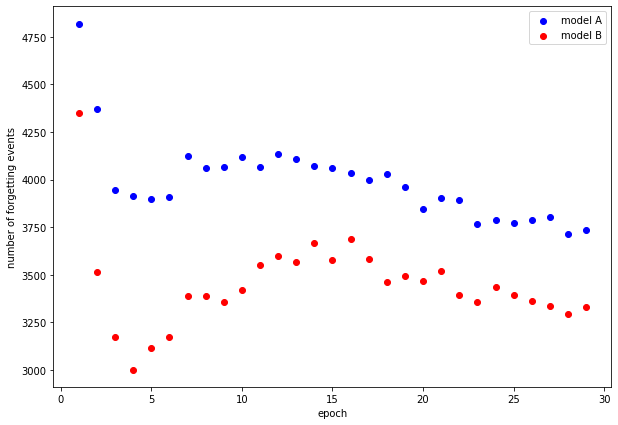

In [ ]:
forget_fcn_epoch_A = list()
forget_fcn_epoch_B = list()
forget_fcn_epoch_B_on_A=list()

for i in range(nb_epochs):
    forget_fcn_epoch_A.append(torch.sum(torch.flatten(forget_matrix_A[i]),0))
    forget_fcn_epoch_B.append(torch.sum(torch.flatten(forget_matrix_B[i]),0))
    forget_fcn_epoch_B_on_A.append(torch.sum(torch.flatten(forget_matrix_B_on_A[i]),0))

eplist= np.arange(nb_epochs)
plt.scatter(eplist[1:], forget_fcn_epoch_A[1:], c ="blue", label = "model A")
plt.scatter(eplist[1:], forget_fcn_epoch_B[1:], c ="red", label = "model B")
#plt.scatter(eplist[1:], forget_fcn_epoch_B_on_A[1:], c ="green", label = "model B on A")
plt.xlabel("epoch")
plt.ylabel("number of forgetting events")
plt.legend(loc='upper right')
plt.show()

# Devin's flashcard idea

## 20% of batch replaced with forgettable examples

Devin proposed the following class of experiments, motivated by the way humans learn not to forget difficult examples using flashcards. During training, identify the more forgettable examples (e.g. forgotten more than 3 times) and put them into a stack. Take some subset from this stack and reintroduce them stochastically into the current batch (kind of like shuffling in difficult flashcards into ones you've already learned).

In [ ]:
#First load models, dataset
#make sure to restart runtime

!git clone https://github.com/facebookresearch/open_lth.git
import sys
sys.path.append('/content/open_lth/')

from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_A = registry.get(model_hparams).cuda()

model_B = registry.get(model_hparams).cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss_A = nn.CrossEntropyLoss()
loss_B =  nn.CrossEntropyLoss() #nn.KLDivLoss() #nn.CrossEntropyLoss()
optimizer_A = optim.SGD(model_A.parameters(), lr=1e-3, momentum=0.9)
optimizer_B = optim.SGD(model_B.parameters(), lr=1e-3, momentum=0.9)

fatal: destination path 'open_lth' already exists and is not an empty directory.
Files already downloaded and verified


In [ ]:
import random
import numpy

nb_epochs = 60
batch_size = 128
#output_vectors = torch.empty(nb_epochs, len(train_set), batch_size, 10)
a_i_A = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_A = torch.zeros(len(train_set),128)

forget_matrix_A = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of A

a_i_B = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_B = torch.zeros(len(train_set),128)

forget_matrix_B = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of A

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification
batch_tracker = 0

model_A.train()
model_B.train()

batch_tracker = 0
forget_thres = 4 #if an example is forgotten more than 5 times, we will add it to the pile
percent_keep = 20 #replace 20%

forget_deck_x = torch.empty((0, 3,32,32)).cuda()
forget_deck_y = torch.empty((0)).cuda()

acc_A_global = list()
acc_B_global = list()
acc_A_unmodified_global = list()

for epoch in range(nb_epochs):
    losses_A = list()
    accuracies_A = list()
    accuracies_A_unmodified = list()

    losses_B = list()
    accuracies_B = list()

    for batch in train_set:
        x, y = batch
        x = x.cuda()
        #y = y.cuda()

        
        y_prime = y.clone().detach() #save original targets
        x_prime = x.clone().detach() #and the original images

        x_mod = x.clone().detach()
        y_mod = y.clone().detach()

        #replace some of x and y with those from forgotten pile
        #only do this after training for a bit

        if epoch > 10 and forget_deck_x.size()[0] >= x.size()[0]:
            #deck_range = (forget_deck_x.size()[0]) * percent_keep // 100
            x_range = (x.size()[0]) * percent_keep // 100
            rand_idcs = random.sample(range((forget_deck_x.size()[0])), x_range)
            rand_idcs_x = random.sample(range((x.size()[0])), x_range)
            x_mod[rand_idcs_x] = forget_deck_x[rand_idcs]
            y_mod[rand_idcs_x] = forget_deck_y[rand_idcs].type(torch.LongTensor)
            #print(f"Shuffling in forgotten examples... at positions {rand_idcs_x} from {rand_idcs} \n")

        l_A = model_A(x_mod)
        l_B = model_B(x_prime)
        with torch.no_grad():
            l_A_unmod = model_A(x_prime)

        
        #check if model A's prediction is correctly classified
        l_A_softmax = softmaxfunc(l_A)

        for k in range(len(l_A_softmax)):
            if torch.argmax(l_A_softmax[k])==y_mod[k]: #if it is, mark as '1'
                a_i_A[batch_tracker, k] = 1
            else:
                a_i_A[batch_tracker, k] = 0 #otherwise 0

            if a_i_A[batch_tracker, k] < a_tilde_i_A[batch_tracker, k]: #and if we find that the marker has decreased, we've forgotten the example
                forget_matrix_A[epoch, batch_tracker, k] += 1
            
            if torch.sum(forget_matrix_A, 0)[batch_tracker, k] > forget_thres and forget_deck_x.size()[0] < 2000:
                forget_deck_x = torch.cat((forget_deck_x, x_prime[k].unsqueeze(0)), 0)
                y_prime = y_prime.cuda()
                forget_deck_y = torch.cat((forget_deck_y, y_prime[k].unsqueeze(0)), 0)
                y_prime = y_prime.cpu()
                #print(f"Added to forget deck! Size: {forget_deck_x.size()} \n")
                #and add this example to forgotten list

            a_tilde_i_A[batch_tracker, k] = a_i_A[batch_tracker, k]

        #check if model B's prediction is correctly classified
        l_B_softmax = softmaxfunc(l_B)

        for k in range(len(l_B_softmax)):
            if torch.argmax(l_B_softmax[k])==y_prime[k]: #if it is, mark as '1'
                a_i_B[batch_tracker, k] = 1
            else:
                a_i_B[batch_tracker, k] = 0 #otherwise 0

            if a_i_B[batch_tracker, k] < a_tilde_i_B[batch_tracker, k]: #and if we find that the marker has decreased, we've forgotten the example
                forget_matrix_B[epoch, batch_tracker, k] += 1

            a_tilde_i_B[batch_tracker, k] = a_i_B[batch_tracker, k]

        #2. compute objective function for A and B
        J_A = loss_A(l_A, y_mod.cuda())

        #2. compute objective function for A and B
        J_B = loss_B(l_B, y_prime.cuda())

        #3. cleaning the gradients
        model_A.zero_grad()
        model_B.zero_grad()



        #4. accumulate partial derivatives
        J_A.backward()
        J_B.backward()

        #5. step in opposite direction
        optimizer_A.step()
        optimizer_B.step()

        #6. monitor loss
        losses_A.append(J_A.item())
        accuracies_A.append(y_mod.eq(l_A.detach().argmax(dim=1).cpu()).float().mean())

        losses_B.append(J_B.item())
        accuracies_B.append(y_prime.eq(l_B.detach().argmax(dim=1).cpu()).float().mean())

        accuracies_A_unmodified.append(y_prime.eq(l_A_unmod.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1


    print(f"Epoch {epoch +1}, train loss A, B: {torch.tensor(losses_A).mean():.2f} , {torch.tensor(losses_B).mean():.2f} \n")
    print(f"Training accuracy for A, B, A on unmod set: {torch.tensor(accuracies_A).mean():.2f} , {torch.tensor(accuracies_B).mean():.2f}, {torch.tensor(accuracies_A_unmodified).mean():.2f} \n")
    #print(f"Training accuracy for A on unmodified set: {torch.tensor(accuracies_A).mean():.2f} , {torch.tensor(accuracies_A_unmodified).mean():.2f} \n")

    acc_A_global.append(torch.tensor(accuracies_A).mean())
    acc_B_global.append(torch.tensor(accuracies_B).mean())
    acc_A_unmodified_global.append(torch.tensor(accuracies_A_unmodified).mean())

    batch_tracker = 0

Epoch 1, train loss A, B: 2.11 , 2.07 

Training accuracy for A, B, A on unmod set: 0.22 , 0.23, 0.22 

Epoch 2, train loss A, B: 1.82 , 1.80 

Training accuracy for A, B, A on unmod set: 0.32 , 0.32, 0.32 

Epoch 3, train loss A, B: 1.69 , 1.69 

Training accuracy for A, B, A on unmod set: 0.37 , 0.37, 0.37 

Epoch 4, train loss A, B: 1.61 , 1.61 

Training accuracy for A, B, A on unmod set: 0.40 , 0.40, 0.40 

Epoch 5, train loss A, B: 1.55 , 1.55 

Training accuracy for A, B, A on unmod set: 0.42 , 0.43, 0.42 

Epoch 6, train loss A, B: 1.49 , 1.49 

Training accuracy for A, B, A on unmod set: 0.45 , 0.45, 0.45 

Epoch 7, train loss A, B: 1.44 , 1.45 

Training accuracy for A, B, A on unmod set: 0.47 , 0.47, 0.47 

Epoch 8, train loss A, B: 1.39 , 1.40 

Training accuracy for A, B, A on unmod set: 0.49 , 0.49, 0.49 

Epoch 9, train loss A, B: 1.35 , 1.36 

Training accuracy for A, B, A on unmod set: 0.51 , 0.51, 0.51 

Epoch 10, train loss A, B: 1.31 , 1.32 

Training accuracy for A

## Scratch

In [ ]:
xprime, yprime = next(iter(train_set))
xprime=xprime.cuda()

In [ ]:
x, y= next(iter(train_set))
x=x.cuda()
y = y.cuda()

In [ ]:
x[2].size()

torch.Size([3, 32, 32])

In [ ]:
rand_idcs_x = random.sample(range((x.size()[0])), x_range)

In [ ]:
rand_idcs_x

[85,
 100,
 96,
 46,
 97,
 71,
 27,
 91,
 76,
 28,
 8,
 37,
 64,
 4,
 26,
 14,
 79,
 112,
 81,
 66,
 126,
 2,
 22,
 7,
 63]

In [ ]:
x.size()

torch.Size([128, 3, 32, 32])

In [ ]:
x_range = (x.size()[0]) * percent_keep // 100
rand_idcs = random.sample(range((forget_deck_x.size()[0])), x_range)
rand_idcs_x = random.sample(range((x.size()[0])), x_range)
x[rand_idcs_x] = forget_deck_x[rand_idcs]
y[rand_idcs_x] = forget_deck_y[rand_idcs]

ValueError: ignored

In [ ]:
x_range = (x.size()[0]) * percent_keep // 100

In [ ]:
x_range

25

In [ ]:
deck = torch.empty((0,3,32,32)).cuda()
deck_y = torch.empty(0).cuda()
#deck = torch.stack((x[0], x[2]),0)
#deck = torch.stack((deck, x[3]),0)

In [ ]:
deck = torch.cat((deck, x[2].unsqueeze(0)),0)

In [ ]:
y[2]

tensor(9)

In [ ]:
deck_y = torch.cat((deck_y, y[2].unsqueeze(0)), 0)

In [ ]:
deck_y = torch.cat((deck_y, y[4].unsqueeze(0)), 0)

In [ ]:
deck_y

tensor([9., 1.], device='cuda:0')

In [ ]:
for i in range(10):
    deck = torch.cat((deck, x[i].unsqueeze(0)),0)

In [ ]:
deck.size()

torch.Size([16, 3, 32, 32])

In [ ]:
ids=[0,2,5,12]
torch.stack(x[ids].size()

torch.Size([4, 3, 32, 32])

In [ ]:
deck.size()

torch.Size([2, 3, 32, 32])

In [ ]:
torch.stack((deck, x[3]),0)

RuntimeError: ignored

In [ ]:
x.size()

torch.Size([128, 3, 32, 32])

In [ ]:
y.size()

torch.Size([128])

In [ ]:
xprime=torch.cat((xprime, x),0)

In [ ]:
x[2].size()

torch.Size([3, 32, 32])

In [ ]:
deck.size()

torch.Size([2, 3, 32, 32])

In [ ]:
(deck.size())[0]

2

In [ ]:
k

0.0

In [ ]:
import random
import numpy
percentage = 20
k = (deck.size()[0]) * percentage // 100
indicies = random.sample(range((deck.size()[0])), k)

In [ ]:
indicies

[7, 9, 15]

In [ ]:
x[indicies] = deck[indicies]

In [ ]:
y[[0,1,2]] = forget_deck_y[[0,1,2]].type(torch.LongTensor)

In [ ]:
forget_deck_y

tensor([3., 9., 4., 6., 8., 7., 4., 5., 4., 6., 3., 3., 2., 9., 3., 6., 1., 4.,
        1., 6., 4., 1., 9., 3., 8., 8., 8., 7., 4., 8., 8., 9., 4., 6., 5., 9.,
        9., 5., 9., 7., 0., 8., 9., 4., 4., 8., 4., 7., 9., 4., 1., 5., 6., 3.,
        6., 3., 5., 4., 8., 1., 1., 4., 3., 4., 3., 3., 5., 3., 7., 2., 3., 4.,
        4., 2., 9., 9., 3., 0., 4., 6., 1., 6., 3., 8., 4., 6., 1., 4., 4., 3.,
        1., 8., 4., 6., 4., 4., 7., 1., 9., 4., 3., 8., 8., 8., 7., 4., 9., 1.,
        1., 4., 3., 9., 8., 8., 8., 8., 9., 1., 8., 6., 7., 1., 5., 7., 0., 3.,
        8., 1.], device='cuda:0')

In [ ]:
model_A(x)
model_B()
J_B.backward()

RuntimeError: ignored

In [ ]:
x, y = next(iter(train_set))
x= x.cuda()

In [ ]:
x.type()

'torch.cuda.FloatTensor'

In [ ]:
x, y = next(iter(train_set))
x= x.cuda()
#y = y.cuda()
yprime = y
blah = torch.empty((0,3,32,32)).cuda()
blah = torch.cat((blah, x[3].unsqueeze(0)),0)
blah = torch.cat((blah, x[54].unsqueeze(0)),0)
blah = torch.cat((blah, x[12].unsqueeze(0)),0)
blah = torch.cat((blah, x[33].unsqueeze(0)),0)

blahy = torch.empty(0).cuda()
y=y.cuda()
blahy = torch.cat((blahy, y[3].unsqueeze(0)),0)
blahy = torch.cat((blahy, y[54].unsqueeze(0)),0)
blahy = torch.cat((blahy, y[12].unsqueeze(0)),0)
blahy = torch.cat((blahy, y[33].unsqueeze(0)),0)
#blahy = blahy.cuda()

listidc=[1, 3, 19, 2]
blahidc=[0,1,2,3]
x[listidc] = blah[blahidc]
blahy=blahy.cpu()
y=y.cpu()
y[listidc] = blahy[blahidc].type(torch.LongTensor)
la=model_A(x)
lb = model_B(x)

loss_a = loss_A(la, y.cuda())
loss_a.backward()
loss_b = loss_B(lb, yprime.cuda())
loss_b.backward()

In [ ]:
x,y=next(iter(train_set))
x=x.cuda()
lb = model_B(x)

yprime =y
import random

percent_keep=20
x_range = (x.size()[0]) * percent_keep // 100
rand_idcs = random.sample(range((forget_deck_x.size()[0])), x_range)
rand_idcs_x = random.sample(range((x.size()[0])), x_range)
x[rand_idcs_x] = forget_deck_x[rand_idcs]
y[rand_idcs_x] = forget_deck_y[rand_idcs].type(torch.LongTensor)

NameError: ignored

In [ ]:
la=model_A(x)


J_A = loss_A(la, y.cuda())

J_B = loss_B(lb, yprime.cuda())

model_A.zero_grad()
model_B.zero_grad()

J_A.backward()
J_B.backward()

optimizer_A.step()
optimizer_B.step()

In [ ]:
torch.tensor(blah).size()

ValueError: ignored

In [ ]:
import random
import numpy

nb_epochs = 60
batch_size = 128
#output_vectors = torch.empty(nb_epochs, len(train_set), batch_size, 10)
a_i_A = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_A = torch.zeros(len(train_set),128)

forget_matrix_A = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of A

a_i_B = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_B = torch.zeros(len(train_set),128)

forget_matrix_B = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of A

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification
batch_tracker = 0

model_A.train()
model_B.train()

batch_tracker = 0
forget_thres = 4 #if an example is forgotten more than 5 times, we will add it to the pile
percent_keep = 20 #replace 20%

forget_deck_x = torch.empty((0, 3,32,32)).cuda()
forget_deck_y = torch.empty((0)).cuda()

acc_A_global = list()
acc_B_global = list()
acc_A_unmodified_global = list()

for epoch in range(nb_epochs):
    losses_A = list()
    accuracies_A = list()
    accuracies_A_unmodified = list()

    losses_B = list()
    accuracies_B = list()

    for batch in train_set:
        x, y = batch
        x = x.cuda()
        #y = y.cuda()

        
        y_prime = y.clone().detach() #save original targets
        x_prime = x.clone().detach() #and the original images

        x_mod = x.clone().detach()
        y_mod = y.clone().detach()

        #replace some of x and y with those from forgotten pile
        #only do this after training for a bit

        if epoch > 10 and forget_deck_x.size()[0] >= x.size()[0]:
            #deck_range = (forget_deck_x.size()[0]) * percent_keep // 100
            x_range = (x.size()[0]) * percent_keep // 100
            rand_idcs = random.sample(range((forget_deck_x.size()[0])), x_range)
            rand_idcs_x = random.sample(range((x.size()[0])), x_range)
            x_mod[rand_idcs_x] = forget_deck_x[rand_idcs]
            y_mod[rand_idcs_x] = forget_deck_y[rand_idcs].type(torch.LongTensor)
            #print(f"Shuffling in forgotten examples... at positions {rand_idcs_x} from {rand_idcs} \n")

        l_A = model_A(x_mod)
        l_B = model_B(x_prime)
        with torch.no_grad():
            l_A_unmod = model_A(x_prime)

        
        #check if model A's prediction is correctly classified
        l_A_softmax = softmaxfunc(l_A)

        for k in range(len(l_A_softmax)):
            if torch.argmax(l_A_softmax[k])==y_mod[k]: #if it is, mark as '1'
                a_i_A[batch_tracker, k] = 1
            else:
                a_i_A[batch_tracker, k] = 0 #otherwise 0

            if a_i_A[batch_tracker, k] < a_tilde_i_A[batch_tracker, k]: #and if we find that the marker has decreased, we've forgotten the example
                forget_matrix_A[epoch, batch_tracker, k] += 1
            
            if torch.sum(forget_matrix_A, 0)[batch_tracker, k] > forget_thres and forget_deck_x.size()[0] < 2000:
                forget_deck_x = torch.cat((forget_deck_x, x_prime[k].unsqueeze(0)), 0)
                y_prime = y_prime.cuda()
                forget_deck_y = torch.cat((forget_deck_y, y_prime[k].unsqueeze(0)), 0)
                y_prime = y_prime.cpu()
                #print(f"Added to forget deck! Size: {forget_deck_x.size()} \n")
                #and add this example to forgotten list

            a_tilde_i_A[batch_tracker, k] = a_i_A[batch_tracker, k]

        #check if model B's prediction is correctly classified
        l_B_softmax = softmaxfunc(l_B)

        for k in range(len(l_B_softmax)):
            if torch.argmax(l_B_softmax[k])==y_prime[k]: #if it is, mark as '1'
                a_i_B[batch_tracker, k] = 1
            else:
                a_i_B[batch_tracker, k] = 0 #otherwise 0

            if a_i_B[batch_tracker, k] < a_tilde_i_B[batch_tracker, k]: #and if we find that the marker has decreased, we've forgotten the example
                forget_matrix_B[epoch, batch_tracker, k] += 1

            a_tilde_i_B[batch_tracker, k] = a_i_B[batch_tracker, k]

        #2. compute objective function for A and B
        J_A = loss_A(l_A, y_mod.cuda())

        #2. compute objective function for A and B
        J_B = loss_B(l_B, y_prime.cuda())

        #3. cleaning the gradients
        model_A.zero_grad()
        model_B.zero_grad()



        #4. accumulate partial derivatives
        J_A.backward()
        J_B.backward()

        #5. step in opposite direction
        optimizer_A.step()
        optimizer_B.step()

        #6. monitor loss
        losses_A.append(J_A.item())
        accuracies_A.append(y_mod.eq(l_A.detach().argmax(dim=1).cpu()).float().mean())

        losses_B.append(J_B.item())
        accuracies_B.append(y_prime.eq(l_B.detach().argmax(dim=1).cpu()).float().mean())

        accuracies_A_unmodified.append(y_prime.eq(l_A_unmod.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1


    print(f"Epoch {epoch +1}, train loss A, B: {torch.tensor(losses_A).mean():.2f} , {torch.tensor(losses_B).mean():.2f} \n")
    print(f"Training accuracy for A, B: {torch.tensor(accuracies_A).mean():.2f} , {torch.tensor(accuracies_B).mean():.2f} \n")
    print(f"Training accuracy for A on unmodified set: {torch.tensor(accuracies_A).mean():.2f} , {torch.tensor(accuracies_A_unmodified).mean():.2f} \n")

    acc_A_global.append(torch.tensor(accuracies_A).mean())
    acc_B_global.append(torch.tensor(accuracies_B).mean())
    acc_A_unmodified_global.append(torch.tensor(accuracies_A_unmodified).mean())

    batch_tracker = 0

Epoch 1, train loss A, B: 2.18 , 2.04 

Training accuracy for A, B: 0.20 , 0.24 

Epoch 2, train loss A, B: 1.87 , 1.78 

Training accuracy for A, B: 0.31 , 0.33 

Epoch 3, train loss A, B: 1.71 , 1.65 

Training accuracy for A, B: 0.36 , 0.38 

Epoch 4, train loss A, B: 1.61 , 1.56 

Training accuracy for A, B: 0.40 , 0.42 

Epoch 5, train loss A, B: 1.54 , 1.50 

Training accuracy for A, B: 0.43 , 0.44 

Epoch 6, train loss A, B: 1.48 , 1.45 

Training accuracy for A, B: 0.45 , 0.47 

Epoch 7, train loss A, B: 1.43 , 1.40 

Training accuracy for A, B: 0.47 , 0.49 

Epoch 8, train loss A, B: 1.39 , 1.35 

Training accuracy for A, B: 0.49 , 0.51 

Epoch 9, train loss A, B: 1.35 , 1.30 

Training accuracy for A, B: 0.51 , 0.53 

Epoch 10, train loss A, B: 1.30 , 1.27 

Training accuracy for A, B: 0.53 , 0.54 

Epoch 11, train loss A, B: 1.26 , 1.23 

Training accuracy for A, B: 0.54 , 0.55 

Epoch 12, train loss A, B: 1.23 , 1.19 

Training accuracy for A, B: 0.55 , 0.57 

Epoch 13, tra

## Plots

In [ ]:
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [10, 7]

NameError: ignored

In [ ]:
import numpy as np
eplist= np.arange(nb_epochs)
plt.scatter(eplist[1:], acc_A_global[1:], c ="blue", label = "model A on modified set")
plt.scatter(eplist[1:], acc_A_unmodified_global[1:], c ="green", label = "model A on original set")
plt.scatter(eplist[1:], acc_B_global[1:], c ="red", label = "model B")

plt.xlabel("epoch")
plt.ylabel("train accuracy")
plt.legend(loc='lower right')
plt.show()

NameError: ignored

Test accuracy

In [ ]:
test_set = registry.get(
    dataset_hparams,
    train = False
)

model_A.eval()
model_B.eval()
test_accuracy_A = list()
test_accuracy_B = list()

batch_counter = 0
for batch in test_set:
    x, y = batch
    x = x.cuda()

    with torch.no_grad():
        l_A = model_A(x)
        l_B = model_B(x)
        
    test_accuracy_A.append(y.eq(l_A.detach().argmax(dim=1).cpu()).float().mean())
    test_accuracy_B.append(y.eq(l_B.detach().argmax(dim=1).cpu()).float().mean())
    
    if batch_counter%10 == 0:
        print(f"Test accuracy A: {torch.tensor(test_accuracy_A).mean():.2f} \n")
        print(f"Test accuracy B: {torch.tensor(test_accuracy_B).mean():.2f} \n")
    
    batch_counter+=1

In [ ]:
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [10, 7]

In [ ]:
import numpy as np
cumulative_forgetting_A = torch.sum(forget_matrix_A, 0)
cumulative_forgetting_B = torch.sum(forget_matrix_B, 0)

forgetlen_A = len(torch.flatten(cumulative_forgetting_A))
forgetlen_B = len(torch.flatten(cumulative_forgetting_B))

hist_A = plt.hist(torch.flatten(cumulative_forgetting_A), alpha=0.5, label = "Model A", weights = np.ones(forgetlen_A)/forgetlen_A)
hist_B = plt.hist(torch.flatten(cumulative_forgetting_B), alpha=0.5, label = "Model B", weights = np.ones(forgetlen_B)/forgetlen_B)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(20, .14, r'CIFAR10, n_epochs = 75')
plt.legend(loc='upper right')
plt.show()

In [ ]:
forget_fcn_epoch_A = list()
forget_fcn_epoch_B = list()

for i in range(nb_epochs):
    forget_fcn_epoch_A.append(torch.sum(torch.flatten(forget_matrix_A[i]),0))
    forget_fcn_epoch_B.append(torch.sum(torch.flatten(forget_matrix_B[i]),0))

In [ ]:
import numpy as np
eplist= np.arange(nb_epochs)
plt.scatter(eplist[1:], forget_fcn_epoch_A[1:], c ="blue", label = "model A")
plt.scatter(eplist[1:], forget_fcn_epoch_B[1:], c ="red", label = "model B")
#plt.scatter(eplist[1:], forget_fcn_epoch_B_on_A[1:], c ="green", label = "model B on A")
plt.xlabel("epoch")
plt.ylabel("number of forgetting events")
plt.legend(loc='upper right')
plt.show()

In [ ]:
torch.sum(torch.flatten(cumulative_forgetting_A))

In [ ]:
torch.sum(torch.flatten(cumulative_forgetting_B))

## 15% with higher threshold

In [ ]:
#First load models, dataset
#make sure to restart runtime

!git clone https://github.com/facebookresearch/open_lth.git
import sys
sys.path.append('/content/open_lth/')

from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_A = registry.get(model_hparams).cuda()

model_B = registry.get(model_hparams).cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss_A = nn.CrossEntropyLoss()
loss_B =  nn.CrossEntropyLoss() #nn.KLDivLoss() #nn.CrossEntropyLoss()
optimizer_A = optim.SGD(model_A.parameters(), lr=1e-3, momentum=0.9)
optimizer_B = optim.SGD(model_B.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
import random
import numpy

nb_epochs = 60
batch_size = 128
#output_vectors = torch.empty(nb_epochs, len(train_set), batch_size, 10)
a_i_A = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_A = torch.zeros(len(train_set),128)

forget_matrix_A = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of A

a_i_B = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_B = torch.zeros(len(train_set),128)

forget_matrix_B = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of A

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification
batch_tracker = 0

model_A.train()
model_B.train()

batch_tracker = 0
forget_thres = 6 #if an example is forgotten more than 6 times, we will add it to the pile
percent_keep = 15 #replace 15%

forget_deck_x = torch.empty((0, 3,32,32)).cuda()
forget_deck_y = torch.empty((0)).cuda()

acc_A_global = list()
acc_B_global = list()
acc_A_unmodified_global = list()

for epoch in range(nb_epochs):
    losses_A = list()
    accuracies_A = list()
    accuracies_A_unmodified = list()

    losses_B = list()
    accuracies_B = list()

    for batch in train_set:
        x, y = batch
        x = x.cuda()
        #y = y.cuda()

        
        y_prime = y.clone().detach() #save original targets
        x_prime = x.clone().detach() #and the original images

        x_mod = x.clone().detach()
        y_mod = y.clone().detach()

        #replace some of x and y with those from forgotten pile
        #only do this after training for a bit

        if epoch > 10 and forget_deck_x.size()[0] >= x.size()[0]:
            #deck_range = (forget_deck_x.size()[0]) * percent_keep // 100
            x_range = (x.size()[0]) * percent_keep // 100
            rand_idcs = random.sample(range((forget_deck_x.size()[0])), x_range)
            rand_idcs_x = random.sample(range((x.size()[0])), x_range)
            x_mod[rand_idcs_x] = forget_deck_x[rand_idcs]
            y_mod[rand_idcs_x] = forget_deck_y[rand_idcs].type(torch.LongTensor)
            #print(f"Shuffling in forgotten examples... at positions {rand_idcs_x} from {rand_idcs} \n")

        l_A = model_A(x_mod)
        l_B = model_B(x_prime)
        with torch.no_grad():
            l_A_unmod = model_A(x_prime)

        
        #check if model A's prediction is correctly classified
        l_A_softmax = softmaxfunc(l_A)

        for k in range(len(l_A_softmax)):
            if torch.argmax(l_A_softmax[k])==y_mod[k]: #if it is, mark as '1'
                a_i_A[batch_tracker, k] = 1
            else:
                a_i_A[batch_tracker, k] = 0 #otherwise 0

            if a_i_A[batch_tracker, k] < a_tilde_i_A[batch_tracker, k]: #and if we find that the marker has decreased, we've forgotten the example
                forget_matrix_A[epoch, batch_tracker, k] += 1
            
            if torch.sum(forget_matrix_A, 0)[batch_tracker, k] > forget_thres and forget_deck_x.size()[0] < 3000:
                forget_deck_x = torch.cat((forget_deck_x, x_prime[k].unsqueeze(0)), 0)
                y_prime = y_prime.cuda()
                forget_deck_y = torch.cat((forget_deck_y, y_prime[k].unsqueeze(0)), 0)
                y_prime = y_prime.cpu()
                #print(f"Added to forget deck! Size: {forget_deck_x.size()} \n")
                #and add this example to forgotten list

            a_tilde_i_A[batch_tracker, k] = a_i_A[batch_tracker, k]

        #check if model B's prediction is correctly classified
        l_B_softmax = softmaxfunc(l_B)

        for k in range(len(l_B_softmax)):
            if torch.argmax(l_B_softmax[k])==y_prime[k]: #if it is, mark as '1'
                a_i_B[batch_tracker, k] = 1
            else:
                a_i_B[batch_tracker, k] = 0 #otherwise 0

            if a_i_B[batch_tracker, k] < a_tilde_i_B[batch_tracker, k]: #and if we find that the marker has decreased, we've forgotten the example
                forget_matrix_B[epoch, batch_tracker, k] += 1

            a_tilde_i_B[batch_tracker, k] = a_i_B[batch_tracker, k]

        #2. compute objective function for A and B
        J_A = loss_A(l_A, y_mod.cuda())

        #2. compute objective function for A and B
        J_B = loss_B(l_B, y_prime.cuda())

        #3. cleaning the gradients
        model_A.zero_grad()
        model_B.zero_grad()



        #4. accumulate partial derivatives
        J_A.backward()
        J_B.backward()

        #5. step in opposite direction
        optimizer_A.step()
        optimizer_B.step()

        #6. monitor loss
        losses_A.append(J_A.item())
        accuracies_A.append(y_mod.eq(l_A.detach().argmax(dim=1).cpu()).float().mean())

        losses_B.append(J_B.item())
        accuracies_B.append(y_prime.eq(l_B.detach().argmax(dim=1).cpu()).float().mean())

        accuracies_A_unmodified.append(y_prime.eq(l_A_unmod.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1


    print(f"Epoch {epoch +1}, train loss A, B: {torch.tensor(losses_A).mean():.2f} , {torch.tensor(losses_B).mean():.2f} \n")
    print(f"Training accuracy for A, B, A on unmod set: {torch.tensor(accuracies_A).mean():.2f} , {torch.tensor(accuracies_B).mean():.2f}, {torch.tensor(accuracies_A_unmodified).mean():.2f} \n")
    #print(f"Training accuracy for A on unmodified set: {torch.tensor(accuracies_A).mean():.2f} , {torch.tensor(accuracies_A_unmodified).mean():.2f} \n")

    acc_A_global.append(torch.tensor(accuracies_A).mean())
    acc_B_global.append(torch.tensor(accuracies_B).mean())
    acc_A_unmodified_global.append(torch.tensor(accuracies_A_unmodified).mean())

    batch_tracker = 0

Test accuracy

In [ ]:
test_set = registry.get(
    dataset_hparams,
    train = False
)

model_A.eval()
model_B.eval()
test_accuracy_A = list()
test_accuracy_B = list()

batch_counter = 0
for batch in test_set:
    x, y = batch
    x = x.cuda()

    with torch.no_grad():
        l_A = model_A(x)
        l_B = model_B(x)
        
    test_accuracy_A.append(y.eq(l_A.detach().argmax(dim=1).cpu()).float().mean())
    test_accuracy_B.append(y.eq(l_B.detach().argmax(dim=1).cpu()).float().mean())
    
    if batch_counter%10 == 0:
        print(f"Test accuracy A: {torch.tensor(test_accuracy_A).mean():.2f} \n")
        print(f"Test accuracy B: {torch.tensor(test_accuracy_B).mean():.2f} \n")
    
    batch_counter+=1

## Plots

In [ ]:
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [10, 7]

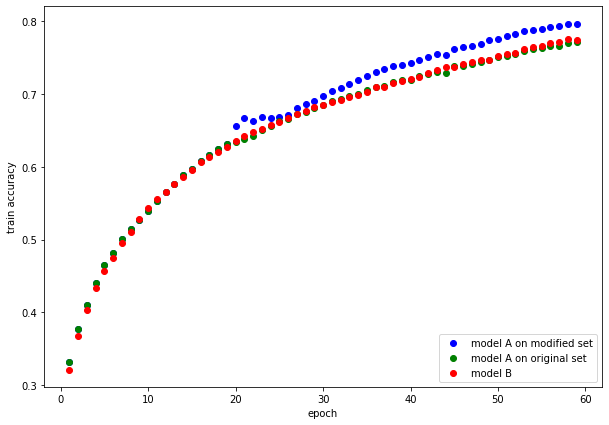

In [ ]:
import numpy as np
eplist= np.arange(nb_epochs)
plt.scatter(eplist[1:], acc_A_global[1:], c ="blue", label = "model A on modified set")
plt.scatter(eplist[1:], acc_A_unmodified_global[1:], c ="green", label = "model A on original set")
plt.scatter(eplist[1:], acc_B_global[1:], c ="red", label = "model B")

plt.xlabel("epoch")
plt.ylabel("train accuracy")
plt.legend(loc='lower right')
plt.show()

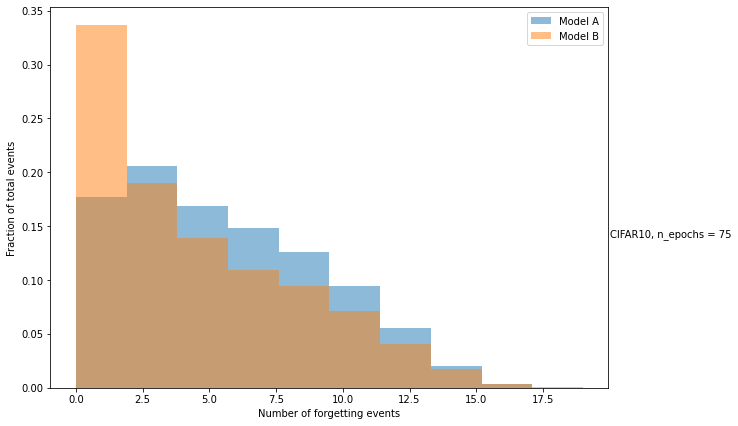

In [ ]:
import numpy as np
cumulative_forgetting_A = torch.sum(forget_matrix_A, 0)
cumulative_forgetting_B = torch.sum(forget_matrix_B, 0)

forgetlen_A = len(torch.flatten(cumulative_forgetting_A))
forgetlen_B = len(torch.flatten(cumulative_forgetting_B))

hist_A = plt.hist(torch.flatten(cumulative_forgetting_A), alpha=0.5, label = "Model A", weights = np.ones(forgetlen_A)/forgetlen_A)
hist_B = plt.hist(torch.flatten(cumulative_forgetting_B), alpha=0.5, label = "Model B", weights = np.ones(forgetlen_B)/forgetlen_B)
plt.ylabel('Fraction of total events')
plt.xlabel('Number of forgetting events')
plt.text(20, .14, r'CIFAR10, n_epochs = 75')
plt.legend(loc='upper right')
plt.show()

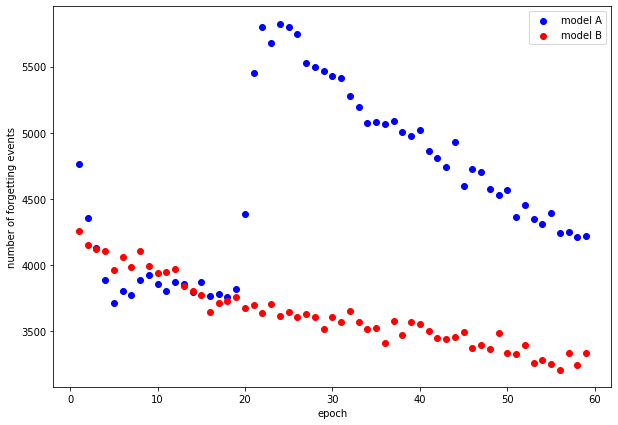

In [ ]:
forget_fcn_epoch_A = list()
forget_fcn_epoch_B = list()

for i in range(nb_epochs):
    forget_fcn_epoch_A.append(torch.sum(torch.flatten(forget_matrix_A[i]),0))
    forget_fcn_epoch_B.append(torch.sum(torch.flatten(forget_matrix_B[i]),0))

import numpy as np
eplist= np.arange(nb_epochs)
plt.scatter(eplist[1:], forget_fcn_epoch_A[1:], c ="blue", label = "model A")
plt.scatter(eplist[1:], forget_fcn_epoch_B[1:], c ="red", label = "model B")
#plt.scatter(eplist[1:], forget_fcn_epoch_B_on_A[1:], c ="green", label = "model B on A")
plt.xlabel("epoch")
plt.ylabel("number of forgetting events")
plt.legend(loc='upper right')
plt.show()

## Measure default 

In [ ]:
#First load models, dataset
#make sure to restart runtime

!git clone https://github.com/facebookresearch/open_lth.git
import sys
sys.path.append('/content/open_lth/')

from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_A = registry.get(model_hparams).cuda()
model_B = registry.get(model_hparams).cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss_A = nn.CrossEntropyLoss()
loss_B =  nn.CrossEntropyLoss() #nn.KLDivLoss() #nn.CrossEntropyLoss()
optimizer_A = optim.SGD(model_A.parameters(), lr=1e-3, momentum=0.9)
optimizer_B = optim.SGD(model_B.parameters(), lr=1e-3, momentum=0.9)

fatal: destination path 'open_lth' already exists and is not an empty directory.
Files already downloaded and verified


In [ ]:
import random
import numpy

nb_epochs = 30
batch_size = 128
#output_vectors = torch.empty(nb_epochs, len(train_set), batch_size, 10)
a_i_A = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_A = torch.zeros(len(train_set),128)

forget_matrix_A = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of A

a_i_B = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_B = torch.zeros(len(train_set),128)

forget_matrix_B = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of A

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification
batch_tracker = 0

model_A.train()
model_B.train()

batch_tracker = 0
forget_thres = 4 #if an example is forgotten more than 5 times, we will add it to the pile
percent_keep = 20 #replace 20%

forget_deck_x = torch.empty((0, 3,32,32)).cuda()
forget_deck_y = torch.empty((0)).cuda()

acc_A_global = list()
acc_B_global = list()

for epoch in range(nb_epochs):
    losses_A = list()
    accuracies_A = list()

    losses_B = list()
    accuracies_B = list()

    for batch in train_set:
        x, y = batch
        x = x.cuda()
        #y = y.cuda()

        
        y_prime = y #save original targets
        x_prime = x #and the original images

        x_mod = x
        y_mod = y

        #replace some of x and y with those from forgotten pile
        #only do this after training for a bit

        l_A = model_A(x_mod)
        l_B = model_B(x_prime)

        
        #check if model A's prediction is correctly classified
        l_A_softmax = softmaxfunc(l_A)

        for k in range(len(l_A_softmax)):
            if torch.argmax(l_A_softmax[k])==y_mod[k]: #if it is, mark as '1'
                a_i_A[batch_tracker, k] = 1
            else:
                a_i_A[batch_tracker, k] = 0 #otherwise 0

            if a_i_A[batch_tracker, k] < a_tilde_i_A[batch_tracker, k]: #and if we find that the marker has decreased, we've forgotten the example
                forget_matrix_A[epoch, batch_tracker, k] += 1
            
            a_tilde_i_A[batch_tracker, k] = a_i_A[batch_tracker, k]

        #check if model B's prediction is correctly classified
        l_B_softmax = softmaxfunc(l_B)

        for k in range(len(l_B_softmax)):
            if torch.argmax(l_B_softmax[k])==y_prime[k]: #if it is, mark as '1'
                a_i_B[batch_tracker, k] = 1
            else:
                a_i_B[batch_tracker, k] = 0 #otherwise 0

            if a_i_B[batch_tracker, k] < a_tilde_i_B[batch_tracker, k]: #and if we find that the marker has decreased, we've forgotten the example
                forget_matrix_B[epoch, batch_tracker, k] += 1

            a_tilde_i_B[batch_tracker, k] = a_i_B[batch_tracker, k]

        #2. compute objective function for A and B
        J_A = loss_A(l_A, y_mod.cuda())

        #2. compute objective function for A and B
        J_B = loss_B(l_B, y_prime.cuda())

        #3. cleaning the gradients
        model_A.zero_grad()
        model_B.zero_grad()



        #4. accumulate partial derivatives
        J_A.backward()
        J_B.backward()

        #5. step in opposite direction
        optimizer_A.step()
        optimizer_B.step()

        #6. monitor loss
        losses_A.append(J_A.item())
        accuracies_A.append(y_mod.eq(l_A.detach().argmax(dim=1).cpu()).float().mean())

        losses_B.append(J_B.item())
        accuracies_B.append(y_prime.eq(l_B.detach().argmax(dim=1).cpu()).float().mean())

        batch_tracker+=1


    print(f"Epoch {epoch +1}, train loss A, B: {torch.tensor(losses_A).mean():.2f} , {torch.tensor(losses_B).mean():.2f} \n")
    print(f"Training accuracy for A, B: {torch.tensor(accuracies_A).mean():.2f} , {torch.tensor(accuracies_B).mean():.2f} \n")

    acc_A_global.append(torch.tensor(accuracies_A).mean())
    acc_B_global.append(torch.tensor(accuracies_B).mean())

    batch_tracker = 0

Epoch 1, train loss A, B: 2.14 , 2.11 

Training accuracy for A, B: 0.21 , 0.23 

Epoch 2, train loss A, B: 1.82 , 1.82 

Training accuracy for A, B: 0.32 , 0.32 

Epoch 3, train loss A, B: 1.70 , 1.73 

Training accuracy for A, B: 0.36 , 0.35 

Epoch 4, train loss A, B: 1.62 , 1.65 

Training accuracy for A, B: 0.39 , 0.38 

Epoch 5, train loss A, B: 1.55 , 1.58 

Training accuracy for A, B: 0.42 , 0.41 

Epoch 6, train loss A, B: 1.49 , 1.52 

Training accuracy for A, B: 0.45 , 0.44 

Epoch 7, train loss A, B: 1.43 , 1.46 

Training accuracy for A, B: 0.47 , 0.46 

Epoch 8, train loss A, B: 1.39 , 1.41 

Training accuracy for A, B: 0.49 , 0.48 

Epoch 9, train loss A, B: 1.34 , 1.37 

Training accuracy for A, B: 0.51 , 0.50 

Epoch 10, train loss A, B: 1.31 , 1.33 

Training accuracy for A, B: 0.52 , 0.51 

Epoch 11, train loss A, B: 1.27 , 1.29 

Training accuracy for A, B: 0.54 , 0.53 

Epoch 12, train loss A, B: 1.24 , 1.26 

Training accuracy for A, B: 0.55 , 0.55 

Epoch 13, tra

KeyboardInterrupt: ignored

In [ ]:
forget_fcn_epoch_A = list()
forget_fcn_epoch_B = list()

for i in range(nb_epochs):
    forget_fcn_epoch_A.append(torch.sum(torch.flatten(forget_matrix_A[i]),0))
    forget_fcn_epoch_B.append(torch.sum(torch.flatten(forget_matrix_B[i]),0))

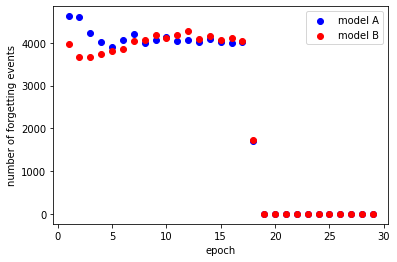

In [ ]:
import numpy as np
eplist= np.arange(nb_epochs)
plt.scatter(eplist[1:], forget_fcn_epoch_A[1:], c ="blue", label = "model A")
plt.scatter(eplist[1:], forget_fcn_epoch_B[1:], c ="red", label = "model B")
#plt.scatter(eplist[1:], forget_fcn_epoch_B_on_A[1:], c ="green", label = "model B on A")
plt.xlabel("epoch")
plt.ylabel("number of forgetting events")
plt.legend(loc='upper right')
plt.show()

# Should we regard forgettable examples as a separate distribution?

Is there a sense in which forgotten examples are learned "correctly" via generalization and stay learned? We could construct a dataset D' consisting only of the most forgotten examples. We can then, over the course of training, measure how well a model trained on the original dataset D (of which D' is a subset) does in evaluating examples in D' at different stages in training (early, middle, late). If we believe that there's a "correct" way to learn these forgotten examples via generalization, then maybe at a later stage in training, the model will basically not fluctuate very much on the classification of these examples. Note that we wouldn't be measuring if these examples are classified correctly, just that if there is a lot of fluctuation in how the model classifies them i.e. is the model mostly settled on what it thinks these examples are, even if it's wrong, or does it basically still oscillate wildly at late times?

Similarly, I wonder if the set of forgettable examples D' really should be thought of an entirely separate distribution and the reason the model has such a hard time learning them is that it's somehow trying to reconcile that all of the elements in this distribution should fit into one of the labels in D. What if we relabeled all examples in D' as a new label or set of labels? If we think our flashcard experiments are hinting at the fact that the model basically memorizes forgettable examples, does this mean that we would wind up with 0 forgetting events for a model trained this way? Moreover, it would be interesting to see what such a model would classify as a forgettable example during testing. Are these the examples that a model trained on the original dataset D would misclassify?

In [ ]:
#Instead of copying and modifying the same general type of code, let's try and create classes that will
#make life a little easier for us. We'll call the first class 'measure' since we want to measure a bunch of different
#things.
#It should have a few different functions. Some of the things we might want to do are:
# -Measure overall forgetting events, given a model, training set, and training time
# -Measure train and test accuracies across iterations

class measure:


# We can make another class to deal with data modifications during training, such as:
# -Modify k% examples in a batch based on criteria like whether they have been forgotten X times
# -Rewind logits based on how much they have been forgotten

class trainingMod:

# Adding noise to the network

Here we train a model and then damage it by adding noise (= 1+ \epsilon) to the weights. Dialing epsilon, we can study the order in which examples are forgotten.

There are many ways to about doing this. Here's one of them:

-- The first step is to determine the examples that are forgotten during training, ranked by how often they are forgotten. We should restrict to the examples that are classified *correctly* at the end of training because we want to see how easily they become forgotten as we damage the network.

-- Then, we add noise to the network and determine which examples are then misclassified. For example suppose the noise is drawn from a gaussian of std dev 0.1 and mean 0. We record which examples are misclassified. Then we clone the original model, and set the noise to 0.2. We again record which examples are misclassified. We go on doing this as the noise is dialed to be O(1).

-- Next, we can construct two ranked lists: the first list is just the rank ordering of how many times examples are forgotten. The next list is the epsilon (noise level) at which that example was incorrectly classified.

-- Finally, we compute the rank correlation between these two. We should average over initializations


In [ ]:
#First load models, dataset
#make sure to restart runtime

!git clone https://github.com/facebookresearch/open_lth.git
import sys
sys.path.append('/content/open_lth/')

from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_A = registry.get(model_hparams).cuda()

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss_A = nn.CrossEntropyLoss()
optimizer_A = optim.SGD(model_A.parameters(), lr=1e-3, momentum=0.9)

#And load the CIFAR10 dataset
train_dataset = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
train_set = DataLoader(train_dataset, batch_size=128, num_workers = 0)

Cloning into 'open_lth'...
remote: Enumerating objects: 112, done.
remote: Total 112 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (112/112), 88.23 KiB | 4.64 MiB/s, done.
Resolving deltas: 100% (18/18), done.



Extracting /cifar-10-python.tar.gz to /


In [ ]:
class measureForget:
    def __init__(self, nb_epochs, num_batches, batch_size ):
        self.forgetStatistics = torch.zeros(nb_epochs, num_batches, batch_size)
        self.correctStatistics = torch.zeros(nb_epochs, num_batches, batch_size)
        self.a_i = torch.zeros(nb_epochs, num_batches, batch_size) #measures if correctly classified or not
        self.softmaxfunc = nn.Softmax(dim=1)
        self.train_batch_tracker = 0
        self.classify_batch_tracker = 0
        self.train_iteration = 0
        self.num_ep = nb_epochs
        self.num_btchs = num_batches
        self.btc_size = batch_size

    #def trackForgettableExamples(self, batch_model_output, labels): #track examples check if examples in a batch were correctly classified
    #before and aren't classified correctly now (where before and now refer to subsequent training iterations)
    def trackForgettableExamples(self, batch_model_output, labels):
        if self.train_iteration < 1:
            pass
        else:
            counter = 0
            for logit in batch_model_output:
                if torch.argmax(logit) == labels[counter]:
                    self.a_i[self.train_iteration, self.train_batch_tracker, counter] = 1
                else:
                    self.a_i[self.train_iteration, self.train_batch_tracker, counter] = 0
            
                if self.a_i[self.train_iteration, self.train_batch_tracker, counter] < self.a_i[self.train_iteration-1, self.train_batch_tracker, counter]:
                    self.forgetStatistics[self.train_iteration, self.train_batch_tracker, counter]+=1
            
                counter+=1
    
    def trackCorrectExamples(self, batch_model_output, labels):
        for k in range(len(batch_model_output)):
            if torch.argmax(batch_model_output[k]) == labels[k]:
                self.correctStatistics[self.train_iteration, self.classify_batch_tracker, k] = 1
    
    def resetCorrectStatistics(self):
        self.correctStatistics = torch.zeros(self.num_ep, self.num_btchs, self.btc_size)

    def incrementTrainBatch(self):
        self.train_batch_tracker+=1
    
    def incrementClassifyBatch(self):
        self.classify_batch_tracker+=1
    
    def getTrainBatchNumber(self):
        return self.train_batch_tracker
    
    def getClassifyBatchNumber(self):
        return self.classify_batch_tracker

    def getTrainIteration(self):
        return self.train_iteration

    def incrementTrainIter(self):
        self.train_iteration+=1
    
    def decrementTrainIter(self):
        self.train_iteration-=1

    def resetTrainBatchTracker(self):
        self.train_batch_tracker=0
    
    def resetClassifyBatchTracker(self):
        self.classify_batch_tracker=0

In [ ]:
import numpy as np
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = [10, 7]

class processMeasurements:
    def __init__(self, forget_msrmt):
        self.forget_stats = forget_msrmt.forgetStatistics
        self.sum_over_ep_Forget = torch.sum(self.forget_stats, 0)
    
    def plotForgetHist(self):
        length = len(torch.flatten(self.sum_over_ep_Forget))
        hist = plt.hist(torch.flatten(self.sum_over_ep_Forget), alpha=0.5, weights = np.ones(length)/length)
        plt.ylabel('Fraction of total events')
        plt.xlabel('Number of forgetting events')
        plt.show()

In [ ]:
class manageForgetDataset:
    def __init__(self, forget_msrmt, forget_thres = 3):
        self.forget_stats = forget_msrmt.forgetStatistics
        self.correct_stats = forget_msrmt.correctStatistics
        self.sum_over_ep_flatten_forget = torch.flatten(torch.sum(self.forget_stats, 0))
        self.forget_thres = forget_thres
        self.trainset = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
        self.forget_mask = list()
        self.forget_mask_correct = list()
        self.batch_size = self.forget_stats[0,0].size()[0] #infer batch size from input
        self.forgotten_correct_stats = list()

    #get a mask of most forgotten examples
    def getForgetMask(self):
        for k in range(len(self.sum_over_ep_flatten_forget)):
            if self.sum_over_ep_flatten_forget[k] >= self.forget_thres:
                self.forget_mask.append(k)
        return self.forget_mask

    #get a mask of most forgotten examples that were classified *correctly* at the end of training
    def getForgetMaskCorrect(self, which_epoch = None):
        if which_epoch == None:
            at_epoch = len(self.correct_stats)
        else:
            at_epoch = which_epoch
    
        correct_flat = torch.flatten(self.correct_stats[at_epoch-1])

        #note that to add the which_epoch functionality correctly
        #I'll have to make sure sum_over_ep_flatten is only summed
        #up to which_epoch... can add that in later **TODO!!**
        #right now it just assumes we mean the last epoch of training

        for k in range(len(correct_flat)):
            if self.sum_over_ep_flatten_forget[k] >= self.forget_thres and correct_flat[k]==1:
                self.forget_mask_correct.append(k)
                self.forgotten_correct_stats.append(torch.IntTensor.item(self.sum_over_ep_flatten_forget[k]))

        return self.forget_mask_correct

    def get_forgotten_dataset_correct(self): #return a mask of those examples that were forgotten AND classified correctly
        #requires having run getForgetMask() first
        train_subset_correct = torch.utils.data.Subset(self.trainset, self.getForgetMaskCorrect())
        return torch.utils.data.DataLoader(train_subset_correct, batch_size=self.batch_size, num_workers = 0)

    #outputs statistics of correct, forgettable examples
    # def get_forgotten_dataset_correct_stats(self):
    #     if self.get_num_forgotten_correct()==0:
    #         raise ValueError("Obtain the mask of forgettable examples first.")
        
    #     correct_flat = torch.flatten(self.correct_stats[len(self.correct_stats)-1])

    #     _forgotten_correct_stats = list()
    #     for k in range(len(correct_flat)):
    #         if correct_flat[k] == 1:
    #             _forgotten_correct_stats.append(self.sum_over_ep_flatten_forget[k])

    #     return _forgotten_correct_stats

    def get_num_forgotten(self):
        if len(self.forget_mask)==0:
            raise ValueError("Obtain the mask of forgettable examples first.")
        return len(self.forget_mask)

    def get_num_forgotten_correct(self, which_epoch = None):
        if which_epoch == None:
            return len(self.forget_mask_correct)
        else:
            return len(self.getForgetMaskCorrect(which_epoch))

    def get_forgotten_dataset(self):
        train_subset = torch.utils.data.Subset(self.trainset, self.getForgetMask())
        return torch.utils.data.DataLoader(train_subset, batch_size=self.batch_size)

In [ ]:
class damageModel:
    def __init__(self, model):
        from foundations import hparams
        from models import registry
        
        model.eval()
        self.model_clones = []
        self.model_state_dict = model.state_dict()
        self.model_hparams = hparams.ModelHparams('cifar_resnet_20', 'kaiming_uniform', 'uniform')

    def addNoise(self, num_points = 200, min_noise = 0., max_noise = 0.1): #returns an array of length num_points, consisting of models increasingly damaged from Gaussian noise with stdev min_noise to max_noise
        from foundations import hparams
        from models import registry

        epsilons = np.linspace(min_noise, max_noise, num_points)
        for i in range(len(epsilons)):
            sys.stdout.write("\r{0}Cloning models...".format("|"*i))
            sys.stdout.flush()
            self.model_clones.append(registry.get(self.model_hparams).cuda())
            self.model_clones[i].load_state_dict(self.model_state_dict)
            

        with torch.no_grad():
            k = 0
            for model in self.model_clones:
                for param in model.parameters():
                    param.multiply_(1+torch.empty(param.size()).cuda().normal_(mean=0,std=epsilons[k]))
                k+=1
            
        for models in self.model_clones:
            models.eval()
        
        return self.model_clones
    
    def getEpsilons(self, num_points = 200, min_noise = 0., max_noise = 0.1):
        return np.linspace(min_noise, max_noise, num_points)

In [ ]:
class postProcess:
    def __init__(self, num_examples = None):
        #self.catalog = torch.zeros(num_examples)
        self.num_examples = num_examples

    #measure at which noise level an example that's classified correctly becomes misclassifed
    #this function just classifies a dataset given a model

    def classifyDataset(self, data_loader, models):
        if self.num_examples==None:
            raise ValueError("Specify the size of the dataset please.")

        num_models = len(models)
        __catalog = torch.zeros(num_models, self.num_examples)

        num_ex_per_batch = list()
        for batch in data_loader:
            num_ex_per_batch.append(len(batch[0]))
        #print(num_ex_per_batch)
        
        modeltrcker = 0
        
        for model in models:
            model.eval()

            btrkcer = 0
            for batch in data_loader:
                x,y = batch
                x=x.cuda()
                with torch.no_grad():
                    l_A = model(x)
                for k in range(len(l_A)):
                    if torch.argmax(l_A[k]) == y.cuda()[k]:
                        #print(f"{modeltrcker}, {k+sum(num_ex_per_batch[0:btrkcer])}")
                        __catalog[modeltrcker, k+sum(num_ex_per_batch[0:btrkcer])] = 1
                btrkcer+=1        
                
            modeltrcker+=1

        return __catalog
    
    #returns a table consisting of {epsilon at which example was forgotten, times it was forgotten}
    def tabulateNoiseForget(self, catalog, epsilonList, forgetStats):
        epsilonForgotten = list()
        timesForgotten = list()

        for k in range(len(catalog[0])): #go through each example
            idx = next((i for i in range(len(catalog[0:,k])) if catalog[0:,k][i] == 0), None)
            if idx != None:
                epsilonForgotten.append(epsilonList[idx])
                timesForgotten.append(forgetStats[k])


        # for k in range(len(catalog[0])): #go through each example
        #     for j in range(len(catalog[0:,k])): #look at how that example was classified amongst the models
        #         if catalog[0:,k][j]==0:
        #             epsilonForgotten.append(epsilonList[j])
        #             timesForgotten.append(forgetStats[k])
        #             continue
        
        return epsilonForgotten, timesForgotten



In [ ]:
import random
import numpy

nb_epochs = 70

model_A_msrments = measureForget(nb_epochs, num_batches = len(train_set), batch_size=128)

acc_A_global = list()

for epoch in range(nb_epochs):
    losses_A = list()
    accuracies_A = list()

    model_A.train()
    for batch in train_set:
        x, y = batch
        x = x.cuda()
        l_A = model_A(x)


        model_A_msrments.trackForgettableExamples(l_A.detach(), y.detach())

        J_A = loss_A(l_A, y.cuda())

        model_A.zero_grad()

        J_A.backward()

        optimizer_A.step()

        losses_A.append(J_A.item())
        accuracies_A.append(y.eq(l_A.detach().argmax(dim=1).cpu()).float().mean())

        model_A_msrments.incrementTrainBatch()
    
    model_A_msrments.resetTrainBatchTracker()

    model_A.eval()
    for batch in train_set:
        x, y = batch
        x = x.cuda()
        with torch.no_grad():
            l_Ap = model_A(x.detach())
        
        model_A_msrments.trackCorrectExamples(l_Ap.detach(), y.detach())
        model_A_msrments.incrementClassifyBatch()
    
    model_A_msrments.resetClassifyBatchTracker()

    model_A_msrments.incrementTrainIter()



    print(f"Epoch {model_A_msrments.getTrainIteration()}, train loss A: {torch.tensor(losses_A).mean():.2f} accuracy A: {torch.tensor(accuracies_A).mean():.2f} \n")

    acc_A_global.append(torch.tensor(accuracies_A).mean())

Epoch 1, train loss A: 2.04 accuracy A: 0.25 

Epoch 2, train loss A: 1.72 accuracy A: 0.36 

Epoch 3, train loss A: 1.58 accuracy A: 0.42 

Epoch 4, train loss A: 1.49 accuracy A: 0.45 

Epoch 5, train loss A: 1.42 accuracy A: 0.48 

Epoch 6, train loss A: 1.35 accuracy A: 0.51 

Epoch 7, train loss A: 1.30 accuracy A: 0.53 

Epoch 8, train loss A: 1.25 accuracy A: 0.55 

Epoch 9, train loss A: 1.20 accuracy A: 0.57 

Epoch 10, train loss A: 1.16 accuracy A: 0.59 

Epoch 11, train loss A: 1.12 accuracy A: 0.60 

Epoch 12, train loss A: 1.08 accuracy A: 0.61 

Epoch 13, train loss A: 1.04 accuracy A: 0.63 

Epoch 14, train loss A: 1.01 accuracy A: 0.64 

Epoch 15, train loss A: 0.99 accuracy A: 0.65 

Epoch 16, train loss A: 0.96 accuracy A: 0.66 

Epoch 17, train loss A: 0.93 accuracy A: 0.67 

Epoch 18, train loss A: 0.91 accuracy A: 0.67 

Epoch 19, train loss A: 0.89 accuracy A: 0.68 

Epoch 20, train loss A: 0.87 accuracy A: 0.69 

Epoch 21, train loss A: 0.85 accuracy A: 0.70 

E

Let's look at the data.

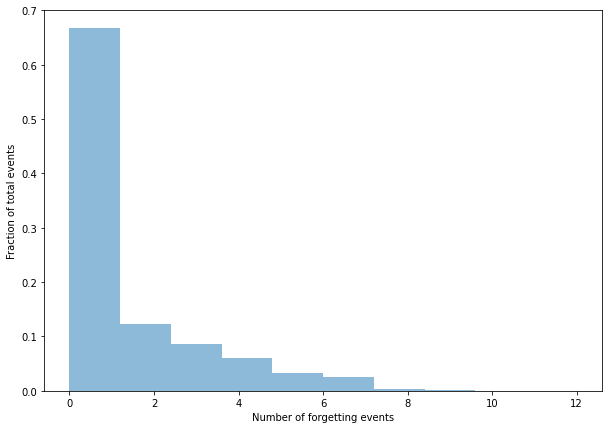

In [ ]:
process_msrments = processMeasurements(model_A_msrments)
process_msrments.plotForgetHist()

Let's check that our subset dataset of correct forgettable examples is, in fact, classified as correct.

In [ ]:
mgdataset = manageForgetDataset(model_A_msrments)
forget_data = mgdataset.get_forgotten_dataset()
forget_data_crt = mgdataset.get_forgotten_dataset_correct()
forget_stats_crt = mgdataset.forgotten_correct_stats

numcorrect = 0
numincorrect = 0

model_A.eval()
for batch in forget_data_crt:
    x,y = batch
    x=x.cuda()
    with torch.no_grad():
        out = model_A(x.detach().clone())
    for k in range(len(out)):
        if torch.argmax(out[k])==y[k]:
            numcorrect+=1
        else:
            numincorrect+=1
        #print(f"{torch.argmax(out[k])}, {y[k]}, {torch.argmax(out[k])==y[k]}")
print(numcorrect/(numcorrect+numincorrect))

Files already downloaded and verified
1.0


In [ ]:
len(forget_stats_crt)

6445

Now add noise to the model

In [ ]:
model_damage = damageModel(model_A)
noisy_clones = model_damage.addNoise()

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Cloning models...

In [ ]:
print(model_damage.getEpsilons())

[0.         0.00050251 0.00100503 0.00150754 0.00201005 0.00251256
 0.00301508 0.00351759 0.0040201  0.00452261 0.00502513 0.00552764
 0.00603015 0.00653266 0.00703518 0.00753769 0.0080402  0.00854271
 0.00904523 0.00954774 0.01005025 0.01055276 0.01105528 0.01155779
 0.0120603  0.01256281 0.01306533 0.01356784 0.01407035 0.01457286
 0.01507538 0.01557789 0.0160804  0.01658291 0.01708543 0.01758794
 0.01809045 0.01859296 0.01909548 0.01959799 0.0201005  0.02060302
 0.02110553 0.02160804 0.02211055 0.02261307 0.02311558 0.02361809
 0.0241206  0.02462312 0.02512563 0.02562814 0.02613065 0.02663317
 0.02713568 0.02763819 0.0281407  0.02864322 0.02914573 0.02964824
 0.03015075 0.03065327 0.03115578 0.03165829 0.0321608  0.03266332
 0.03316583 0.03366834 0.03417085 0.03467337 0.03517588 0.03567839
 0.0361809  0.03668342 0.03718593 0.03768844 0.03819095 0.03869347
 0.03919598 0.03969849 0.04020101 0.04070352 0.04120603 0.04170854
 0.04221106 0.04271357 0.04321608 0.04371859 0.04422111 0.0447

In [ ]:
post_process = postProcess(mgdataset.get_num_forgotten_correct())
classifications = post_process.classifyDataset(forget_data_crt, noisy_clones)
#epsilonForgotten, timesForgotten = post_process.tabulateNoiseForget(classifications, model_damage.getEpsilons(), forget_stats_crt)

In [ ]:
mgdataset.get_num_forgotten_correct()

6445

In [ ]:
epsilonForgotten, timesForgotten = post_process.tabulateNoiseForget(classifications, model_damage.getEpsilons(), forget_stats_crt)

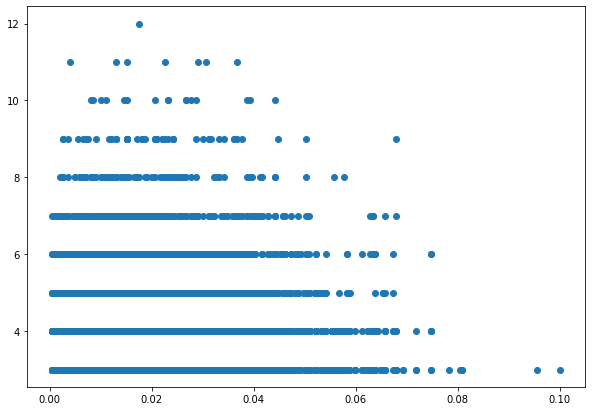

In [ ]:
plt.scatter(epsilonForgotten, timesForgotten)
plt.show()

In [ ]:
#For a given set of epsilon, forget stats, it scans through and determines the
#largest N epsilons for a given # of forgotten events before the example was
#misclassifed

import heapq
def findLargestEpsilon(epsilonForgotten, timesForgotten, largestN):
    largest_value = int(max(timesForgotten))
    smallest_value = int(min(timesForgotten))

    largest_epsilon = torch.zeros(largest_value-smallest_value+1, largestN)
    largest_forgotten = torch.zeros(largest_value-smallest_value+1, largestN)

    for j in range(smallest_value, largest_value+1):
        #largest_forgotten[j-smallest_value] = j
        idx = [i for i in range(len(timesForgotten)) if timesForgotten[i]==j]
        for k in range(len(timesForgotten)):
            largest_forgotten[j-smallest_value, 0:] = torch.tensor([j]*largestN)
            largest_epsilon[j-smallest_value, 0:] = torch.tensor(heapq.nlargest(largestN,[epsilonForgotten[i] for i in idx]))

    return torch.flatten(largest_epsilon), torch.flatten(largest_forgotten)

In [ ]:
maxeps, maxforget = findLargestEpsilon(epsilonForgotten, timesForgotten, 3)

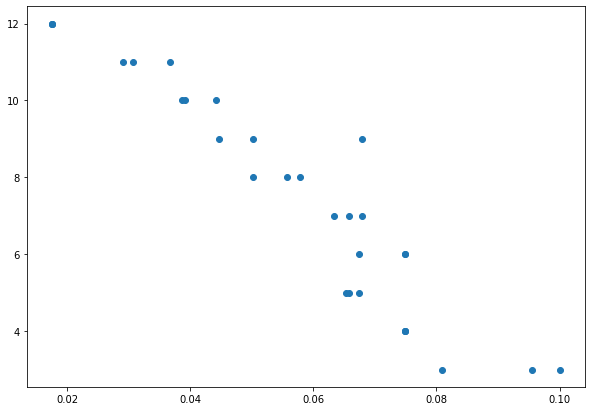

In [ ]:
plt.scatter(maxforget, maxeps)
plt.show()

# Developing experiment + trainer classes

In [ ]:
#default argument: default config file
#it contains the following:
#name of experiment, directory to store files
#no. of models to train num_models
#split into number of jobs num_jobs
#for each job:
#model parameters
#train loop section
#contains which measurements/actions to take (flags) during training
#number of epochs
#dataset to use, dataset params
#default storage directory names for each job, model
#store parameters

#runner will go through config file and create a slurm script, 
#for each job it will generate a command e.g. python forget.py -name = " ", -no models = " ", etc.
#so forget.py should be able to parse all of those parameters

#decorator in training loop @config looks for flags to determine structure of training loop

In [ ]:
!git clone https://github.com/facebookresearch/open_lth.git
import sys
sys.path.append('/content/open_lth/')

Cloning into 'open_lth'...
remote: Enumerating objects: 112, done.
remote: Total 112 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (112/112), 88.23 KiB | 6.30 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
import sys
from pathlib import Path
import configparser
import parser
import numpy
import trainer


class experiment:
    """
    the experiment should call on config.py to get info and create the appropriate directories
    based on the contents of config.ini file. It should then be divided into two steps:
    1. Pretraining (e.g. load model from OpenLTH)
    2. Training (for each job, pass models onto trainer.py which trains it and stores the data)
    """
    
    def __init__(self, config_file = "default_config.ini"):
        #pretraining step:

        #get config files from parser
        self.reader = parser.readConfig(config_file)

        #get the number of models to train
        self.num_models = int(self.reader.exp_info["number of models"])
        self.num_jobs = int(self.reader.exp_info["number of jobs"])

        #number of models to train per job
        if self.num_models % self.num_jobs == 0:
            self.num_train_per_job = numpy.full(self.num_jobs, self.num_models/self.num_jobs).astype(int)
        else:
            self.num_train_per_job = numpy.full(self.num_jobs - 1, int(self.num_models/self.num_jobs)).astype(int)
            self.num_train_per_job = numpy.append(self.num_train_per_job, int(self.num_models % self.num_jobs)) #check this

        #make output directories
        self.reader.mk_directories(self.num_train_per_job)
        
        print(f"Division of jobs (models/job): {self.num_train_per_job}")
        #training step:
        #and for each job, pass models onto trainer
        job_idx = 0
        model_idx = 0
        for job in self.reader.jobs:
            print(f"{job}: {self.reader.jobs[job]}")
            for model_no in range(self.num_train_per_job[job_idx]):
                model = self.reader.get_model(job)
                model_trainer = trainer.train(model, self.reader.exp_info, self.reader.jobs[job], job_idx, model_idx)
                model_trainer.trainLoop(model)
                model_idx+=1
            model_idx=0
            job_idx+=1


class post_experiment:
    pass
    #3. Post-training (do stuff with the data - e.g., from postprocess.py and plotter.py plot statistics of forgetting events)

#     !git clone https://github.com/facebookresearch/open_lth.git
# import sys
# sys.path.append('/content/open_lth/')

# from foundations import hparams
# from models import registry

# model_hparams = hparams.ModelHparams(
#     'cifar_resnet_20',
#     'kaiming_uniform',
#     'uniform'
# )

# model_A = registry.get(model_hparams).cuda()



In [ ]:
exp = experiment()

Experiment info: {'name': 'AddingNoise3', 'storage directory': 'default', 'number of models': 8, 'number of jobs': 2}
Division of jobs (models/job): [4 4]
Job 1: {'model parameters': 'default', 'save models': 'true', 'num epochs': '10', 'save every': '2', 'dataset': 'cifar10', 'dataset params': 'default', 'measure forget': 'true', 'track correct examples': 'true', 'save forget_dataset': 'true', 'storage directory': 'default', 'model noise': 'true', 'noise parameters': 'default', 'save clones': 'true'}
Loading train dataset cifar10... batch size 128
Files already downloaded and verified
Loading train dataset cifar10... batch size 128
Files already downloaded and verified
Loading train dataset cifar10... batch size 128
Files already downloaded and verified
Loading train dataset cifar10... batch size 128
Files already downloaded and verified
Job 2: {'model parameters': 'default', 'save models': 'true', 'num epochs': '10', 'save every': '2', 'dataset': 'cifar10', 'dataset params': 'default

In [ ]:
str(Path(Path().absolute()).parent) + 'open_lth/'

'/open_lth/'

In [ ]:
import configparser

config = configparser.ConfigParser()
config.read("/content/default_config.ini")
sections = config.sections()

In [ ]:
from dataclasses import dataclass
from pathlib import Path
import configparser

@dataclass
class readConfig:
    config_file: str = "default_config.ini"
    
    def __post_init__(self):
        parent_dir_path = Path(Path().absolute()).parent
        sys.path.append(str(parent_dir_path) + 'open_lth/')

        config = configparser.ConfigParser()
        config.read(self.config_file)
        self.sections = config.sections()
        self.exp_info = {}
        self.jobs = {}


        for section in self.sections:
            if section == "Experiment info":
                options = config.options(section)
                self.exp_info[options[0]] = config.get(section, options[0])
                self.exp_info[options[1]] = config.get(section, options[1])
                self.exp_info[options[2]] = int(config.get(section, options[2]))
                self.exp_info[options[3]] = int(config.get(section, options[3]))
            elif str.split(section)[0] == "Job" and str.split(section)[1].isdigit():
                self.jobs[section] = {}
                options = config.options(section)
                #change this to a loop
                for i in range(len(options)):
                    self.jobs[section][str(options[i])] = config.get(section, options[i])
            else:
                raise ValueError("Unknown section command in config file!")
    
        #make directories for experiment, each job and model
        parent_dir_path = Path(Path().absolute()).parent

        #make experiment path
        print(f"Experiment info: {self.exp_info}")
        self.exp_path = str(parent_dir_path) + "/" + self.exp_info["name"]
        Path(self.exp_path).mkdir(parents=True, exist_ok=True)

        #for each job and for each model in the job, make the corresponding directory
    
    def mk_directories(self, model_numbers_per_job):
        for job in self.jobs:
            self.job_path = self.exp_path + "/" + job
            Path(self.job_path).mkdir(parents=True, exist_ok=True)
            for model_idx in model_numbers_per_job:#range(int(self.exp_info["number of models"])):
                self.model_path = self.job_path + "/model" + str(model_idx)
                Path(self.model_path).mkdir(parents=True, exist_ok=True)
            #and if track flags are on, create directories for those
                if self.jobs[job]["measure forget"] == "true" or self.jobs[job]["measure forget"] == "True":
                    Path(self.model_path + "/forgetdata").mkdir(parents=True, exist_ok=True)
                if self.jobs[job]["track correct examples"] == "true" or self.jobs[job]["track correct examples"] == "True":
                    Path(self.model_path + "/correctdata").mkdir(parents=True, exist_ok=True)
        
        #model params
    def get_model(self, job):
        from open_lth.foundations import hparams
        from open_lth.models import registry

        if self.jobs[job]["model parameters"] == "default":
            _model_params = hparams.ModelHparams(
                'cifar_resnet_20',
                'kaiming_uniform',
                'uniform'
            )
            return registry.get(_model_params).cuda()
        else:
            pass #to do for case of other model parameters



In [ ]:
reader = parser.readConfig()

{'name': 'AddingNoise', 'storage directory': 'default', 'number of models': 2, 'number of jobs': 2}


In [ ]:
reader.jobs

{'Job 1': {'dataset': 'cifar10',
  'dataset params': 'default',
  'measure forget': 'true',
  'model noise': 'true',
  'model parameters': 'default',
  'noise parameters': 'default',
  'num epochs': '10',
  'save clones': 'true',
  'save every': '2',
  'save forget_dataset': 'true',
  'save models': 'true',
  'storage directory': 'default',
  'track correct examples': 'true'},
 'Job 2': {'dataset': 'cifar10',
  'dataset params': 'default',
  'measure forget': 'true',
  'model noise': 'true',
  'model parameters': 'default',
  'noise parameters': 'default',
  'num epochs': '10',
  'save clones': 'true',
  'save every': '2',
  'save forget_dataset': 'true',
  'save models': 'true',
  'storage directory': 'default',
  'track correct examples': 'true'}}

In [ ]:
reader.hello()

AttributeError: ignored

In [ ]:
reader.get_model(reader.jobs["Job 1"])

AttributeError: ignored

In [ ]:
for jobs in reader.jobs:
    print(jobs)

Job 1
Job 2


In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt

from measureforget import measureForget

class train:
    def __init__(self, model, exp_info, job_info, job_idx, model_idx): #job_idx, model_idx should be a unique modifier that indexes the job, model
        #structure of directory is eg ../jobs/job1/model1/
        #idx here would be '1'

        #list of datasets that trainer knows about
        parent_dir_path = Path(Path().absolute()).parent

        self.dataset_names = ['cifar10']
        self.num_epochs = int(job_info["num epochs"])
        self.save_every = int(job_info["save every"])
        if exp_info["storage directory"] == "default":
            self.exp_directory = str(parent_dir_path) + exp_info["name"] + "/"
        else:
            self.exp_directory = exp_info["storage directory"]

        if job_info["model parameters"] == "default":
            self.optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
            self.loss = nn.CrossEntropyLoss()
        else:
            pass #to add this functionality, custom loss and optimizer

        if job_info["save models"] == "true" or job_info["save models"] == "True":
            self.save_model = True
        else:
            self.save_model = False

        data_idx = [i for i in range(len(self.dataset_names)) if self.dataset_names[i]==job_info["dataset"]][0]
        self.data_loader = self.getTrainDataset(data_idx)

        if job_info["dataset params"] == "default":
            self.batch_size = 128 #note that this also gets passed to measureForget
        else:
            pass #to add, custom dataset batch size, num workers, etc.

        if job_info["measure forget"] == "true" or job_info["measure forget"] == "True":
            self.forget_flag = True
            self.forget_msrmt = measureForget(self.num_epochs, num_batches = self.batch_size, batch_size=self.batch_size)
        else:
            self.forget_msrmt = None

        if job_info["track correct examples"] == "true" or job_info["track correct examples"] == "True":
            self.track_correct_ex = True
        
        if job_info["storage directory"] == "default":
            self.store_directory = self.exp_directory + "job" + str(job_idx) + "/" + "model" + str(model_idx) + "/"
        else:
            pass #to add..
        
        self.trainLoop(model) #train the model
    
    def getTrainDataset(self, data_idx): #option to change batch size?
        print(f"Loading train dataset {self.getTrainDataset(data_idx)}... batch size {self.batch_size}")
        if data_idx == 0:
            train_dataset = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
            return DataLoader(train_dataset, batch_size=self.batch_size, num_workers = 0)

    def trainLoop(self, model):
        losses = list()
        accuracies = list()
        epochs = list()

        for epoch in range(self.num_epochs):
            batch_loss = list()
            batch_acc = list()

            model.train()
            for batch in self.data_loader:
                x,y = batch
                x=x.cuda()
                logits = model(x)

                if self.forget_flag: #eventually should change forget class to have wrapper instead of these flags.
                    self.forget_msrmt.trackForgettableExamples(logits.detach(), y.detach())

                J = self.loss(logits, y.cuda())
                model.zero_grad()
                J.backward()
                self.optimizer.step()

                batch_loss.append(J.item())
                batch_acc.append(y.eq(logits.detach().argmax(dim=1).cpu()).float().mean())

                if self.forget_flag:
                    self.forget_msrmt.incrementTrainBatch()
            
            if self.forget_flag:
                self.forget_msrmt.resetTrainBatchTracker()
            
            accuracies.append(torch.tensor(batch_acc).mean())
            if self.forget_flag:
                self.forget_msrmt.incrementTrainIter()

            if self.track_correct_ex:
                model.eval()
                for batch in self.data_loader:
                    x, y = batch
                    x = x.cuda()
                    with torch.no_grad():
                        logits_prime = model(x.detach())
        
                    self.forget_msrmt.trackCorrectExamples(logits_prime.detach(), y.detach())
                    self.forget_msrmt.incrementClassifyBatch()
    
                self.forget_msrmt.resetClassifyBatchTracker()

            if (epoch+1) % self.save_every == 0:
                self.save_model(model, epoch, torch.tensor(batch_loss).mean())
                self.save_data()

        if self.forget_flag:
            self.forget_msrmt.resetTrainIter()
        
        model.eval()
        self.clean(model)
    
    def save_model(self, model, epoch, loss):
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, self.store_directory + "epoch=" + str(epoch+1))
        
    def save_data(self):
        if self.forget_flag:
            self.forget_msrmt.saveForget(epoch, self.store_directory)
        if self.track_correct_ex:
            self.forget_msrmt.saveCorrect(epoch, self.store_directory)

        #to add: save accuracies

    def clean(self):
        del model
        del self.forget_msrmt

        #after training, clean caches,..



In [ ]:
!git clone https://github.com/facebookresearch/open_lth.git
import sys
sys.path.append('/content/open_lth/')

from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_A = registry.get(model_hparams).cuda()
model2 = registry.get(model_hparams).cuda()
optimizer = optim.SGD(model_A.parameters(), lr=1e-3, momentum=0.9)

fatal: destination path 'open_lth' already exists and is not an empty directory.


In [ ]:
torch.save({
            'epoch': 1,
            'model_state_dict': model_A.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': .34
            }, "/content/model1epoch="+str(0+1))

In [ ]:
checkpoint = torch.load("/content/model1epoch=1")
model2.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
trainer = train(model_A, reader.exp_info, reader.jobs['Job 1'], 1, 1)

In [ ]:
trainer.store_directory

'/AddingNoise/job1/model1/'

In [ ]:
from dataclasses import dataclass
import numpy as np
@dataclass

class testClass:
    num: int
    othernum = 2

    def __post_init__(self):
        self.myarray = np.arange(self.num)

    def func(self):
        return self.myarray

In [ ]:
mytest = testClass(3)
mytest.func()

array([0, 1, 2])

In [ ]:
mytest.othernum =5

In [ ]:
print(mytest.othernum)

5


In [ ]:
#finally forget.py should just run the config reader and training loop
#for each job

In [ ]:
test={}
test["Job 1"] = {}
test["Job 1"]["num ep"] = 3
test["Job 1"]["save model"] = True

In [ ]:
test

{'Job 1': {'num ep': 3, 'save model': True}}

In [ ]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

In [ ]:
str.split("Job 2")[1].isdigit()

True

In [ ]:
config.options('Experiment info')
config.get('Experiment info', config.options('Experiment info')[2])

'50'

In [ ]:
import argparse
import math

parser = argparse.ArgumentParser(description = "Calculate")
parser.add_argument("-r", "--radius", type=int, metavar='', required=True, help = "R")
parser.add_argument("-H", "--height", type=int, metavar='', required=True, help = "H")
args = parser.parse_args()

def myFunc(radius, height):
    vol = (math.pi)*(radius**2)*(height)

if __name__ == '__main__':
    print(myFunc(args.radius, args.height))

NameError: ignored

In [ ]:
                # self.jobs[section]["save models"] = config.get(section, options[1])
                # self.jobs[section]["num epochs"] = int(config.get(section, options[2]))
                # self.jobs[section]["dataset"] = config.get(section, options[3])
                # self.jobs[section]["measure forget"] = config.get(section, options[4])
                # self.jobs[section]["track correct examples"] = config.get(section, options[5])
                # self.jobs[section]["save forget dataset"] = config.get(section, options[6])
                # self.jobs[section]["job directory"] = config.get(section, options[7])
                # self.jobs[section]["add model noise"] = config.get(section, options[8])
                # self.jobs[section]["noise parameters"] = config.get(section, options[9])
                # self.jobs[section]["save clones"] = config.get(section, options[10])

## More scratch...

ValueError: ignored

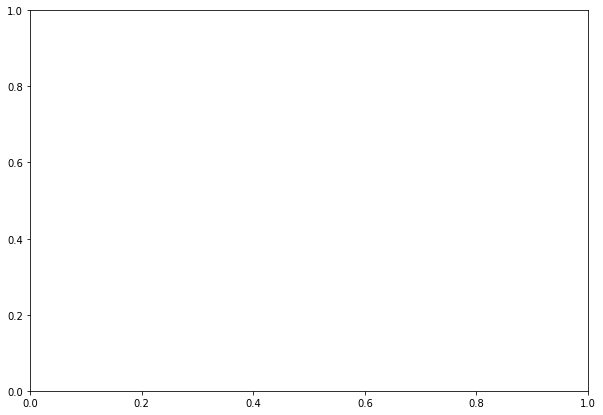

In [ ]:
test1 = [3, 4, 5]
test2 = [[.1,.2,.3], [.3,.2,.1],[.4,.7,.1]]
plt.scatter(test1,test2)
plt.show()

In [ ]:
import heapq
heapq.nlargest(3, epsilonForgotten[i for i in range(len(timesForgotten)) if timesForgotten[i]==4])

SyntaxError: ignored

In [ ]:
import heapq
idx=[i for i in range(len(timesForgotten)) if timesForgotten[i]==4]
torch.tensor(heapq.nlargest(3,[epsilonForgotten[i] for i in idx]))

tensor([0.0749, 0.0749, 0.0749], dtype=torch.float64)

In [ ]:
classifications[0:,2].index(0)

AttributeError: ignored

In [ ]:
len(classifications[0])

1142

## Scratch

In [ ]:
print(model_A_msrments.getTrainIteration())
print(model_A_msrments.correctStatistics[1])

30
tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.]])


In [ ]:
model_A.eval()

print(model_A_msrments.getTrainIteration())
model_A_msrments.incrementTrainIter()
print(model_A_msrments.getTrainIteration())

myownstats = torch.zeros(391, 128)

trker = 0
for batch in train_set:
    x,y = batch
    x=x.cuda()
    with torch.no_grad():
        l_A2 = model_A(x.detach().clone())
    
    for l in range(len(l_A2)):
        if torch.argmax(l_A2[l]) == y[l]:
            myownstats[trker, l] = 1

    model_A_msrments.trackCorrectExamples(l_A2.detach().clone(), y.detach().clone())
    model_A_msrments.incrementClassifyBatch()

model_A_msrments.resetClassifyBatchTracker()

29
28


In [ ]:
model_A_msrments.correctStatistics[29,0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1.])

Let's look at the data.

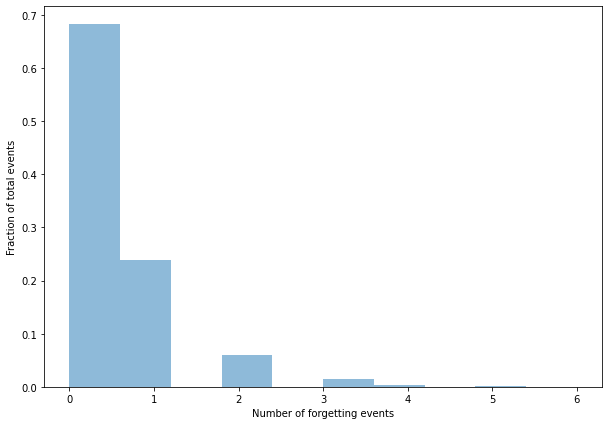

In [ ]:
process_msrments = processMeasurements(model_A_msrments)
process_msrments.plotForgetHist()

In [ ]:
model_A_msrments.correctStatistics[23,1]

tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 1.])

In [ ]:
import numpy as np

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

crt_stats = model_A_msrments.correctStatistics[29]
model_A.eval()
tracker=0
grid=[]

train_set_2 = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
train_set_2_loader = torch.utils.data.DataLoader(train_set_2, batch_size=128, num_workers = 0)

for batch in train_set_2_loader:
    x,y = batch
    x=x.cuda()
    
    with torch.no_grad():
        out = model_A(x.detach().clone())
        
    for k in range(len(out)):
        if crt_stats[tracker, k]==1 and torch.argmax(out[k]) != y[k]:
            grid.append(x.cpu()[k])

    tracker+=1

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


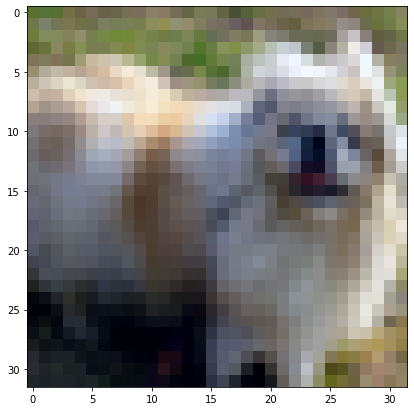

In [ ]:
show(grid[2]*.23+ 0.45)

In [ ]:
model_A_msrments.resetClassifyBatchTracker()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


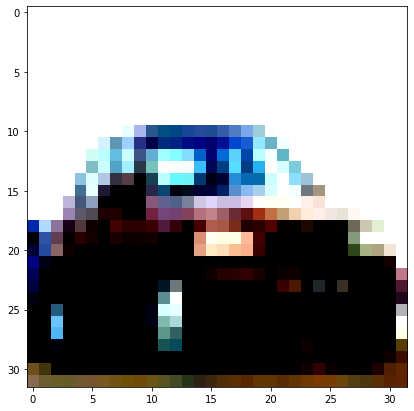

In [ ]:
model_A.eval()
tracker=0
for batch in train_set:
    x,y = batch
    x=x.cuda()
    with torch.no_grad():
        l_Ap = model_A(x.detach().clone())
    if tracker==5:
        show(x[4].cpu())

    model_A_msrments.trackCorrectExamples(l_Ap.detach().clone(), y.detach().clone())
    model_A_msrments.incrementClassifyBatch()
    tracker+=1

model_A_msrments.resetClassifyBatchTracker()

In [ ]:
mgdataset = manageForgetDataset(model_A_msrments)
forget_data = mgdataset.get_forgotten_dataset()
forget_data_crt = mgdataset.get_forgotten_dataset_correct()

numcorrect = 0
numincorrect = 0

model_A.eval()
for batch in forget_data_crt:
    x,y = batch
    x=x.cuda()
    with torch.no_grad():
        out = model_A(x.detach().clone())
    for k in range(len(out)):
        if torch.argmax(out[k])==y[k]:
            numcorrect+=1
        else:
            numincorrect+=1
        #print(f"{torch.argmax(out[k])}, {y[k]}, {torch.argmax(out[k])==y[k]}")
print(numcorrect/(numcorrect+numincorrect))

Files already downloaded and verified
0.6736842105263158


In [ ]:
len(model_A_msrments.correctStatistics)

30

# Debugging package

In [ ]:
!git clone https://github.com/facebookresearch/open_lth.git
!git clone https://github.com/nikhilanand91/Forget.git

Cloning into 'open_lth'...
remote: Enumerating objects: 112, done.
remote: Total 112 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (112/112), 88.23 KiB | 8.02 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Cloning into 'Forget'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 168 (delta 72), reused 140 (delta 44), pack-reused 0
Receiving objects: 100% (168/168), 28.95 KiB | 7.24 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [ ]:
!rm -r "/AddingNoise2/"

rm: cannot remove '/AddingNoise2/': No such file or directory


In [ ]:
rm -r "/content/Forget/"

In [ ]:
rm -r "/content/open_lth/"

rm: cannot remove '/content/open_lth/': No such file or directory


In [ ]:
import sys
import os
sys.path.append(os.getcwd()+"/Forget/open_lth/")

In [ ]:
from Forget.main import experiment

In [ ]:
experiment.run_experiment()

Appending paths: /content/Forget
Current working directory: /content
Experiment info: {'name': 'AddingNoise2', 'storage directory': 'default', 'number of models': 2, 'number of jobs': 2}
Division of jobs (models/job): [1 1]
Starting training...
Job 1: {'model parameters': 'default', 'save models': 'true', 'num epochs': '10', 'save every': '10', 'dataset': 'cifar10', 'dataset params': 'default', 'measure forget': 'true', 'track correct examples': 'true', 'save forget_dataset': 'true', 'storage directory': 'default', 'model noise': 'true', 'noise parameters': 'default', 'save clones': 'true'}
Loading train dataset cifar10... batch size 128
Files already downloaded and verified
Job 2: {'model parameters': 'default', 'save models': 'true', 'num epochs': '10', 'save every': '10', 'dataset': 'cifar10', 'dataset params': 'default', 'measure forget': 'true', 'track correct examples': 'true', 'save forget_dataset': 'true', 'storage directory': 'default', 'model noise': 'true', 'noise parameters

In [ ]:
from Forget.postprocess import postprocess

In [ ]:
procs = postprocess.postProcess()

Current working directory: /content
Experiment info: {'name': 'AddingNoise2', 'storage directory': 'default', 'number of models': 2, 'number of jobs': 2}
Reading from clones files in experiment AddingNoise2...
Model counts: [200, 200]
Clone folders: ['/AddingNoise2/Job 1/model0/clones/', '/AddingNoise2/Job 2/model0/clones/']
Files already downloaded and verified
Classifying dataset... examples/batch: [6]
[[0.013065326633165831, 0.0030150753768844224, 0.01155778894472362, 0.010552763819095479, 0.006030150753768845, 0.018592964824120605]]
Files already downloaded and verified
Classifying dataset... examples/batch: [9]
[[0.013065326633165831, 0.0030150753768844224, 0.01155778894472362, 0.010552763819095479, 0.006030150753768845, 0.018592964824120605], [0.017085427135678392, 0.0030150753768844224, 0.005527638190954774, 0.020100502512562818, 0.029145728643216084, 0.008542713567839196, 0.01256281407035176, 0.022110552763819097, 0.008542713567839196]]


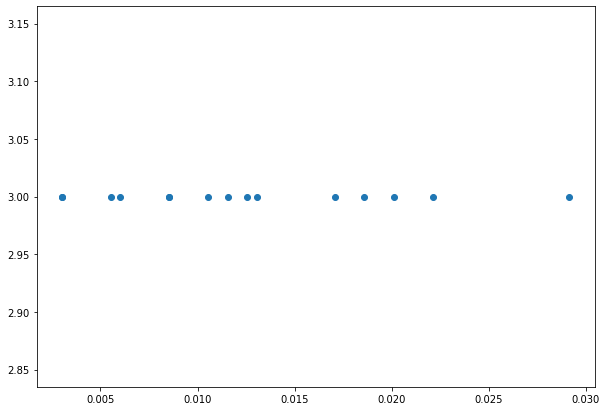

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = [10, 7]

plt.scatter(procs.totalEpsilonsTensor, procs.totalForgottenTensor)
plt.show()

In [ ]:
import torch
t = [[2,3,4],[3,2,1,2]]
[item for sublist in t for item in sublist]

[2, 3, 4, 3, 2, 1, 2]

# Debugging package 2

In [ ]:
!zip -r /content/AddingNoise2.zip /AddingNoise2

  adding: AddingNoise2/ (stored 0%)
  adding: AddingNoise2/Job 1/ (stored 0%)
  adding: AddingNoise2/Job 1/model2/ (stored 0%)
  adding: AddingNoise2/Job 1/model2/epoch=20.pt (deflated 9%)
  adding: AddingNoise2/Job 1/model2/epoch=10.pt (deflated 9%)
  adding: AddingNoise2/Job 1/model2/epoch=30.pt (deflated 9%)
  adding: AddingNoise2/Job 1/model2/forgetdata/ (stored 0%)
  adding: AddingNoise2/Job 1/model2/forgetdata/forgetstatsepoch=10.pt (deflated 100%)
  adding: AddingNoise2/Job 1/model2/forgetdata/forgetstatsepoch=20.pt (deflated 99%)
  adding: AddingNoise2/Job 1/model2/forgetdata/forgetstatsepoch=30.pt (deflated 99%)
  adding: AddingNoise2/Job 1/model2/correctdata/ (stored 0%)
  adding: AddingNoise2/Job 1/model2/correctdata/correctstatsepoch=30.pt (deflated 94%)
  adding: AddingNoise2/Job 1/model2/correctdata/correctstatsepoch=10.pt (deflated 98%)
  adding: AddingNoise2/Job 1/model2/correctdata/correctstatsepoch=20.pt (deflated 96%)
  adding: AddingNoise2/Job 1/model3/ (stored 0%)


In [ ]:
from google.colab import files
files.download("/content/AddingNoise2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Developing post process files

In [ ]:
!git clone https://github.com/facebookresearch/open_lth.git
!git clone https://github.com/nikhilanand91/Forget.git

Cloning into 'open_lth'...
remote: Enumerating objects: 112, done.
remote: Total 112 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (112/112), 88.23 KiB | 2.94 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Cloning into 'Forget'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 142 (delta 59), reused 118 (delta 35), pack-reused 0
Receiving objects: 100% (142/142), 26.27 KiB | 6.57 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [ ]:
!rm -r "/AddingNoise2"
!rm -r "/Forget/"

In [ ]:
!unzip "/AddingNoise2.zip" -d "/"

Archive:  /AddingNoise2.zip
   creating: /AddingNoise2/
   creating: /AddingNoise2/Job 1/
   creating: /AddingNoise2/Job 1/model2/
  inflating: /AddingNoise2/Job 1/model2/epoch=20.pt  
  inflating: /AddingNoise2/Job 1/model2/epoch=10.pt  
  inflating: /AddingNoise2/Job 1/model2/epoch=30.pt  
   creating: /AddingNoise2/Job 1/model2/forgetdata/
  inflating: /AddingNoise2/Job 1/model2/forgetdata/forgetstatsepoch=10.pt  
  inflating: /AddingNoise2/Job 1/model2/forgetdata/forgetstatsepoch=20.pt  
  inflating: /AddingNoise2/Job 1/model2/forgetdata/forgetstatsepoch=30.pt  
   creating: /AddingNoise2/Job 1/model2/correctdata/
  inflating: /AddingNoise2/Job 1/model2/correctdata/correctstatsepoch=30.pt  
  inflating: /AddingNoise2/Job 1/model2/correctdata/correctstatsepoch=10.pt  
  inflating: /AddingNoise2/Job 1/model2/correctdata/correctstatsepoch=20.pt  
   creating: /AddingNoise2/Job 1/model3/
  inflating: /AddingNoise2/Job 1/model3/epoch=20.pt  
  inflating: /AddingNoise2/Job 1/model3/epoch

In [ ]:
#First go through models, assume latest epoch, get forget dataset + mask
#can we save the dataset + mask?

"""
Class for managing forget data. It can go through forget statistics and output
a mask corresponding to the forget threshold. This mask can be used e.g. to obtain a
dataset of forgettable examples. It can also output subset datasets of correctly
classified examples and forgotten + correctly classified examples at the end of
training.
"""

import torch
import os
import sys
sys.path.append(str("/")) #this will need to be fixed later
from Forget.config import parser
from Forget.training import trainer
import os

class createForgetDataset:
    def __init__(self, forget_thres = 3, config_file = "/Forget/config/default_config.ini"):
        #assume latest epoch, go through forgetstats and correctstats
        #for each model, initialize the below variables, create the forget
        #dataset + save into forgetdata/ and also the forget+correct dataset.

        #first set the threshold
        self.forget_thres = forget_thres

        #from the config file, obtain experiment name + number of jobs + number of models
        self.reader = parser.readConfig(config_file)

        self.exp_name = self.reader.exp_info["name"]
        #self.num_jobs = int(self.reader.exp_info["number of jobs"])
        
        self.list_forget_folders = []
        print(f"Reading from output files in experiment {self.exp_name}...")
        for job in self.reader.jobs: #remember to put everything into forgetdata
            job_subdir = ["/"+self.exp_name + "/" + job + "/" + f.name + "/forgetdata/" for f in os.scandir("/" + self.exp_name + "/" + job + "/") if f.is_dir()]
            for dir in job_subdir:
                self.list_forget_folders.append(dir)
            #self.list_correct_folders = [self.exp_name + "/" + job + "/" + f.name + "/correctdata/" for f in os.scandir("/" + self.exp_name + "/" + job + "/") if f.is_dir()]
            self.max_epoch = int(self.reader.jobs[job]["num epochs"])

        """
        should move dataset info to experiment probably
        so this part needs to be systematized better.
        right now we just assume that the dataset is CIFAR10
        but soon we'll want to do other datasets and we should
        just write a class that can fetch a dataset from exp_info.
        Perhaps I should dispense with the "job" system entirely?
        """
        print(f"Fetching dataset...")
        self.trainset = fetch_dataset(data_idx = 0, batch_size = 128)
        
        """
        for each model go through forgetstats and correctstats, upload the masks to the folder.
        This part is undoubtedly clunky... ideally we'd have a directory just associated with the model
        and scan over models, rather than scan over directories.
        Maybe something to improve in the next iteration of this code.
        """
        print(self.list_forget_folders)

        self.getForgetMask_has_run = False
        self.getForgetMaskCorrect_has_run = False
        
        for folder_idx, subfolder in enumerate(self.list_forget_folders):
            self.forget_stats = torch.load(subfolder + "forgetstatsepoch="+str(self.max_epoch)+".pt")
            self.correct_stats = torch.load(subfolder + "correctstatsepoch="+str(self.max_epoch)+".pt")
            self.sum_over_ep_flatten_forget = torch.flatten(torch.sum(self.forget_stats, 0))
            self.forget_mask = list()
            self.forget_mask_correct = list()
            self.batch_size = self.forget_stats[0,0].size()[0] #infer batch size from input
            self.forgotten_correct_stats = list()

            #now compute the masks and save them
            self.getForgetMask(save_directory = subfolder)
            self.getForgetMaskCorrect(save_directory = subfolder)

            #obtain the forgotten dataset that's classified correctly and save it
            self.getFgtDatasetCorrect(save_directory = subfolder)

            #as well as the full forgotten dataset
            self.getFullForgottenDataset(save_directory = subfolder)

            print(f"Number forgotten: {self.get_num_forgotten()}")
            print(f"Number forgotten + correct: {self.get_num_forgotten_correct()}")
            torch.save(torch.tensor([self.get_num_forgotten(), self.get_num_forgotten_correct()]), subfolder + "num_forgotten.pt")


    def getForgetMask(self, save_directory = "/", save = True):
        self.getForgetMask_has_run = True
        for k in range(len(self.sum_over_ep_flatten_forget)):
            if self.sum_over_ep_flatten_forget[k] >= self.forget_thres:
                self.forget_mask.append(k)
        if save:
            torch.save(torch.tensor(self.forget_mask), save_directory + "forgetmask_epoch=" + str(self.max_epoch) + ".pt")

    def getForgetMaskCorrect(self, save_directory = "/", save = True):
        self.getForgetMaskCorrect_has_run = True
        self.correct_flat = torch.flatten(self.correct_stats[self.max_epoch-1])

        for k in range(len(self.correct_flat)):
            if self.sum_over_ep_flatten_forget[k] >= self.forget_thres and self.correct_flat[k]==1:
                self.forget_mask_correct.append(k)
                self.forgotten_correct_stats.append(torch.IntTensor.item(self.sum_over_ep_flatten_forget[k]))

        if save:
            torch.save(torch.tensor(self.forget_mask_correct), save_directory + "forgetmask_correct_epoch=" + str(self.max_epoch) + ".pt")
    
    def getFgtDatasetCorrect(self, save_directory = "/", save = True): #return a mask of those examples that were forgotten AND classified correctly
        """
        this is now redundant since the dataloader should be built up from mask+Dataset
        """
        #requires having run getForgetMask() first
        if not self.getForgetMaskCorrect_has_run:
            raise ValueError("Run getForgetMaskCorrect() first!")

        #self.train_subset_correct = torch.utils.data.Subset(self.trainset, self.forget_mask_correct)

        if save:
            torch.save(self.forget_mask_correct, save_directory + "forgotten_correct_mask_epoch=" + str(self.max_epoch) + ".pt")
            #torch.save(self.train_subset_correct,
            #           save_directory + "forgotten_correct_dataset_epoch=" + str(self.max_epoch) + ".pt")

    def get_num_forgotten(self):
        if len(self.forget_mask)==0:
            raise ValueError("Obtain the mask of forgettable examples first; right now it's empty.")
        else:
            return len(self.forget_mask)

    def get_num_forgotten_correct(self, which_epoch = None):
        if len(self.forget_mask_correct) == 0:
            raise ValueError("Obtain mask of forgettable + correct examples first; right now it's empty.")
        else:
            return len(self.forget_mask_correct)

    def getFullForgottenDataset(self, save_directory = "/", save = True):
        """
        also redundant -- to remove
        """
        if not self.getForgetMask_has_run:
            raise ValueError("Run getForgetMask() first!")
        #self.train_subset = torch.utils.data.Subset(self.trainset, self.forget_mask)
        #self.full_forgotten_dataset = torch.utils.data.DataLoader(self.train_subset, batch_size=self.batch_size)

        if save:
            torch.save(self.trainset, save_directory + "trainset.pt")
            torch.save(self.forget_mask, save_directory + "forgotten_mask_epoch=" + str(self.max_epoch) + ".pt")

from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader

def fetch_dataset(data_idx, batch_size):
    if data_idx == 0:
        train_dataset = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
        return DataLoader(train_dataset, batch_size, num_workers = 0)

In [ ]:
crtForget = createForgetDataset()

Current working directory: /content
Experiment info: {'name': 'AddingNoise2', 'storage directory': 'default', 'number of models': 10, 'number of jobs': 2}
Reading from output files in experiment AddingNoise2...
Fetching dataset...


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /cifar-10-python.tar.gz to /
['/AddingNoise2/Job 1/model2/forgetdata/', '/AddingNoise2/Job 1/model1/forgetdata/', '/AddingNoise2/Job 1/model3/forgetdata/', '/AddingNoise2/Job 1/model0/forgetdata/', '/AddingNoise2/Job 1/model4/forgetdata/', '/AddingNoise2/Job 2/model2/forgetdata/', '/AddingNoise2/Job 2/model1/forgetdata/', '/AddingNoise2/Job 2/model3/forgetdata/', '/AddingNoise2/Job 2/model0/forgetdata/', '/AddingNoise2/Job 2/model4/forgetdata/']
Number forgotten: 537
Number forgotten + correct: 292
Number forgotten: 919
Number forgotten + correct: 495
Number forgotten: 1017
Number forgotten + correct: 588
Number forgotten: 704
Number forgotten + correct: 418
Number forgotten: 582
Number forgotten + correct: 366
Number forgotten: 1332
Number forgotten + correct: 766
Number forgotten: 677
Number forgotten + correct: 418
Number forgotten: 1057
Number forgotten + correct: 659
Number forgotten: 1005
Number forgotten + correct: 517
Number forgotten: 917
Number forgotten + correct:

In [ ]:
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader

def fetch_dataset(data_idx, batch_size):
    if data_idx == 0:
        train_dataset = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
        return DataLoader(train_dataset, batch_size, num_workers = 0)

In [ ]:
import torch
import numpy as np
import os
import sys
sys.path.append("/")
sys.path.append("/Forget/open_lth/")
from Forget.open_lth.foundations import hparams
from Forget.open_lth.models import registry
from pathlib import Path

class damageModel:
    def __init__(self, config_file = "/Forget/config/default_config.ini"):

        self.reader = parser.readConfig(config_file)
        self.exp_name = self.reader.exp_info["name"]
        #self.num_jobs = int(self.reader.exp_info["number of jobs"])
        
        self.list_model_folders = []
        print(f"Reading from output files in experiment {self.exp_name}...")
        for job in self.reader.jobs: #remember to put everything into forgetdata
            job_subdir = ["/"+self.exp_name + "/" + job + "/" + f.name for f in os.scandir("/" + self.exp_name + "/" + job + "/") if f.is_dir()]
            for dir in job_subdir:
                self.list_model_folders.append(dir)
            self.max_epoch = int(self.reader.jobs[job]["num epochs"])

            if self.reader.jobs[job]["model parameters"] == "default":
                self.model_hparams = hparams.ModelHparams('cifar_resnet_20', 'kaiming_uniform', 'uniform')
            else:
                pass #to add in
        
        print(self.list_model_folders)

        for folder in self.list_model_folders:
            self.model = registry.get(self.model_hparams).cuda()
            self.model.load_state_dict(torch.load(folder+"/epoch="+str(self.max_epoch)+".pt")['model_state_dict'])
            self.clones = self.addNoise(self.model)

            save_clone_path = folder + "/clones/"
            Path(save_clone_path).mkdir(parents=True, exist_ok=True)
            for idx, clone in enumerate(self.clones):
                torch.save(clone.state_dict(), save_clone_path + str(idx) + ".pt")

            del self.model
            del self.clones

        
    def addNoise(self, model, num_points = 200, min_noise = 0., max_noise = 0.1):
        """
        returns an array of length num_points, consisting of models increasingly damaged
        from Gaussian noise with stdev min_noise to max_noise
        """
        model.eval()
        self.model_clones = []
        model_state_dict = model.state_dict()

        epsilons = np.linspace(min_noise, max_noise, num_points)
        for i in range(len(epsilons)):
            sys.stdout.write("\r{0}Cloning models...".format("|"*i))
            sys.stdout.flush()
            self.model_clones.append(registry.get(self.model_hparams).cuda())
            self.model_clones[i].load_state_dict(model_state_dict)
            

        with torch.no_grad():
            k = 0
            for model in self.model_clones:
                for param in model.parameters():
                    param.multiply_(1+torch.empty(param.size()).cuda().normal_(mean=0,std=epsilons[k]))
                k+=1
            
        for models in self.model_clones:
            models.eval()
        
        return self.model_clones
        

def getEpsilons(num_points = 200, min_noise = 0., max_noise = 0.1):
        return np.linspace(min_noise, max_noise, num_points)

In [ ]:
dmg = damageModel()

Current working directory: /content
Experiment info: {'name': 'AddingNoise2', 'storage directory': 'default', 'number of models': 10, 'number of jobs': 2}
Reading from output files in experiment AddingNoise2...
['/AddingNoise2/Job 1/model2', '/AddingNoise2/Job 1/model1', '/AddingNoise2/Job 1/model3', '/AddingNoise2/Job 1/model0', '/AddingNoise2/Job 1/model4', '/AddingNoise2/Job 2/model2', '/AddingNoise2/Job 2/model1', '/AddingNoise2/Job 2/model3', '/AddingNoise2/Job 2/model0', '/AddingNoise2/Job 2/model4']
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Cloning models...

In [ ]:
list_subfolders_with_paths = [f.path for f in os.scandir("/AddingNoise2/Job 1/") if f.is_dir()]
print(list_subfolders_with_paths)

['/AddingNoise2/Job 1/model4', '/AddingNoise2/Job 1/model3', '/AddingNoise2/Job 1/model2', '/AddingNoise2/Job 1/model1', '/AddingNoise2/Job 1/model0']


In [ ]:
[ f.name + "/forgetdata/" for f in os.scandir("/" + "AddingNoise2" + "/" + "Job 1" + "/") if f.is_dir()]

['model4/forgetdata/',
 'model3/forgetdata/',
 'model2/forgetdata/',
 'model1/forgetdata/',
 'model0/forgetdata/']

In [ ]:
list_subfolders_with_paths_2 = [f.name + "/forgetdata/" for f in os.scandir("/AddingNoise2/Job 1/") if f.is_dir()]
print(list_subfolders_with_paths_2)

['model4/forgetdata/', 'model3/forgetdata/', 'model2/forgetdata/', 'model1/forgetdata/', 'model0/forgetdata/']


In [ ]:
import os
list_of_files = {}
for (dirpath, dirnames, filenames) in os.walk("/AddingNoise2/Job 1/model0/forgetdata/"):
    for filename in filenames:
        print(filename)

forgetstatsepoch=30.pt
forgetstatsepoch=10.pt
forgetstatsepoch=20.pt


In [ ]:
len(os.listdir('/AddingNoise2/Job 1/model0/clones/'))

200

In [ ]:
import torch
import os, os.path
import sys
sys.path.append("/")
sys.path.append("/Forget/open_lth/")
from Forget.open_lth.foundations import hparams
from Forget.open_lth.models import registry

class postProcess:
    """
    Go through clones/ and for each clone load the forget_correct dataset and classify it.
    """
    def __init__(self, config_file = "/Forget/config/default_config.ini"):
        self.reader = parser.readConfig(config_file)
        self.exp_name = self.reader.exp_info["name"]
        #self.num_jobs = int(self.reader.exp_info["number of jobs"])
        
        self.list_clone_folders = []
        self.list_model_folders = []
        self.num_examples = []
        self.num_forgotten_correct = []
        self.model_counts = []
        print(f"Reading from clones files in experiment {self.exp_name}...")
        for job in self.reader.jobs: #remember to put everything into forgetdata
            clone_subdir = ["/"+self.exp_name + "/" + job + "/" + f.name + "/clones/" for f in os.scandir("/" + self.exp_name + "/" + job + "/") if f.is_dir()]
            model_subdir = ["/"+self.exp_name + "/" + job + "/" + f.name for f in os.scandir("/" + self.exp_name + "/" + job + "/") if f.is_dir()]
            for dir in model_subdir:
                self.num_examples.append(torch.load(dir + "/forgetdata/num_forgotten.pt")[1])
                self.list_model_folders.append(dir)
            
            for dir in clone_subdir:
                self.list_clone_folders.append(dir)
                self.model_counts.append(len(os.listdir(dir)))

            if self.reader.jobs[job]["model parameters"] == "default":
                self.model_hparams = hparams.ModelHparams('cifar_resnet_20', 'kaiming_uniform', 'uniform')
            else:
                pass #to add in
            self.max_epoch = int(self.reader.jobs[job]["num epochs"])
        
        print(f"Model counts: {self.model_counts}")
        print(f"Clone folders: {self.list_clone_folders}")
        #scan and find models

        self.epsilons = getEpsilons()
        self.totalEpsilons = list()
        self.totalForgotten = list()
        
        for clone_idx, clone_dir in enumerate(self.list_clone_folders):
            self.train_set = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])) # torch.load(self.list_model_folders[clone_idx] + "/forgetdata/trainset.pt")
            self.forgot_correct_mask = torch.load(self.list_model_folders[clone_idx] + "/forgetdata/forgetmask_correct_epoch=" + str(self.max_epoch) + ".pt")
            self.forgot_correct_dataset = torch.utils.data.Subset(self.train_set, self.forgot_correct_mask)
            self.forget_correct_dataloader = torch.utils.data.DataLoader(self.forgot_correct_dataset, batch_size = 128) #to change: this call to batch_size
            self.model_list = []
            
            for idx in range(self.model_counts[clone_idx]):
                self.model = registry.get(self.model_hparams).cuda()
                self.model.load_state_dict(torch.load(clone_dir+str(idx)+".pt"))
                self.model_list.append(self.model)

            catalog = self.classifyDataset(self.forget_correct_dataloader, self.model_list, self.num_examples[clone_idx])
            torch.save(catalog, self.list_model_folders[clone_idx]+"/catalog.pt")

            self.forget_correct_stats = torch.load(self.list_model_folders[clone_idx] + "/forgetdata/forgotten_correct_stats_epoch=" + str(self.max_epoch) + ".pt")
            self.epsilonForgotten, self.timesForgotten = self.tabulateNoiseForget(catalog, self.epsilons, self.forget_correct_stats)
            self.totalEpsilons.append(self.epsilonForgotten)
            self.totalForgotten.append(self.timesForgotten)
            torch.save(torch.tensor(self.epsilonForgotten),  self.list_model_folders[clone_idx]+"/epsilonForgotten.pt")
            torch.save(torch.tensor(self.timesForgotten),  self.list_model_folders[clone_idx]+"/timesForgotten.pt")

            self.totalEpsilonsTensor = torch.flatten(torch.Tensor(self.totalEpsilons))
            self.totalForgottenTensor = torch.flatten(torch.Tensor(self.totalForgotten))

            torch.save(self.totalEpsilonsTensor, self.list_model_folders[clone_idx]+"/epsilontotal.pt")
            torch.save(self.totalForgottenTensor, self.list_model_folders[clone_idx]+"/timesforgottentotal.pt")

    #measure at which noise level an example that's classified correctly becomes misclassifed
    #this function just classifies a dataset given a model
    def classifyDataset(self, data_loader, models, num_examples):
        if self.num_examples==None:
            raise ValueError("Specify the size of the dataset please.")

        num_models = len(models)
        __catalog = torch.zeros(num_models, num_examples)

        num_ex_per_batch = list()
        for batch in data_loader:
            num_ex_per_batch.append(len(batch[0]))
        print(f"Classifying dataset... examples/batch: {num_ex_per_batch}")
        
        modeltrcker = 0
        for model in models:
            model.eval()

            btrkcer = 0
            for batch in data_loader:
                x,y = batch
                x=x.cuda()
                with torch.no_grad():
                    l_A = model(x)
                for k in range(len(l_A)):
                    if torch.argmax(l_A[k]) == y.cuda()[k]:
                        #print(f"{modeltrcker}, {k+sum(num_ex_per_batch[0:btrkcer])}")
                        __catalog[modeltrcker, k+sum(num_ex_per_batch[0:btrkcer])] = 1
                btrkcer+=1        
                
            modeltrcker+=1

        return __catalog
    
    #returns a table consisting of {epsilon at which example was forgotten, times it was forgotten}
    def tabulateNoiseForget(self, catalog, epsilonList, forgetCorrectStats):
        epsilonForgotten = list()
        timesForgotten = list()

        for k in range(len(catalog[0])): #go through each example
            idx = next((i for i in range(len(catalog[0:,k])) if catalog[0:,k][i] == 0), None)
            if idx != None:
                epsilonForgotten.append(epsilonList[idx])
                timesForgotten.append(forgetCorrectStats[k])
        
        return epsilonForgotten, timesForgotten

    #For a given set of epsilon, forget stats, it scans through and determines the
    #largest N epsilons for a given # of forgotten events before the example was
    #misclassifed
    def findLargestEpsilon(self, epsilonForgotten, timesForgotten, largestN):
        import heapq
        largest_value = int(max(timesForgotten))
        smallest_value = int(min(timesForgotten))

        largest_epsilon = torch.zeros(largest_value-smallest_value+1, largestN)
        largest_forgotten = torch.zeros(largest_value-smallest_value+1, largestN)

        for j in range(smallest_value, largest_value+1):
            idx = [i for i in range(len(timesForgotten)) if timesForgotten[i]==j]
            for k in range(len(timesForgotten)):
                largest_forgotten[j-smallest_value, 0:] = torch.tensor([j]*largestN)
                largest_epsilon[j-smallest_value, 0:] = torch.tensor(heapq.nlargest(largestN,[epsilonForgotten[i] for i in idx]))

        return torch.flatten(largest_epsilon), torch.flatten(largest_forgotten)

def getEpsilons(num_points = 200, min_noise = 0., max_noise = 0.1):
        return np.linspace(min_noise, max_noise, num_points)

In [ ]:
#mydataloader = torch.utils.data.DataLoader(torch.load("/AddingNoise2/Job 1/model0/forgetdata/forgotten_correct_dataloader_epoch=30.pt"), 128)
train_set = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])) # torch.load("/AddingNoise2/Job 1/model0/forgetdata/trainset.pt")
forgot_correct_mask = torch.load("/AddingNoise2/Job 1/model0/forgetdata/forgetmask_correct_epoch=30.pt")
forgot_correct_dataset = torch.utils.data.Subset(train_set, forgot_correct_mask)
mydataloader = torch.utils.data.DataLoader(forgot_correct_dataset, batch_size = 128) #to change: this call to batch_size

Files already downloaded and verified


In [ ]:
pprocess = postProcess()

Current working directory: /content
Experiment info: {'name': 'AddingNoise2', 'storage directory': 'default', 'number of models': 10, 'number of jobs': 2}
Reading from clones files in experiment AddingNoise2...
Model counts: [200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
Clone folders: ['/AddingNoise2/Job 1/model2/clones/', '/AddingNoise2/Job 1/model1/clones/', '/AddingNoise2/Job 1/model3/clones/', '/AddingNoise2/Job 1/model0/clones/', '/AddingNoise2/Job 1/model4/clones/', '/AddingNoise2/Job 2/model2/clones/', '/AddingNoise2/Job 2/model1/clones/', '/AddingNoise2/Job 2/model3/clones/', '/AddingNoise2/Job 2/model0/clones/', '/AddingNoise2/Job 2/model4/clones/']
Files already downloaded and verified
Classifying dataset... examples/batch: [128, 128, 36]


IndexError: ignored

In [ ]:
next(iter(mydataloader))

[tensor([[[[ 1.2557,  1.2728,  1.3242,  ...,  1.5982,  1.5982,  1.5982],
           [ 1.1872,  1.2214,  1.2728,  ...,  1.5810,  1.5639,  1.5468],
           [ 1.1700,  1.2043,  1.2557,  ...,  1.5982,  1.5810,  1.5639],
           ...,
           [ 0.5536,  0.5536,  0.5536,  ..., -0.4397, -0.1143,  0.0741],
           [ 0.5878,  0.6049,  0.5193,  ...,  0.1254, -0.1143, -0.5596],
           [ 0.4851,  0.4679,  0.3652,  ..., -0.5596, -0.5767, -0.7650]],
 
          [[ 1.2381,  1.2556,  1.3081,  ...,  1.4832,  1.4832,  1.4832],
           [ 1.1681,  1.2031,  1.2556,  ...,  1.4657,  1.4657,  1.4307],
           [ 1.1506,  1.1856,  1.2381,  ...,  1.4832,  1.4657,  1.4482],
           ...,
           [ 0.5203,  0.5203,  0.5203,  ..., -0.6527, -0.3550, -0.1975],
           [ 0.5553,  0.5728,  0.4853,  ..., -0.1099, -0.3025, -0.7227],
           [ 0.4503,  0.4328,  0.3277,  ..., -0.7752, -0.7577, -0.8978]],
 
          [[ 1.4722,  1.4897,  1.5420,  ...,  1.7511,  1.7511,  1.7511],
           [ 

In [ ]:
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader

cifar10 = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
subset=[0,10,20,30,40,50]
dataloader = torch.utils.data.DataLoader(cifar10, batch_size=128, num_workers = 0)

Files already downloaded and verified


In [ ]:
torch.save(dataloader, "mydataloader.pt")
del(dataloader)


FileNotFoundError: ignored

In [ ]:
newdataloader = torch.load("/content/mydataloader.pt")
next(iter(newdataloader))

[tensor([[[[-1.1075, -1.3815, -1.2617,  ...,  0.5878,  0.4851,  0.4166],
           [-1.8439, -2.1179, -1.8097,  ..., -0.0116, -0.0801, -0.0287],
           [-1.6898, -1.8439, -1.2788,  ..., -0.0972, -0.0629, -0.2513],
           ...,
           [ 1.4440,  1.3242,  1.2728,  ...,  0.6221, -1.1589, -1.2103],
           [ 0.9646,  0.8447,  1.0673,  ...,  1.0331, -0.4568, -0.6965],
           [ 0.9132,  0.7591,  0.9474,  ...,  1.5810,  0.4679, -0.0116]],
 
          [[-0.9503, -1.2304, -1.1954,  ...,  0.2752,  0.1527,  0.1352],
           [-1.6856, -2.0357, -1.8957,  ..., -0.4951, -0.5826, -0.5126],
           [-1.6155, -1.9132, -1.5630,  ..., -0.5651, -0.5651, -0.7577],
           ...,
           [ 0.9405,  0.6429,  0.7829,  ...,  0.2927, -1.4930, -1.4405],
           [ 0.3978,  0.1176,  0.4853,  ...,  0.5553, -0.9503, -1.1078],
           [ 0.4853,  0.2227,  0.4503,  ...,  1.1856,  0.0301, -0.4251]],
 
          [[-0.7064, -1.0201, -1.0550,  ...,  0.0779, -0.0267, -0.0092],
           [-

In [ ]:
pprocess = postProcess()

Current working directory: /content
Experiment info: {'name': 'AddingNoise2', 'storage directory': 'default', 'number of models': 10, 'number of jobs': 2}
Reading from clones files in experiment AddingNoise2...
Model counts: [200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
Clone folders: ['/AddingNoise2/Job 1/model2/clones/', '/AddingNoise2/Job 1/model1/clones/', '/AddingNoise2/Job 1/model3/clones/', '/AddingNoise2/Job 1/model0/clones/', '/AddingNoise2/Job 1/model4/clones/', '/AddingNoise2/Job 2/model2/clones/', '/AddingNoise2/Job 2/model1/clones/', '/AddingNoise2/Job 2/model3/clones/', '/AddingNoise2/Job 2/model0/clones/', '/AddingNoise2/Job 2/model4/clones/']
Files already downloaded and verified
Classifying dataset... examples/batch: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

RuntimeError: ignored

In [ ]:
print("hi")

hi


# Trial run

In [ ]:
!rm -r "/AddingNoise2/"

In [ ]:
!rm -r "/content/Forget/"

In [ ]:
from Forget.main import experiment

Appending paths: /content/Forget


In [ ]:
experiment.run_experiment()

Current working directory: /content
Experiment info: {'name': 'AddingNoise2', 'storage directory': 'default', 'number of models': 6, 'number of jobs': 2}
Division of jobs (models/job): [3 3]
Starting training...
Job 1: {'model parameters': 'default', 'save models': 'true', 'num epochs': '30', 'save every': '10', 'dataset': 'cifar10', 'dataset params': 'default', 'measure forget': 'true', 'track correct examples': 'true', 'save forget_dataset': 'true', 'storage directory': 'default', 'model noise': 'true', 'noise parameters': 'default', 'save clones': 'true'}
Loading train dataset cifar10... batch size 128
Files already downloaded and verified
Loading train dataset cifar10... batch size 128
Files already downloaded and verified
Loading train dataset cifar10... batch size 128
Files already downloaded and verified
Job 2: {'model parameters': 'default', 'save models': 'true', 'num epochs': '30', 'save every': '10', 'dataset': 'cifar10', 'dataset params': 'default', 'measure forget': 'true'

KeyError: ignored

# Full run

In [ ]:
!rm -r "/AddingNoise2/"
!rm -r "/content/Forget/"
!rm -r "/content/open_lth/"

In [ ]:
!git clone https://github.com/facebookresearch/open_lth.git
!git clone https://github.com/nikhilanand91/Forget.git

Cloning into 'open_lth'...
remote: Enumerating objects: 112, done.
remote: Total 112 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (112/112), 88.23 KiB | 7.35 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Cloning into 'Forget'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 176 (delta 76), reused 146 (delta 46), pack-reused 0
Receiving objects: 100% (176/176), 29.86 KiB | 9.95 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [ ]:
import sys
import os
sys.path.append(os.getcwd()+"/Forget/open_lth/")

In [ ]:
from Forget.main import experiment

In [ ]:
experiment.run_experiment()

Appending paths: /content/Forget
Current working directory: /content
Experiment info: {'name': 'AddingNoise', 'storage directory': 'default', 'number of models': 10, 'number of jobs': 2}
Division of jobs (models/job): [5 5]
Starting training...
Job 1: {'model parameters': 'default', 'save models': 'true', 'num epochs': '50', 'save every': '10', 'dataset': 'cifar10', 'dataset params': 'default', 'measure forget': 'true', 'track correct examples': 'true', 'save forget_dataset': 'true', 'storage directory': 'default', 'model noise': 'true', 'noise parameters': 'default', 'save clones': 'true'}
Loading train dataset cifar10... batch size 128
Files already downloaded and verified
Loading train dataset cifar10... batch size 128
Files already downloaded and verified
Loading train dataset cifar10... batch size 128
Files already downloaded and verified
Loading train dataset cifar10... batch size 128
Files already downloaded and verified
Loading train dataset cifar10... batch size 128
Files alre

In [ ]:
!zip -r "/AddingNoise.zip" "/AddingNoise"

  adding: AddingNoise/ (stored 0%)
  adding: AddingNoise/Job 2/ (stored 0%)
  adding: AddingNoise/Job 2/model2/ (stored 0%)
  adding: AddingNoise/Job 2/model2/correctdata/ (stored 0%)
  adding: AddingNoise/Job 2/model2/epoch=50.pt (deflated 9%)
  adding: AddingNoise/Job 2/model2/epsilonForgotten.pt (deflated 77%)
  adding: AddingNoise/Job 2/model2/epoch=20.pt (deflated 9%)
  adding: AddingNoise/Job 2/model2/epoch=10.pt (deflated 9%)
  adding: AddingNoise/Job 2/model2/epsilontotal.pt (deflated 65%)
  adding: AddingNoise/Job 2/model2/clones/ (stored 0%)
  adding: AddingNoise/Job 2/model2/clones/159.pt (deflated 10%)
  adding: AddingNoise/Job 2/model2/clones/192.pt (deflated 10%)
  adding: AddingNoise/Job 2/model2/clones/37.pt (deflated 11%)
  adding: AddingNoise/Job 2/model2/clones/67.pt (deflated 11%)
  adding: AddingNoise/Job 2/model2/clones/139.pt (deflated 10%)
  adding: AddingNoise/Job 2/model2/clones/182.pt (deflated 10%)
  adding: AddingNoise/Job 2/model2/clones/161.pt (deflated 1

In [ ]:
from google.colab import files
files.download("/AddingNoise.zip")

In [ ]:
import torch

In [ ]:
totaltimesforgotten = torch.load("/AddingNoise/Job 2/model4/timesforgottentotal.pt")
totalepsilons = torch.load("/AddingNoise/Job 2/model4/epsilontotal.pt")

In [ ]:
timesforgottenmodel4 = torch.load("/AddingNoise/Job 2/model4/timesForgotten.pt")
epsilonsmodel4 = torch.load("/AddingNoise/Job 2/model4/epsilonForgotten.pt")

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = [10, 7]
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

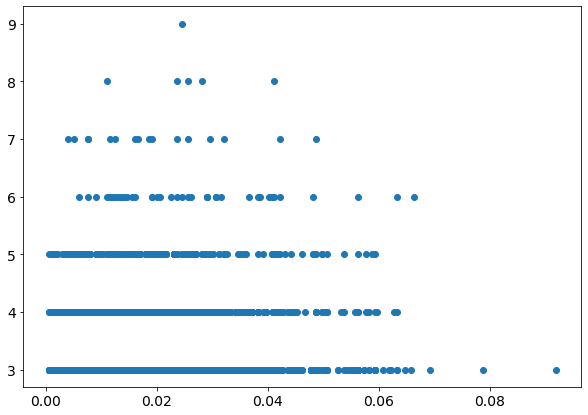

In [ ]:
plt.scatter(epsilonsmodel4, timesforgottenmodel4)
plt.show()

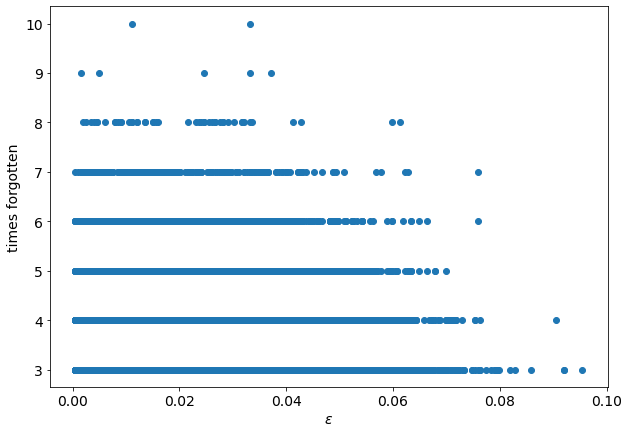

In [ ]:
plt.rcParams['figure.figsize'] = [10, 7]
full_plot = plt.scatter(totalepsilons, totaltimesforgotten)
plt.xlabel('$\epsilon$')
plt.ylabel('times forgotten')
plt.show(full_plot)

In [ ]:
idx_3 = [i for i in range(len(totaltimesforgotten)) if totaltimesforgotten[i]==3]
epsilons_3 = totalepsilons[idx_3]

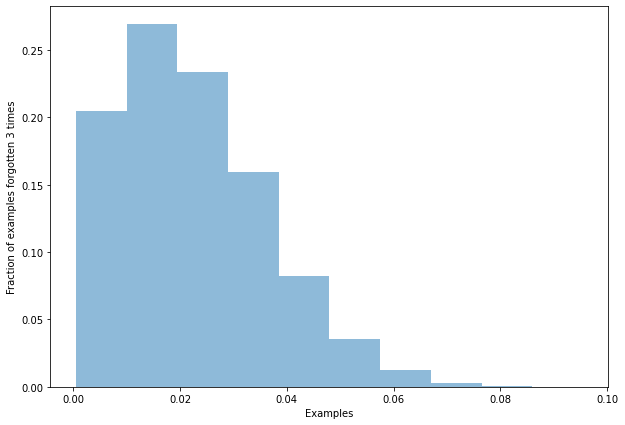

In [ ]:
length = len(epsilons_3)
hist_3 = plt.hist(epsilons_3, alpha=0.5, weights = np.ones(length)/length)
plt.ylabel('Fraction of examples forgotten 3 times')
plt.xlabel('Examples')
plt.show()

In [ ]:
test = np.array([])
np.append(test, 4)

array([4.])

In [ ]:
print(test)

[]


In [ ]:
import numpy as np
epsilon_means = np.array([])
epsilon_errors = np.array([])
for n in range(3,11):
    idx_n = [i for i in range(len(totaltimesforgotten)) if totaltimesforgotten[i]==n]
    epsilons_n = totalepsilons[idx_n]
    epsilon_n_mean = torch.mean(epsilons_n)
    epsilon_means = np.append(epsilon_means, epsilon_n_mean)
    epsilon_n_std = torch.std(epsilons_n)
    epsilon_errors = np.append(epsilon_errors, epsilon_n_std)

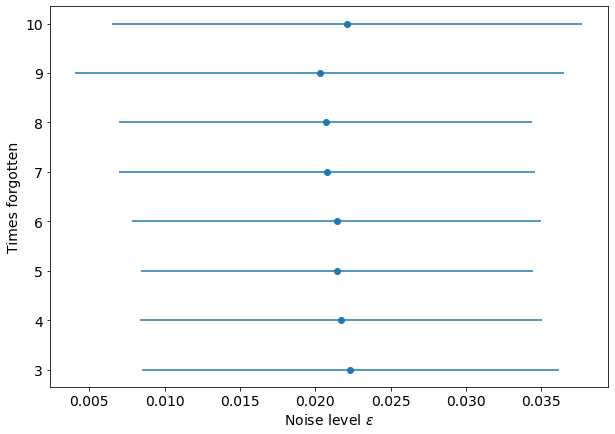

In [ ]:
mean_and_error = plt.errorbar(epsilon_means, np.arange(3,11), yerr=None, xerr = epsilon_errors, linestyle='None', fmt='-o')
plt.xlabel('Noise level $\epsilon$')
plt.ylabel('Times forgotten')
plt.show(mean_and_error)

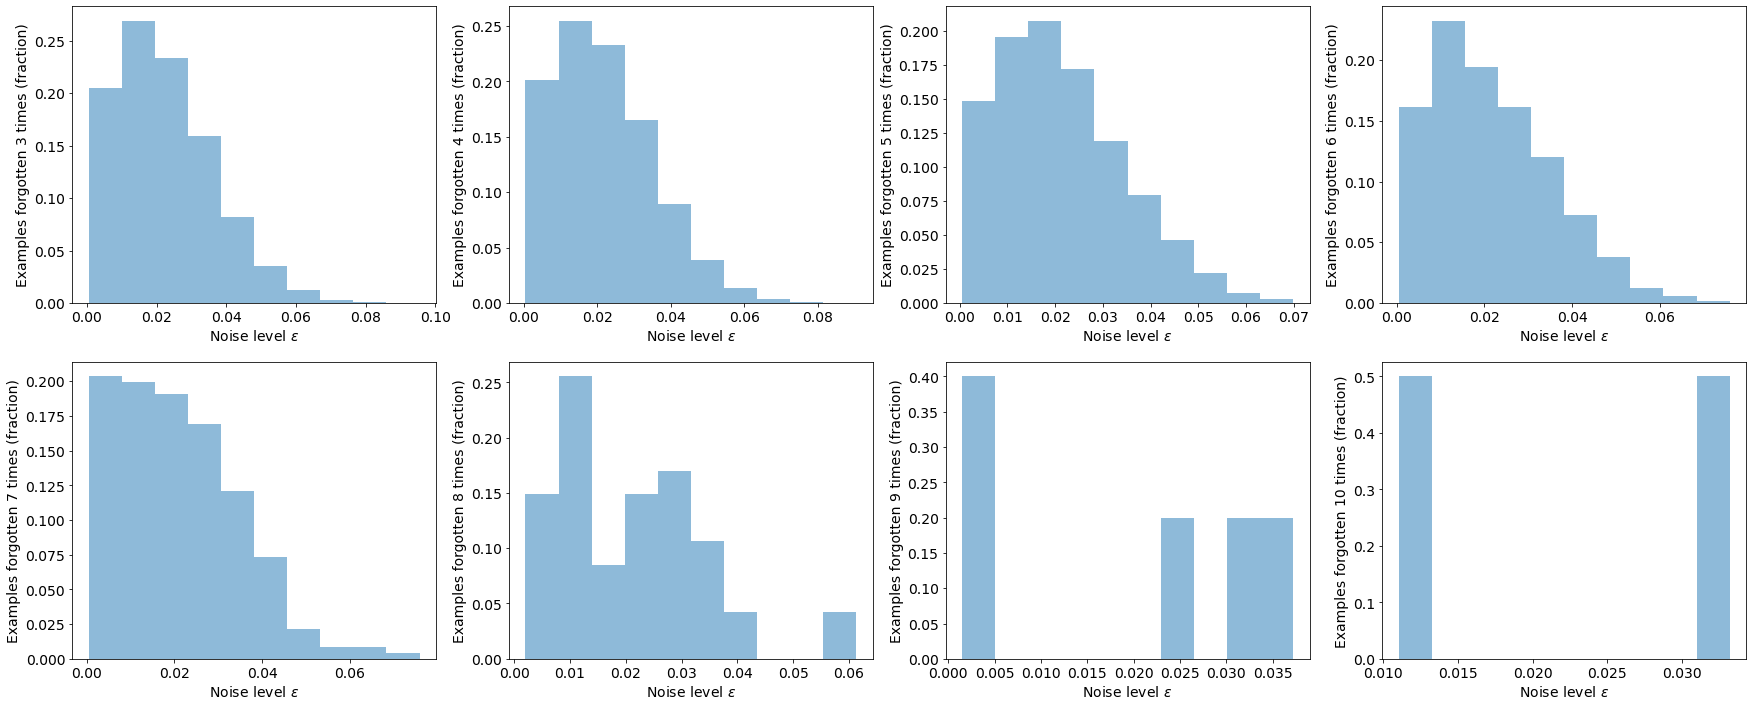

In [ ]:
plt.rcParams['figure.figsize'] = [30, 12]
fig, ax = plt.subplots(nrows=2, ncols=4)
for n in range(3,11):
    idx_n = [i for i in range(len(totaltimesforgotten)) if totaltimesforgotten[i]==n]
    epsilons_n = totalepsilons[idx_n]
    length = len(epsilons_n)
    
    plt.subplot(2,4,n-2)
    plt.hist(epsilons_n, alpha=0.5, weights = np.ones(length)/length)
    plt.ylabel('Examples forgotten {} times (fraction)'.format(n))
    plt.xlabel('Noise level $\epsilon$')
plt.show()

In [ ]:
import scipy.stats as ss

In [ ]:
totalforgotten_ranked = ss.rankdata(totaltimesforgotten)
totalepsilons_ranked = ss.rankdata(totalepsilons)
totalforgotten_ranked_std = np.std(totalforgotten_ranked)
totalepsilons_ranked_std = np.std(totalepsilons_ranked)

In [ ]:
len(totalforgotten_ranked)

28156

In [ ]:
spearmanr, p_value = ss.spearmanr(totalepsilons_ranked, totalforgotten_ranked)

In [ ]:
spearmanr

-0.02336989991509918

In [ ]:
covariance = np.cov(totalepsilons_ranked, totalforgotten_ranked)[0,1]/(totalforgotten_ranked_std*totalepsilons_ranked_std)

In [ ]:
covariance

-0.023370729959493252

# Scratch

In [ ]:
#First load models, dataset
#make sure to restart runtime

!git clone https://github.com/facebookresearch/open_lth.git
import sys
sys.path.append('/content/open_lth/')

from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_A = registry.get(model_hparams).cuda()

# from datasets import registry

# dataset_hparams = hparams.DatasetHparams(
#     'cifar10',
#     128, #batch size,
#     do_not_augment = True
# )

# #set the platform
# from platforms import base
# import platforms.platform
# import platforms.local

# platforms.platform._PLATFORM = platforms.local.Platform()

# train_set = registry.get(
#     dataset_hparams,
#     train = True,
# )

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss_A = nn.CrossEntropyLoss()
optimizer_A = optim.SGD(model_A.parameters(), lr=1e-3, momentum=0.9)


#And load the CIFAR10 dataset
train_dataset = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
train_set = DataLoader(train_dataset, batch_size=128, num_workers = 0)

Cloning into 'open_lth'...
remote: Enumerating objects: 112, done.
remote: Total 112 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (112/112), 88.23 KiB | 6.79 MiB/s, done.
Resolving deltas: 100% (18/18), done.



Extracting /cifar-10-python.tar.gz to /


In [ ]:
class measureForget:
    def __init__(self, nb_epochs, num_batches, batch_size ):
        self.forgetStatistics = torch.zeros(nb_epochs, num_batches, batch_size)
        self.correctStatistics = torch.zeros(nb_epochs, num_batches, batch_size)
        self.a_i = torch.zeros(nb_epochs, num_batches, batch_size) #measures if correctly classified or not
        self.softmaxfunc = nn.Softmax(dim=1)
        self.batch_tracker = 0
        self.train_iteration = 0

    #def trackExamples(self, batch_model_output, labels, model, batchx): #track examples check if examples in a batch were correctly classified before and aren't classified correctly now (where before and now refer to subsequent training iterations)
    def trackExamples(self, batch_model_output, labels):

        #model.eval()
        #with torch.no_grad():
        #    batch_model_output = model(input)

        #print(model_output == batch_model_output)

        #we can only track examples between two iterations of training, so if we're on the first iter, we just record correctStatistics and not forgetStatistics
        #print(f"Iteration {self.train_iteration}")

        counter = 0
        for logit in batch_model_output: #_softmax:
            if torch.argmax(logit) == labels[counter]:
                self.correctStatistics[self.train_iteration, self.batch_tracker, counter] = 1
                #if counter % 10 == 0:
                   # print(f"{torch.argmax(model_output[counter])==labels[counter]} and {torch.argmax(logit) == labels[counter]}")
                    #print(f"{logit} and {labels[counter]}")
                    #print(f"Model output: {model_output[counter]}")

            counter+=1

        if self.train_iteration < 1:
            return 0

        #batch_model_output_softmax = self.softmaxfunc(batch_model_output)
        counter = 0
        for logit in batch_model_output: #_softmax:
            if torch.argmax(logit) == labels[counter]:
                #self.correctStatistics[self.train_iteration, self.batch_tracker, counter] = 1
                self.a_i[self.train_iteration, self.batch_tracker, counter] = 1
            else:
                self.a_i[self.train_iteration, self.batch_tracker, counter] = 0
            
            if self.a_i[self.train_iteration, self.batch_tracker, counter] < self.a_i[self.train_iteration-1, self.batch_tracker, counter]:
                self.forgetStatistics[self.train_iteration, self.batch_tracker, counter]+=1
            
            counter+=1
        
        #model.train()

    def incrementBatch(self):
        self.batch_tracker+=1
    
    def resetBatchTracker(self):
        self.batch_tracker=0
    
    def incrementTrainIter(self):
        self.train_iteration+=1

In [ ]:
class debug_model_output:
    def __init__(self, btchs, bsize):
        self.othertracker = torch.zeros(btchs, bsize)

    def test_fcn(self, model, input, compare):
        out = model(input)
        print(compare==out)
    
    def test_fcn2(self, batchoutput, labels, model, input, btracker):
        ct=0
        model.eval()
        with torch.no_grad():
            out = model(input)
        #print(out==batchoutput)
        for logit in batchoutput:
            if torch.argmax(logit) == labels[ct]:
                self.othertracker[btracker, ct] = 1
                #print(torch.argmax(out[ct])==labels[ct])
            ct+=1
        model.train()
    
    def get_forget(self):
        #print("f!!!")
        databla = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
        msk = list()
        #idx=0
        flat=torch.flatten(self.othertracker)

        for j in range(len(flat)):
            if flat[j]==1:
                msk.append(j)
        trainsubset = torch.utils.data.Subset(databla, msk)
        #print("hello!!!")
        print(msk)

        return torch.utils.data.DataLoader(trainsubset, batch_size=128)

In [ ]:
import numpy as np
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = [10, 7]

class processMeasurements:
    def __init__(self, forget_msrmt):
        self.forget_stats = forget_msrmt.forgetStatistics
        self.sum_over_ep_Forget = torch.sum(self.forget_stats, 0)
    
    def plotForgetHist(self):
        length = len(torch.flatten(self.sum_over_ep_Forget))
        hist = plt.hist(torch.flatten(self.sum_over_ep_Forget), alpha=0.5, weights = np.ones(length)/length)
        plt.ylabel('Fraction of total events')
        plt.xlabel('Number of forgetting events')
        plt.show()

In [ ]:
class manageForgetDataset:
    def __init__(self, forget_msrmt, forget_thres = 4):
        self.forget_stats = forget_msrmt.forgetStatistics
        self.correct_stats = forget_msrmt.correctStatistics
        self.sum_over_ep_flatten_forget = torch.flatten(torch.sum(self.forget_stats, 0))
        self.forget_thres = forget_thres
        self.trainset = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
        self.forget_mask = list()
        self.forget_mask_correct = list()
        self.batch_size = self.forget_stats[0,0].size()[0] #infer batch size from input

    #get a mask of most forgotten examples
    def getForgetMask(self):
        for k in range(len(self.sum_over_ep_flatten_forget)):
            if self.sum_over_ep_flatten_forget[k] >= self.forget_thres:
                self.forget_mask.append(k)
        return self.forget_mask

    #get a mask of most forgotten examples that were classified *correctly* at the end of training
    def getForgetMaskCorrect(self, which_epoch = None):
        if which_epoch == None:
            at_epoch = len(self.correct_stats)
        else:
            at_epoch = which_epoch

    
        correct_flat = torch.flatten(self.correct_stats[at_epoch-1])

        #note that to add this which_epoch functionality correctly
        #I'll have to make sure sum_over_ep_flatten is only summed
        #up to which_epoch... can add that in later **TODO!!**

        for k in range(len(correct_flat)):
            if self.sum_over_ep_flatten_forget[k] >= self.forget_thres and correct_flat[k]==1:
                self.forget_mask_correct.append(k)
        return self.forget_mask_correct

    def getForgetMaskCorrectDebug(self, model, which_epoch = None):
        if which_epoch == None:
            at_epoch = len(self.correct_stats)
        else:
            at_epoch = which_epoch
        
        print(f"{at_epoch-1}")

        correct_flat = torch.flatten(self.correct_stats[at_epoch-1])
        print(f"{len(self.correct_stats[at_epoch-1])}, {self.batch_size}")
        actual_model_correct = torch.zeros(len(self.correct_stats[at_epoch-1]), self.batch_size)
        model.eval()

        counter = 0
        for batch in train_set:
            x,y = batch
            x=x.cuda()
            with torch.no_grad():
                modeloutput = model(x.detach().clone())
            for j in range(len(modeloutput)):
                if torch.argmax(modeloutput[j]) == y[j].cuda():
                    actual_model_correct[counter, j] = 1
            
            counter+=1

        print(actual_model_correct[counter-2]==self.correct_stats[at_epoch-1,389])

        for k in range(len(correct_flat)):
            if self.sum_over_ep_flatten_forget[k] >= self.forget_thres and correct_flat[k]==1:
                self.forget_mask_correct.append(k)
        return self.forget_mask_correct

    def get_forgotten_dataset_correct(self): #return a mask of those examples that were forgotten AND classified correctly
        #requires having run getForgetMask() first
        train_subset_correct = torch.utils.data.Subset(self.trainset, self.getForgetMaskCorrect())
        return torch.utils.data.DataLoader(train_subset_correct, batch_size=self.batch_size, )

    def get_forgotten_dataset_correct_debg(self): #return a mask of those examples that were forgotten AND classified correctly
        #requires having run getForgetMask() first
        #train_subset_correct = torch.utils.data.Subset(self.trainset, self.getForgetMaskCorrect())
        return torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size)

    def get_num_forgotten(self):
        return len(self.forget_mask)

    def get_num_forgotten_correct(self, which_epoch = None):
        if which_epoch == None:
            return len(self.forget_mask_correct)
        else:
            return len(self.getForgetMaskCorrect(which_epoch))

    def get_forgotten_dataset(self):
        train_subset = torch.utils.data.Subset(self.trainset, self.getForgetMask())
        return torch.utils.data.DataLoader(train_subset, batch_size=self.batch_size)

In [ ]:
import random
import numpy

nb_epochs = 20

model_A_msrments = measureForget(nb_epochs, num_batches = len(train_set), batch_size=128)

model_A.train()

acc_A_global = list()

output_vectors = {}
output_vectors_eval = {}
# output_vectors_eval_2 = {}
# output_vectors_eval_3 = {}

for epoch in range(nb_epochs):
    losses_A = list()
    accuracies_A = list()

    losses_B = list()
    accuracies_B = list()
    btrker =0 
    for batch in train_set:

        model_A.train()
        x, y = batch
        x = x.cuda()
        l_A = model_A(x)

        with torch.no_grad():
            output_vectors[epoch,btrker] = l_A.detach().clone()
        

        #measureForget()
        #model_A.eval()
        #with torch.no_grad():
        #    l_A = model_A(x)
        #model_A.train()

        #sdict = model_A.state_dict()
        #model2.load_state_dict(sdict)

       

        #model_A.eval()
        #with torch.no_grad():
        #    l_Ap = model_A(x.detach().clone())
        #print(l_A==l_Ap)
        #model_A.train()

        

        
        #l_Ap = model2(x.detach().clone())
        #print(l_Ap == l_A)

        #model_A_msrments.trackExamples(l_A.detach().clone(), y.detach().clone(), model2, x.detach().clone())


        J_A = loss_A(l_A, y.cuda())

        model_A.zero_grad()

        J_A.backward()

        optimizer_A.step()

        model_A.eval()
        with torch.no_grad():
            l_Ap = model_A(x.detach().clone())
            #l_Ap_2 = model_A(x.detach().clone())
            output_vectors_eval[epoch,btrker] = l_Ap.detach().clone()
            #output_vectors_eval_2[epoch,btrker] = l_Ap_2.detach().clone()
            model_A_msrments.trackExamples(l_Ap.detach().clone(), y.detach().clone())

            #l_Ap_3 = model_A(x.detach().clone())
            #output_vectors_eval_3[epoch,btrker] = l_Ap_3.detach().clone()

            
        #dbg.test_fcn2(l_Ap.detach().clone(), y.detach().clone(), model_A, x.detach().clone(), btrker)
        

        losses_A.append(J_A.item())
        accuracies_A.append(y.eq(l_Ap.detach().argmax(dim=1).cpu()).float().mean())

        model_A_msrments.incrementBatch()
        btrker+=1
    
    model_A_msrments.incrementTrainIter()
    model_A_msrments.resetBatchTracker()

    print(f"Epoch {epoch +1}, train loss A: {torch.tensor(losses_A).mean():.2f} accuracy A: {torch.tensor(accuracies_A).mean():.2f} \n")

    acc_A_global.append(torch.tensor(accuracies_A).mean())

model_A.eval()

Epoch 1, train loss A: 2.03 accuracy A: 0.26 

Epoch 2, train loss A: 1.76 accuracy A: 0.35 

Epoch 3, train loss A: 1.66 accuracy A: 0.38 

Epoch 4, train loss A: 1.58 accuracy A: 0.41 

Epoch 5, train loss A: 1.51 accuracy A: 0.44 

Epoch 6, train loss A: 1.44 accuracy A: 0.47 

Epoch 7, train loss A: 1.37 accuracy A: 0.50 

Epoch 8, train loss A: 1.31 accuracy A: 0.52 

Epoch 9, train loss A: 1.26 accuracy A: 0.54 

Epoch 10, train loss A: 1.21 accuracy A: 0.56 

Epoch 11, train loss A: 1.16 accuracy A: 0.58 

Epoch 12, train loss A: 1.13 accuracy A: 0.59 

Epoch 13, train loss A: 1.09 accuracy A: 0.60 

Epoch 14, train loss A: 1.06 accuracy A: 0.62 

Epoch 15, train loss A: 1.04 accuracy A: 0.63 

Epoch 16, train loss A: 1.01 accuracy A: 0.64 

Epoch 17, train loss A: 0.98 accuracy A: 0.65 

Epoch 18, train loss A: 0.96 accuracy A: 0.65 

Epoch 19, train loss A: 0.94 accuracy A: 0.66 

Epoch 20, train loss A: 0.92 accuracy A: 0.67 



Model(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
print(output_vectors_eval[19,20][29])
print(output_vectors_eval_2[19,20][29])
print(output_vectors_eval_3[19,20][29])

tensor([-1.1196, -1.9133,  2.7493,  2.8982,  1.0910,  0.8220,  0.8172,  0.0238,
        -0.2683, -2.8538], device='cuda:0')
tensor([-1.1196, -1.9133,  2.7493,  2.8982,  1.0910,  0.8220,  0.8172,  0.0238,
        -0.2683, -2.8538], device='cuda:0')
tensor([-1.1196, -1.9133,  2.7493,  2.8982,  1.0910,  0.8220,  0.8172,  0.0238,
        -0.2683, -2.8538], device='cuda:0')


In [ ]:
model_A.eval()
temp=model_A(x)
print(temp[0])
print(output_vectors_eval_3[19,390][0])

tensor([-1.7102, -3.7843,  2.0747,  2.9617,  0.2061,  3.6672, -2.1881,  2.2155,
        -1.1992, -1.2647], device='cuda:0', grad_fn=<SelectBackward>)
tensor([-1.7102, -3.7843,  2.0747,  2.9617,  0.2061,  3.6672, -2.1881,  2.2155,
        -1.1992, -1.2647], device='cuda:0')


In [ ]:
model_A.eval()
z,y=next(iter(train_set))
z=z.cuda()
with torch.no_grad():
    temp=model_A(z.detach().clone())
print(temp[2])
print(output_vectors_eval_3[19,0][0])

tensor([ 0.9210,  1.2676, -0.8179, -0.5290, -1.3860, -2.1118, -1.8039,  0.1976,
         0.4948,  5.6216], device='cuda:0')
tensor([-2.7335, -3.9993,  2.2827,  4.0484,  2.3747,  3.5750,  3.5971,  0.7792,
        -3.7413, -3.6752], device='cuda:0')


In [ ]:
for g in range(len(temp)):
    for k in range(len(output_vectors_eval_3[19,0])):
        for b in range(390):
            if torch.equal(temp[g], output_vectors_eval_3[19,b][k]):
                print(f"{g}, {k}")

In [ ]:
#new_train_set = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
#from datasets import cifar10
#new_train_set_loader = cifar10.DataLoader(new_train_set, batch_size=128, num_workers=0)

#torch.use_deterministic_algorithms(True)
#CUBLAS_WORKSPACE_CONFIG=:16:8

newoutput={}
btrker=0
model_A.eval()
for batch in train_set:
    x,y=batch
    x=x.cuda()
    with torch.no_grad():
        out_p = model_A(x.detach().clone())
    newoutput[btrker] = out_p.clone().detach()
    btrker+=1
print(newoutput[20][29])

RuntimeError: ignored

In [ ]:
print(newoutput[20][29])
print(output_vectors_eval_3[19,20][29])
print(newoutput[289][10])
print(output_vectors_eval_3[19,289][10])


tensor([-0.9626, -2.2677,  3.2166,  2.0658,  0.4167,  0.4271,  0.8047,  1.1838,
        -3.1591, -2.9609])
tensor([-1.1592, -1.9115,  3.2783,  2.3988, -0.0995,  0.7546,  0.3694,  0.8890,
        -3.1869, -2.1761], device='cuda:0')
tensor([ 1.8628,  2.1368, -0.9158,  0.0632, -0.4610, -1.4266, -3.1303, -0.5730,
         4.7156,  1.6983])
tensor([ 1.5665,  4.0622, -0.4723, -0.0706, -1.5701, -1.4448, -3.6055, -1.1219,
         4.3932,  2.6519], device='cuda:0')


In [ ]:
new_train_set = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
from datasets import cifar10
new_train_set_loader = cifar10.DataLoader(new_train_set, batch_size=128, num_workers=0)
newoutput_2={}
btrker=0
model_A.eval()
for batch in new_train_set_loader:
    x,y=batch
    x=x.cuda()
    with torch.no_grad():
        out_p=model_A(x.detach().clone())
    newoutput_2[btrker] = out_p.clone().detach()
    btrker+=1
print(newoutput_2[20][29])

Files already downloaded and verified


RuntimeError: ignored

In [ ]:
newoutput[20][29]

tensor([-1.2112, -1.7018,  3.1729,  1.7978,  1.2208, -0.4915,  1.2666, -0.7934,
        -1.4237, -3.1683], device='cuda:0')

In [ ]:
from platforms.platform import get_platform
get_platform().num_workers

0

In [ ]:
model_A.eval()
actual_correct_stats = torch.zeros(80)
for batch in train_set:
    x,y = batch
    x=x.cuda()
    with torch.no_grad():
        out = model_A(x.detach().clone())
        
num = 0
for thing in out:
    if(torch.argmax(thing)==y[num].cuda()):
        actual_correct_stats[num] = 1
    num+=1

#print(out==l_Ap)
print(model_A_msrments.correctStatistics[19,390,0:80])
print(actual_correct_stats)
print(model_A_msrments.correctStatistics[19,390,0:80]-actual_correct_stats)

with torch.no_grad():
    last_out = model_A(x.detach().clone())
for k in range(len(actual_correct_stats)):
    if actual_correct_stats[k]==1:
        print(torch.argmax(last_out[k])==y[k].cuda())

tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 0.])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [ ]:
mgdataset = manageForgetDataset(model_A_msrments)
forget_data = mgdataset.get_forgotten_dataset()
forget_data_crt = mgdataset.get_forgotten_dataset_correct()

model_A.eval()
for batch in forget_data_crt:
    x,y = batch
    x=x.cuda()
    with torch.no_grad():
        out = model_A(x.detach().clone())
        
with torch.no_grad():
    last_out = model_A(x.detach().clone())
for k in range(len(last_out)):
    print(torch.argmax(last_out[k])==y[k].cuda())

Files already downloaded and verified
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([8, 9, 1, 2])


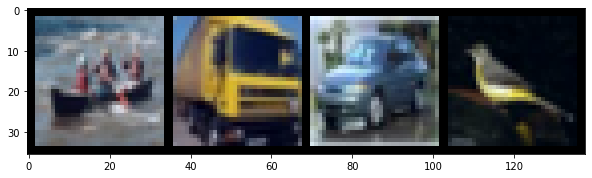

In [ ]:
import numpy as np

gridlist2 = [x[0]*.23 + 0.45,x[1]*0.23 + 0.45,(x[2]*.23)+0.45,(x[3]*.23)+0.45]
gridimgs2 = utils.make_grid(gridlist2)
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(gridimgs2.cpu())
print(y[0:4])

27, 85, 8, output: tensor([-0.8794, -1.3386, -0.1487,  0.3173, -0.7304,  0.1706,  0.6876, -1.1127,
         0.5433,  0.2617], device='cuda:0')
False


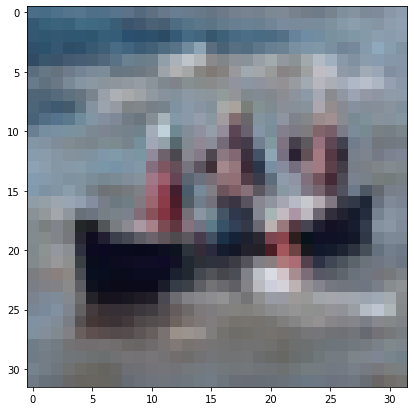

In [ ]:
#let's try to find these examples in the train_set and see if they are misclassified there.
catpic = x[0]
count=0
model_A.eval()
for batch in train_set:
    x,y = batch
    x=x.cuda()
    with torch.no_grad():
        output=model_A(x.detach().clone())
    for j in range(len(x)):
        xflat = torch.flatten(x[j].detach().clone())
        if torch.equal(x[j],catpic):
            show(x.cpu()[j]*.23 + 0.45)
            print(f"{count}, {j}, {y[j]}, output: {output[j]}")
            print(f"{torch.argmax(output[j])==y[j]}")
            
    count+=1

In [ ]:
print(output_vectors[19, 27][85])
print(output_vectors_eval[19, 27][85])

tensor([-0.1006, -0.8767, -0.4181,  0.0194, -1.0642, -0.6152, -0.0719, -1.2814,
         1.7363,  1.0252], device='cuda:0')
tensor([-0.7893, -1.6244, -0.2600,  0.3854, -0.7042,  0.2815,  0.0265, -0.6295,
         0.6979,  0.6053], device='cuda:0')


In [ ]:
for batch in train_set:
    x,y=batch
    x=x.cuda()
    with torch.no_grad():
        out=model_A(x.detach().clone())
    for k in range(len(x)):
        if torch.equal(x[k],catpic):
            print(out[k])

tensor([-2.8573, -4.0407,  1.6254,  3.0421,  1.9822,  1.9157,  3.3206, -0.8332,
        -3.5770, -3.6559], device='cuda:0')


In [ ]:
print(model_A_msrments.correctStatistics[19,50,43])

tensor(1.)


In [ ]:
print(len(model_A_msrments.correctStatistics))

20


In [ ]:
print(model_A_msrments.correctStatistics[19,0:2])
print(torch.flatten(model_A_msrments.correctStatistics[19,0:2]))

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
         0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
         1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
         1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
         1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
         0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
         1., 1.],
        [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
         1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
         1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
         1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
         1

In [ ]:
mgdataset = manageForgetDataset(model_A_msrments)
maskdebug = mgdataset.getForgetMaskCorrectDebug(model_A)

Files already downloaded and verified
19
391, 128
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,

In [ ]:
dbg_train = mgdataset.get_forgotten_dataset_correct_debg()

In [ ]:
model_A.eval()

for batch in dbg_train:
    x,y = batch
    x=x.cuda()
    with torch.no_grad():
        dbg_output = model_A(x)

for batch in train_set:
    x,y = batch
    x=x.cuda()
    with torch.no_grad():
        train_output = model_A(x)

print(dbg_output-train_output)
#print(train_output)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


In [ ]:
mgdataset = manageForgetDataset(model_A_msrments)
forget_data = mgdataset.get_forgotten_dataset()
forget_data_crt = mgdataset.get_forgotten_dataset_correct()
#forget_data2 = dbg.get_forget() #not working...

Files already downloaded and verified


In [ ]:
dbg.get_forget()

Files already downloaded and verified
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


In [ ]:
count2=0 #count the number in forget_data2
for j in forget_data2:
    bc,lab = j
    for thing in bc:
        count2+=1
print(count2)

128


In [ ]:
mgdataset.get_num_forgotten_correct()

19

In [ ]:
#mgdataset.getForgetMaskCorrect()

In [ ]:
#model2.eval()
model_A.eval()
testclass = torch.zeros(mgdataset.get_num_forgotten_correct())
#testclass2 = torch.zeros(mgdataset.get_num_forgotten_correct())


count = 0
for b in forget_data_crt:
    x,y = b
    with torch.no_grad():
        out = model_A(x.cuda())
        #out2 = model2(x.cuda())
    for i in range(len(out)):
        if torch.argmax(out[i]) == y.cuda()[i]:
            testclass[i]=1
        #if torch.argmax(out2[i]) == y.cuda()[i]:
        #    testclass2[i]=1
        #else:
        #    print(f"{torch.argmax(out[i])},{y[i]}")
        count+=1

print(count)
print(testclass)
#print(testclass2)
#print(testclass-testclass2)

12
tensor([1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.])


Now we add noise, but first let's record the ordering of correctly classified examples from the train set. Our noise will be drawn from a normal distribution with mean 0 and std dv epsilon. Before adding noise we should clone the model 100 times corresponding to different epsilons.

In [ ]:
class damageModel:
    def __init__(self, model):
        from foundations import hparams
        from models import registry
        
        model.eval()
        #self.forget_msrmt = forget_msrmt
        self.model_clones = []
        self.model_state_dict = model.state_dict()
        self.model_hparams = hparams.ModelHparams('cifar_resnet_20', 'kaiming_uniform', 'uniform')

    def addNoise(self, num_points = 30, min_noise = 0., max_noise = 1.): #returns an array of length num_points, consisting of models increasingly damaged from Gaussian noise with stdev min_noise to max_noise
        from foundations import hparams
        from models import registry

        epsilons = np.linspace(min_noise, max_noise, num_points)
        for i in range(len(epsilons)):
            sys.stdout.write("\r{0}Cloning models...".format("|"*i))
            sys.stdout.flush()
            self.model_clones.append(registry.get(self.model_hparams).cuda())
            self.model_clones[i].load_state_dict(self.model_state_dict)
            

        with torch.no_grad():
            k = 0
            for model in self.model_clones:
                for param in model.parameters():
                    param.multiply_(1+torch.empty(param.size()).cuda().normal_(mean=0,std=epsilons[k]))
                k+=1
            
        for models in self.model_clones:
            models.eval()
        
        return self.model_clones
    
    def getEpsilons(self, num_points = 30, min_noise = 0., max_noise = 1.):
        return np.linspace(min_noise, max_noise, num_points)

In [ ]:
class postProcess:
    def __init__(self, num_examples = None):
        #self.catalog = torch.zeros(num_examples)
        self.num_examples = num_examples

    #measure at which noise level an example that's classified correctly becomes misclassifed
    #this function just classifies a dataset given a model
    def classifyDataset(self, data_loader, models):
        if self.num_examples==None:
            raise ValueError("Specify the size of the dataset please.")
        num_models = len(models)
        __catalog = torch.zeros(num_models, self.num_examples)
        
        modeltrcker = 0
        for model in models:
            model.eval()
            for batch in data_loader:
                x,y = batch
                x=x.cuda()
                with torch.no_grad():
                    l_A = model(x)
                for k in range(len(l_A)):
                    if torch.argmax(l_A[k]) == y.cuda()[k]:
                         __catalog[modeltrcker, k] = 1
            modeltrcker+=1

        return __catalog

With our streamlined functions we can plot, e.g., the total number of forgetting events

In [ ]:
model_A.eval()

Model(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_r

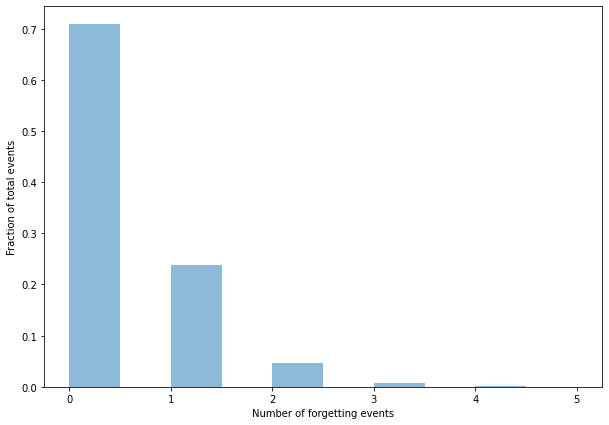

In [ ]:
process_msrments = processMeasurements(model_A_msrments)
process_msrments.plotForgetHist()

Obtain dataset of forgotten examples as well as the subset of those which were classified correclty at the end of training

In [ ]:
mgdataset = manageForgetDataset(model_A_msrments)
forget_data = mgdataset.get_forgotten_dataset()
forget_data_crt = mgdataset.get_forgotten_dataset_correct()
forget_data2 = dbg.get_forget()

Files already downloaded and verified
Files already downloaded and verified
[]


We can get the size of these datasets

In [ ]:
print(mgdataset.get_num_forgotten())
print(mgdataset.get_num_forgotten_correct())

108
41


Next let's try to add noise to the models:

In [ ]:
model_damage = damageModel(model_A)
noisy_clones = model_damage.addNoise()

|||||||||||||||||||||||||||||Cloning models...

In [ ]:
print(model_damage.getEpsilons())

[0.         0.03448276 0.06896552 0.10344828 0.13793103 0.17241379
 0.20689655 0.24137931 0.27586207 0.31034483 0.34482759 0.37931034
 0.4137931  0.44827586 0.48275862 0.51724138 0.55172414 0.5862069
 0.62068966 0.65517241 0.68965517 0.72413793 0.75862069 0.79310345
 0.82758621 0.86206897 0.89655172 0.93103448 0.96551724 1.        ]


We can see how well one of the noisy models does in classifying the correct highly forgotten examples

In [ ]:
post_process = postProcess(mgdataset.get_num_forgotten_correct())
post_process2 = postProcess(128)
classifications = post_process.classifyDataset(forget_data_crt, noisy_clones)
#classifications2 = post_process2.classifyDataset(forget_data2, noisy_clones)

In [ ]:
classifications[0]

tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
        0., 1., 0., 1., 1.])

In [ ]:
bct=0
for b in forget_data2:
    t,tb = b
    for ex in t:
        bct+=1
print(bct)

bct=0
for b in forget_data_crt:
    t,tb=b
    for ex in t:
        bct+=1
print(bct)

128
13


In [ ]:
len(next(iter(forget_data2))[0])

128

In [ ]:
x,y = next(iter(forget_data_crt))
res = model_A(x.cuda())

In [ ]:
res[0]

tensor([-1.3210, -3.8347,  2.2128,  2.9843,  2.9100,  3.8717, -0.4597,  2.5502,
        -4.0845, -2.8960], device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
y[0]

tensor(5)

In [ ]:
model_A.eval()
testclass = torch.zeros(mgdataset.get_num_forgotten_correct())
#testclass = torch.zeros(128)
count = 0
for b in forget_data_crt:
    x,y = b
    with torch.no_grad():
        out = model_A(x.cuda())
    for i in range(len(out)):
        if torch.argmax(out[i]) == y.cuda()[i]:
            testclass[i]=1
        else:
            print(f"{torch.argmax(out[i])},{y[i]}")
        count+=1

print(count)
print(testclass)

4,3
0,8
3,5
6
tensor([1., 0., 1., 1., 0., 0.])


In [ ]:
model_A_msrments.correctStatistics[29,0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])

In [ ]:
torch.flatten(model_A_msrments.correctStatistics[29])[mgdataset.getForgetMaskCorrect()]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [ ]:
torch.flatten(model_A_msrments.correctStatistics[29])

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [ ]:
dataset = datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

Files already downloaded and verified


In [ ]:
mask = list()
mask.append(0)
mask.append(3)
trainsubset = torch.utils.data.Subset(dataset, mask)
loader= torch.utils.data.DataLoader(trainsubset, batch_size=128)
loaderold = torch.utils.data.DataLoader(dataset, batch_size=128)

In [ ]:
for batch in loader:
    for examples in batch:
        print(examples)

tensor([[[[-1.1075, -1.3815, -1.2617,  ...,  0.5878,  0.4851,  0.4166],
          [-1.8439, -2.1179, -1.8097,  ..., -0.0116, -0.0801, -0.0287],
          [-1.6898, -1.8439, -1.2788,  ..., -0.0972, -0.0629, -0.2513],
          ...,
          [ 1.4440,  1.3242,  1.2728,  ...,  0.6221, -1.1589, -1.2103],
          [ 0.9646,  0.8447,  1.0673,  ...,  1.0331, -0.4568, -0.6965],
          [ 0.9132,  0.7591,  0.9474,  ...,  1.5810,  0.4679, -0.0116]],

         [[-0.9503, -1.2304, -1.1954,  ...,  0.2752,  0.1527,  0.1352],
          [-1.6856, -2.0357, -1.8957,  ..., -0.4951, -0.5826, -0.5126],
          [-1.6155, -1.9132, -1.5630,  ..., -0.5651, -0.5651, -0.7577],
          ...,
          [ 0.9405,  0.6429,  0.7829,  ...,  0.2927, -1.4930, -1.4405],
          [ 0.3978,  0.1176,  0.4853,  ...,  0.5553, -0.9503, -1.1078],
          [ 0.4853,  0.2227,  0.4503,  ...,  1.1856,  0.0301, -0.4251]],

         [[-0.7064, -1.0201, -1.0550,  ...,  0.0779, -0.0267, -0.0092],
          [-1.4559, -1.8044, -

In [ ]:
x,y = next(iter(loader))

In [ ]:
print(x[1])
print(y[1])

tensor([[[-1.6384, -1.4843, -1.4672,  ..., -0.8164, -0.7308, -0.6623],
         [-1.5528, -1.5357, -1.5699,  ..., -0.4911, -0.4739, -0.6623],
         [-1.4500, -1.4329, -1.1418,  ..., -0.5253, -0.2856, -0.4911],
         ...,
         [-0.6965, -0.6281, -0.6794,  ..., -0.4226, -0.5767, -0.7308],
         [-0.6109, -0.5767, -0.5253,  ..., -0.7479, -0.8164, -0.7137],
         [-0.4568, -0.5082, -0.5253,  ..., -1.1932, -1.0390, -0.8849]],

        [[-1.5980, -1.4405, -1.4230,  ..., -0.8627, -0.7752, -0.7052],
         [-1.5455, -1.5105, -1.5630,  ..., -0.6001, -0.6001, -0.7752],
         [-1.4755, -1.4580, -1.1604,  ..., -0.7052, -0.4776, -0.6877],
         ...,
         [-0.7577, -0.6877, -0.7402,  ..., -0.4076, -0.5651, -0.7227],
         [-0.7752, -0.7402, -0.6877,  ..., -0.7402, -0.8102, -0.7052],
         [-0.6702, -0.7227, -0.7227,  ..., -1.2129, -1.0553, -0.8978]],

        [[-1.6302, -1.4733, -1.4559,  ..., -1.1247, -1.0550, -0.9853],
         [-1.5779, -1.5604, -1.5953,  ..., -0

In [ ]:
xp, yp = next(iter(loaderold))

In [ ]:
print(xp[3])
print(yp[3])

tensor([[[-1.6384, -1.4843, -1.4672,  ..., -0.8164, -0.7308, -0.6623],
         [-1.5528, -1.5357, -1.5699,  ..., -0.4911, -0.4739, -0.6623],
         [-1.4500, -1.4329, -1.1418,  ..., -0.5253, -0.2856, -0.4911],
         ...,
         [-0.6965, -0.6281, -0.6794,  ..., -0.4226, -0.5767, -0.7308],
         [-0.6109, -0.5767, -0.5253,  ..., -0.7479, -0.8164, -0.7137],
         [-0.4568, -0.5082, -0.5253,  ..., -1.1932, -1.0390, -0.8849]],

        [[-1.5980, -1.4405, -1.4230,  ..., -0.8627, -0.7752, -0.7052],
         [-1.5455, -1.5105, -1.5630,  ..., -0.6001, -0.6001, -0.7752],
         [-1.4755, -1.4580, -1.1604,  ..., -0.7052, -0.4776, -0.6877],
         ...,
         [-0.7577, -0.6877, -0.7402,  ..., -0.4076, -0.5651, -0.7227],
         [-0.7752, -0.7402, -0.6877,  ..., -0.7402, -0.8102, -0.7052],
         [-0.6702, -0.7227, -0.7227,  ..., -1.2129, -1.0553, -0.8978]],

        [[-1.6302, -1.4733, -1.4559,  ..., -1.1247, -1.0550, -0.9853],
         [-1.5779, -1.5604, -1.5953,  ..., -0

In [ ]:
model_A(x.cuda())

tensor([[-2.9894, -1.9731,  0.0483,  4.0130, -0.4503,  2.7578,  4.2070, -0.9853,
         -3.1088, -2.5000],
        [-2.6935, -2.2610,  1.0830,  0.1237,  6.2339, -0.0703,  2.2714,  3.1146,
         -4.8501, -1.2848]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
model_A(xp.cuda())[3]

tensor([-2.6935, -2.2610,  1.0830,  0.1237,  6.2339, -0.0703,  2.2714,  3.1146,
        -4.8501, -1.2848], device='cuda:0', grad_fn=<SelectBackward>)

We can easily use this information to obtain a ranking of examples (that is, which ones were forgotten first as we dialed up the noise)

## Scratch

In [ ]:
if torch.argmax(torch.tensor([1,4,2,3,5,1,1]))==4:
    print("true!")

true!


In [ ]:
mgdataset = manageForgetDataset(model_A_msrments)
fordata = mgdataset.get_forgotten_dataset()
fordatacrt = mgdataset.get_forgotten_dataset_correct()

Files already downloaded and verified
At epoch: 30
Len of correct_flat: 50048


In [ ]:
countfor = 0
for batch in fordata:
    x,y = batch
    for j in range(len(x)):
        countfor+=1

countforcorrect = 0
for batch in fordatacrt:
    x,y = batch
    for j in range(len(x)):
        countforcorrect+=1

In [ ]:
mgdataset.forget_mask_correct

[]

In [ ]:
len(mgdataset.forget_mask)

181

In [ ]:
countforcorrect

80

In [ ]:
countfor

181

In [ ]:
len(fordata)

2

In [ ]:
#record the ordering before adding noise
#we tabulate a matrix
import numpy as np
epsilons = np.linspace(0.05,1,25)
model_A_state_dict = model_A.state_dict()

In [ ]:
from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_clones = []

for i in range(len(epsilons)):
    print(f"Adding model.. {i/25}")
    model_clones.append(registry.get(model_hparams).cuda())
    model_clones[i].load_state_dict(model_A_state_dict)

Adding model.. 0.0
Adding model.. 0.04
Adding model.. 0.08
Adding model.. 0.12
Adding model.. 0.16
Adding model.. 0.2
Adding model.. 0.24
Adding model.. 0.28
Adding model.. 0.32
Adding model.. 0.36
Adding model.. 0.4
Adding model.. 0.44
Adding model.. 0.48
Adding model.. 0.52
Adding model.. 0.56
Adding model.. 0.6
Adding model.. 0.64
Adding model.. 0.68
Adding model.. 0.72
Adding model.. 0.76
Adding model.. 0.8
Adding model.. 0.84
Adding model.. 0.88
Adding model.. 0.92
Adding model.. 0.96


In [ ]:
with torch.no_grad():
    k = 0
    for model in model_clones:
        for param in model.parameters():
            param.multiply_(1+torch.empty(param.size()).cuda().normal_(mean=0,std=epsilons[k]))
        k+=1

In [ ]:
import sys
import time

for i in range(10):
    sys.stdout.write("\r{0}>".format("="*i))
    sys.stdout.flush()
    time.sleep(0.5)

=========>

## Scratch

In [ ]:
transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
test_dataset=datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
# subset_list = list(range(0,len(test_dataset)))
# test_subset = torch.utils.data.Subset(test_dataset, subset_list)
data_loader_2 =torch.utils.data.DataLoader(test_dataset, batch_size=128)

Files already downloaded and verified


In [ ]:
#test_dataset=datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

test_dataset=datasets.CIFAR10('/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
subset_list = list(range(0,len(test_dataset)))
test_subset = torch.utils.data.Subset(test_dataset, subset_list)
data_loader =torch.utils.data.DataLoader(test_subset, batch_size=128)


Extracting /cifar-10-python.tar.gz to /


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


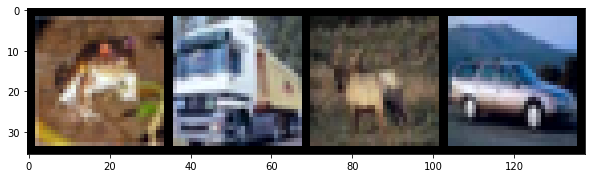

In [ ]:
#plot images
import numpy as np

images, labels = next(iter(data_loader_2))

gridlist = [images[0]*.23 + 0.45,images[1]*0.23 + 0.45,(images[3]*.23)+0.45,(images[4]*.23)+0.45]
gridimgs = utils.make_grid(gridlist)
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(gridimgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


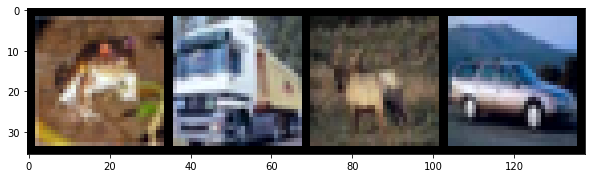

In [ ]:
import numpy as np

images_2, labels_2 = next(iter(train_set))

gridlist2 = [images_2[0]*.23 + 0.45,images_2[1]*0.23 + 0.45,(images_2[3]*.23)+0.45,(images_2[4]*.23)+0.45]
gridimgs2 = utils.make_grid(gridlist2)
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(gridimgs2)

In [ ]:
print(images[0])
print(images_2[0])

tensor([[[-1.1075, -1.3815, -1.2617,  ...,  0.5878,  0.4851,  0.4166],
         [-1.8439, -2.1179, -1.8097,  ..., -0.0116, -0.0801, -0.0287],
         [-1.6898, -1.8439, -1.2788,  ..., -0.0972, -0.0629, -0.2513],
         ...,
         [ 1.4440,  1.3242,  1.2728,  ...,  0.6221, -1.1589, -1.2103],
         [ 0.9646,  0.8447,  1.0673,  ...,  1.0331, -0.4568, -0.6965],
         [ 0.9132,  0.7591,  0.9474,  ...,  1.5810,  0.4679, -0.0116]],

        [[-0.9503, -1.2304, -1.1954,  ...,  0.2752,  0.1527,  0.1352],
         [-1.6856, -2.0357, -1.8957,  ..., -0.4951, -0.5826, -0.5126],
         [-1.6155, -1.9132, -1.5630,  ..., -0.5651, -0.5651, -0.7577],
         ...,
         [ 0.9405,  0.6429,  0.7829,  ...,  0.2927, -1.4930, -1.4405],
         [ 0.3978,  0.1176,  0.4853,  ...,  0.5553, -0.9503, -1.1078],
         [ 0.4853,  0.2227,  0.4503,  ...,  1.1856,  0.0301, -0.4251]],

        [[-0.7064, -1.0201, -1.0550,  ...,  0.0779, -0.0267, -0.0092],
         [-1.4559, -1.8044, -1.8044,  ..., -0

In [ ]:
list(range(0,len(test),2))[0:10]

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

In [ ]:
len(test_subset)

25000

In [ ]:
iterated = iter(data_loader)

In [ ]:
first(train_set)

NameError: ignored

In [ ]:
counter=0
for batch in train_set:
    x,y = batch
    x2,y2 = next(iter(data_loader))
    print(x[0]-x2[0])
    print(y-y2)
    if counter > 10:
        exit()
    counter+=1

Streaming output truncated to the last 5000 lines.
         [-2.0218, -1.6383, -1.5163,  ..., -2.4401, -1.4641, -1.2549]]])
tensor([-5, -2,  1,  3,  1, -4, -2, -4, -8, -2,  1, -5,  4,  4, -3,  0, -1,  3,
         5, -2, -1, -1,  5,  8, -2, -8, -5,  1, -3,  4,  8,  1,  7, -1, -2, -1,
        -2,  4, -3,  0,  0,  2, -4,  0, -9,  4, -6,  8,  8, -1, -6, -9, -5,  0,
         7, -4,  4, -1,  5, -9,  6, -4, -1,  2, -2, -2, -2,  2, -1,  6,  4, -1,
         2, -6, -1,  1, -4, -1,  1,  3,  5,  2, -5, -6,  2, -7, -4,  0,  2, -6,
         0,  3,  3, -4, -1, -6, -8, -1,  3,  0, -5, -2, -1,  3, -3, -3,  2, -4,
         1,  4,  1, -1, -6,  2, -6, -3, -3,  2,  0, -1, -3,  2, -3, -2,  1,  7,
        -5,  1])
tensor([[[ 1.0617,  1.3529,  1.3015,  ..., -0.1370, -0.0342, -2.5345],
         [ 1.8152,  2.1406,  1.8495,  ...,  0.4795,  0.5651, -2.0892],
         [ 1.6269,  1.8323,  1.3015,  ...,  0.5651,  0.5480, -1.8666],
         ...,
         [-3.3907, -3.1852, -3.1852,  ..., -2.2605, -0.6165, -0.9076],
 

KeyboardInterrupt: ignored

In [ ]:
from datasets import registry

In [ ]:
from datasets import cifar10

In [ ]:
cifar10.Dataset(test_dataset)

TypeError: ignored

In [ ]:
a, ab = next(iter(data_loader_2))
print(a[0])

tensor([[[-1.1075, -1.3815, -1.2617,  ...,  0.5878,  0.4851,  0.4166],
         [-1.8439, -2.1179, -1.8097,  ..., -0.0116, -0.0801, -0.0287],
         [-1.6898, -1.8439, -1.2788,  ..., -0.0972, -0.0629, -0.2513],
         ...,
         [ 1.4440,  1.3242,  1.2728,  ...,  0.6221, -1.1589, -1.2103],
         [ 0.9646,  0.8447,  1.0673,  ...,  1.0331, -0.4568, -0.6965],
         [ 0.9132,  0.7591,  0.9474,  ...,  1.5810,  0.4679, -0.0116]],

        [[-0.9503, -1.2304, -1.1954,  ...,  0.2752,  0.1527,  0.1352],
         [-1.6856, -2.0357, -1.8957,  ..., -0.4951, -0.5826, -0.5126],
         [-1.6155, -1.9132, -1.5630,  ..., -0.5651, -0.5651, -0.7577],
         ...,
         [ 0.9405,  0.6429,  0.7829,  ...,  0.2927, -1.4930, -1.4405],
         [ 0.3978,  0.1176,  0.4853,  ...,  0.5553, -0.9503, -1.1078],
         [ 0.4853,  0.2227,  0.4503,  ...,  1.1856,  0.0301, -0.4251]],

        [[-0.7064, -1.0201, -1.0550,  ...,  0.0779, -0.0267, -0.0092],
         [-1.4559, -1.8044, -1.8044,  ..., -0

In [ ]:
t, tb = next(iter(train_set))
a, ab = next(iter(data_loader))

In [ ]:
print(t[0])
print(a[0])

tensor([[[ 0.1597,  0.1426,  0.1254,  ..., -2.1179, -2.1179, -2.1179],
         [ 0.3138,  0.1083,  0.0569,  ..., -2.1179, -2.1179, -2.1179],
         [ 0.1939,  0.1426,  0.1083,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-1.5357, -1.1247, -0.3369,  ..., -2.1179, -2.1179, -2.1179],
         [-0.3541, -0.5424, -0.0629,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-0.3901, -0.4426, -0.4776,  ..., -2.0357, -2.0357, -2.0357],
         [-0.1975, -0.4251, -0.4776,  ..., -2.0357, -2.0357, -2.0357],
         [-0.4076, -0.4601, -0.4426,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-1.9482, -1.4930, -0.8627,  ..., -2.0357, -2.0357, -2.0357],
         [-0.6702, -0.8627, -0.5126,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-0.7936, -0.8807, -0.9678,  ..., -1.8044, -1.8044, -1.8044],
         [-0.6193, -0.8807, -0.9330,  ..., -1

In [ ]:
2.6400/1.8044

1.4630902238971404

In [ ]:
class helperFunctions:
    def __init__(self):
        self.num_batches = len(train_set)
        self.batch_size = next(iter(train_set))[0].size()[0]
        self.zeroTensor = torch.zeros(())

        self.batchsizes=[]
        for batch in train_set:
            self.batchsizes.append(batch[0].size()[0])

    def getZeroTensor(self): #returns a tensor or zeroes with dimension equal to # of batches*# of examples in each batch
        for batch in train_set:
            batchsize = batch[0].size()[0]


Epoch 1, train loss A: 2.06 accuracy A: 0.23 

Epoch 2, train loss A: 1.81 accuracy A: 0.33 

Epoch 3, train loss A: 1.70 accuracy A: 0.37 

Epoch 4, train loss A: 1.62 accuracy A: 0.40 

Epoch 5, train loss A: 1.55 accuracy A: 0.43 

Epoch 6, train loss A: 1.49 accuracy A: 0.45 

Epoch 7, train loss A: 1.44 accuracy A: 0.47 

Epoch 8, train loss A: 1.38 accuracy A: 0.49 

Epoch 9, train loss A: 1.33 accuracy A: 0.52 

Epoch 10, train loss A: 1.29 accuracy A: 0.53 

Epoch 11, train loss A: 1.25 accuracy A: 0.55 

Epoch 12, train loss A: 1.22 accuracy A: 0.56 

Epoch 13, train loss A: 1.19 accuracy A: 0.57 

Epoch 14, train loss A: 1.16 accuracy A: 0.58 

Epoch 15, train loss A: 1.13 accuracy A: 0.59 

Epoch 16, train loss A: 1.11 accuracy A: 0.60 

Epoch 17, train loss A: 1.09 accuracy A: 0.61 

Epoch 18, train loss A: 1.06 accuracy A: 0.62 

Epoch 19, train loss A: 1.04 accuracy A: 0.62 

Epoch 20, train loss A: 1.03 accuracy A: 0.63 



In [ ]:
model_A_msrments.forgetStatistics[0,0].size()[0]

128

In [ ]:
manageData=manageForgetDataset(model_A_msrments)
forgotten_set = manageData.get_forgotten_dataset()

Files already downloaded and verified


In [ ]:
next(iter(forgotten_set))

IndexError: ignored

In [ ]:
tot = torch.sum(model_A_msrments.forgetStatistics,0)
totFlat = torch.flatten(tot)

In [ ]:
totFlat.size()

torch.Size([50048])

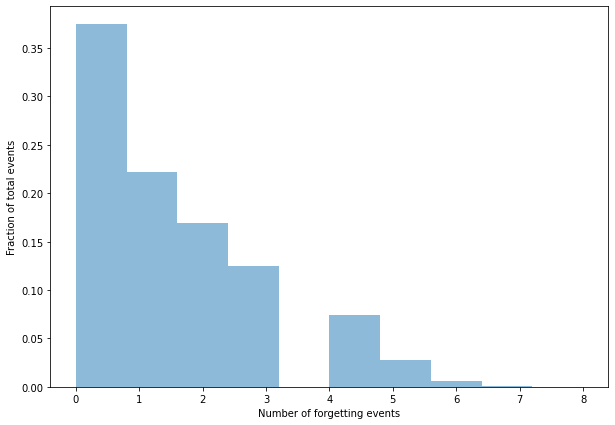

In [ ]:
process = processMeasurements(model_A_msrments)
process.plotForgetHist()

In [ ]:
# from foundations import hparams
# from models import registry

# model_hparams = hparams.ModelHparams(
#     'cifar_resnet_20',
#     'kaiming_uniform',
#     'uniform'
# )
# testCopy = registry.get(model_hparams).cuda()
# testCopy.load_state_dict(model_A_state_dict)

<All keys matched successfully>

In [ ]:
# testv=[]
# testv.append(testCopy)

In [ ]:
epsilons[24]

1.0

In [ ]:
ps=model_A.parameters()

In [ ]:
next(ps).size()

torch.Size([16])

In [ ]:
matrix=torch.rand(torch.Size([2, 2]))
print(matrix)
print(matrix*0.1)

tensor([[0.5460, 0.5551],
        [0.1765, 0.1428]])
tensor([[0.0546, 0.0555],
        [0.0176, 0.0143]])


## Scratch

In [ ]:
with torch.no_grad():
    for param in model_A.parameters():
        print(param)

Parameter containing:
tensor([[[[ 0.3359,  0.2122,  0.2936],
          [-0.4357,  0.3791,  0.1035],
          [-0.5486,  0.1932,  0.3652]],

         [[-0.1027,  0.0941, -0.1432],
          [-0.2385, -0.0900,  0.3772],
          [-0.0411, -0.4218,  0.2456]],

         [[-0.1773,  0.1650,  0.2649],
          [ 0.0690, -0.0498, -0.2736],
          [-0.4439,  0.1397,  0.1371]]],


        [[[-0.2607,  0.1767,  0.2951],
          [ 0.2390,  0.2469, -0.0896],
          [-0.1899, -0.1489, -0.1903]],

         [[ 0.1545, -0.0686, -0.4377],
          [ 0.0773,  0.1521,  0.2717],
          [-0.3863,  0.3285, -0.2309]],

         [[-0.2326,  0.2835, -0.3001],
          [-0.2229,  0.3890, -0.1359],
          [-0.3316, -0.3786, -0.1551]]],


        [[[-0.0923, -0.4500, -0.4989],
          [-0.1435,  0.1315,  0.0653],
          [ 0.0923,  0.3156, -0.5831]],

         [[-0.2606,  0.4134,  0.3242],
          [ 0.0508, -0.2533, -0.0357],
          [ 0.0058, -0.2484, -0.4557]],

         [[-0.3571,  0

# Scratch

In [ ]:
#First load models, dataset

!git clone https://github.com/facebookresearch/open_lth.git
import sys
sys.path.append('/content/open_lth/')

from foundations import hparams
from models import registry

model_hparams = hparams.ModelHparams(
    'cifar_resnet_20',
    'kaiming_uniform',
    'uniform'
)

model_A = registry.get(model_hparams).cuda()
model_B = registry.get(model_hparams).cuda()

from datasets import registry

dataset_hparams = hparams.DatasetHparams(
    'cifar10',
    128 #batch size
)

#set the platform
from platforms import base
import platforms.platform
import platforms.local

platforms.platform._PLATFORM = platforms.local.Platform()

train_set = registry.get(
    dataset_hparams,
    train = True
)

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

loss_A = nn.CrossEntropyLoss()
loss_B =  nn.MSELoss() #nn.KLDivLoss() #nn.CrossEntropyLoss()
optimizer_A = optim.SGD(model_A.parameters(), lr=1e-3, momentum=0.9)
optimizer_B = optim.SGD(model_B.parameters(), lr=1e-3, momentum=0.9)

fatal: destination path 'open_lth' already exists and is not an empty directory.
Files already downloaded and verified


In [ ]:
nb_epochs = 4
batch_size = 128
#output_vectors = torch.empty(nb_epochs, len(train_set), batch_size, 10)
a_i_A = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_A = torch.zeros(len(train_set),128)

model_B_on_A_acc = torch.zeros(len(train_set),128)
model_B_on_A_acc_tilde = torch.zeros(len(train_set),128)

a_i_B = torch.zeros(len(train_set),128) #batch size = 128, about 390 batches
a_tilde_i_B = torch.zeros(len(train_set),128)

forget_matrix_A = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of A
forget_matrix_B = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of B wrt image classification
forget_matrix_B_on_A = torch.zeros(nb_epochs, len(train_set),128) #forget statistics of B wrt A logits

softmaxfunc=nn.Softmax(dim=1) #softmax to check classification
batch_tracker = 0

#initialize previous logits
model_A.eval()
#first_x, first_y = next(iter(train_set))

l_A_previous = torch.zeros(nb_epochs, len(train_set), 128, 10)

model_A.eval()
model_B.eval()

#initialize previous logits
# for batch in train_set:
#     x, y = batch
#     x=x.cuda()
#     l_A = model_A(x)
#     with torch.no_grad():
#         l_A_previous[0, batch_tracker, 0:len(l_A)] = l_A #set previous logits equal to current logits to start with
#     batch_tracker += 1

model_A.train()
model_B.train()
batch_tracker = 0

for epoch in range(nb_epochs):
    losses_A = list()
    accuracies_A = list()

    losses_B = list()
    accuracies_B = list()

    for batch in train_set:
        x, y = batch
        x = x.cuda()

        l_A = model_A(x)
        l_A_prime = model_A(x)
        l_B = model_B(x)

        with torch.no_grad():
            l_A_previous[epoch, batch_tracker, 0:len(l_A)] = l_A #set previous logits equal to current logits to start with
    
        #batch_size_current = len(batch[1])
        #output_vectors[epoch, batch_tracker, 0:batch_size_current] = l_A

        #check if model A's prediction is correctly classified
        l_A_softmax = softmaxfunc(l_A)
        if epoch >1:
            l_A_previous_softmax = softmaxfunc(l_A_previous[epoch-1, batch_tracker])

        for k in range(len(l_A_softmax)):
            if torch.argmax(l_A_softmax[k])==y[k]: #if it is, mark as '1'
                a_i_A[batch_tracker, k] = 1
            else:
                a_i_A[batch_tracker, k] = 0 #otherwise 0

            if a_i_A[batch_tracker, k] < a_tilde_i_A[batch_tracker, k]: #and if we find that the marker has decreased, we've forgotten the example
                forget_matrix_A[epoch, batch_tracker, k] += 1
                
                #if we forgot the example, build new logits which involve previous ones
                #we will use this to rewind the logits
                #try:
                if epoch > 1 and torch.argmax(l_A_previous_softmax[k])==y[k]:
                    #print(f"Forgot example! Replacing {l_A_prime[k]} with {l_A_previous[epoch-1,batch_tracker, k]} \n")
                    #print(f"Was it classified correctly before? {torch.argmax(l_A_previous_softmax[k])==y[k]}")
                    l_A_prime[k] = l_A_previous[epoch-1,batch_tracker, k]
                #except IndexError:
                    #print(f"batch_Tracker {batch_tracker} k {k}")

            a_tilde_i_A[batch_tracker, k] = a_i_A[batch_tracker, k]
    
        #now do the same with model B
        l_B_softmax = softmaxfunc(l_B)

        for k in range(len(l_B_softmax)):
            if torch.argmax(l_B_softmax[k])==y[k]:
                a_i_B[batch_tracker, k] = 1
            else:
                a_i_B[batch_tracker, k] = 0

            if a_i_B[batch_tracker, k] < a_tilde_i_B[batch_tracker, k]:
                forget_matrix_B[epoch, batch_tracker, k] += 1

            a_tilde_i_B[batch_tracker, k] = a_i_B[batch_tracker, k]

            #also measure how much it forgets w.r.t. the task it is trained for
            #(how much it forgets model A's logits)
            if torch.argmax(l_B_softmax[k])==torch.argmax(l_A_softmax[k]):
                model_B_on_A_acc[batch_tracker, k] = 0
            else:
                model_B_on_A_acc[batch_tracker, k] = 1
            
            if model_B_on_A_acc[batch_tracker, k] < model_B_on_A_acc_tilde[batch_tracker, k]:
                forget_matrix_B_on_A[epoch, batch_tracker, k] += 1
            
            model_B_on_A_acc_tilde[batch_tracker, k] = model_B_on_A_acc[batch_tracker, k]



        #2. compute objective function for A and B
        J_A = loss_A(l_A, y.cuda())
        #print(J_A)

        #we need to first see if the example got forgotten
        #if so, we need to feed in l_A_previous to model_B's loss function
        #otherwise, use the current logits

        #model B's loss is to compute cross entropy between its output and the output of model A
        
        #J_B = loss_B(l_B, l_A_prime)
        J_B = loss_B(l_B, l_A_prime)

        #3. cleaning the gradients
        model_A.zero_grad()
        model_B.zero_grad()

        #reset previous logits
        #l_A_previous[] = l_A

        #4. accumulate partial derivatives
        J_A.backward() #what happens without retain_Graph?

        #J_A.backward(retain_graph=True)
        J_B.backward() #bug!

        #5. step in opposite direction
        optimizer_A.step()
        optimizer_B.step()

        #6. monitor loss
        losses_A.append(J_A.item())
        losses_B.append(J_B.item())
        accuracies_A.append(y.eq(l_A.detach().argmax(dim=1).cpu()).float().mean())
        accuracies_B.append(y.eq(l_B.detach().argmax(dim=1).cpu()).float().mean())



        batch_tracker+=1


    print(f"Epoch {epoch +1}, train loss A, B: {torch.tensor(losses_A).mean():.2f} , {torch.tensor(losses_B).mean():.2f} \n")
    print(f"Training accuracy for A, B: {torch.tensor(accuracies_A).mean():.2f} , {torch.tensor(accuracies_B).mean():.2f} \n")
    batch_tracker = 0

Epoch 1, train loss A, B: 2.20 , 0.08 

Training accuracy for A, B: 0.21 , 0.15 

Epoch 2, train loss A, B: 1.98 , 0.06 

Training accuracy for A, B: 0.29 , 0.22 

Epoch 3, train loss A, B: 1.86 , 0.07 

Training accuracy for A, B: 0.34 , 0.25 

Epoch 4, train loss A, B: 1.79 , 0.07 

Training accuracy for A, B: 0.36 , 0.27 



In [ ]:
print(torch.flatten(forget_matrix_noise)[0:10])

tensor([18., 11., 11., 11., 11., 17., 15.,  7., 16.,  4.])


(array([0.1, 0. , 0.1, 0. , 0. , 0.4, 0. , 0.1, 0.1, 0.2]),
 array([ 4. ,  5.4,  6.8,  8.2,  9.6, 11. , 12.4, 13.8, 15.2, 16.6, 18. ],
       dtype=float32),
 <a list of 10 Patch objects>)

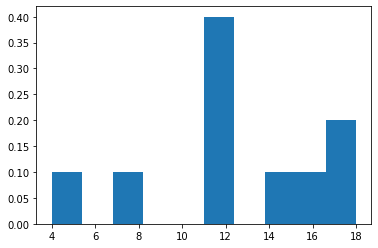

In [ ]:
import numpy
#plt.hist(torch.flatten(forget_matrix_noise)[0:10], label = "Events")
plt.hist(torch.flatten(forget_matrix_noise)[0:10], label = "Events", weights=numpy.ones(len(torch.flatten(forget_matrix_noise)[0:10])) / len(torch.flatten(forget_matrix_noise)[0:10]))

In [ ]:

model_1_cuda()

In [ ]:
torch.tensor(accuracies).mean()

tensor(0.4420)

In [ ]:
ep = 3
sys.stdout.flush()
print("ep: {}".format(ep))

In [ ]:
import test
print(test)

In [ ]:
torch.tensor(losses).mean()
print(f"Epoch {epoch +1}")

In [ ]:
print(f"Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f}")

In [ ]:
images, labels = next(iter(train_set))
model_1.eval()
loss(model_1(images),labels)

tensor(2.3900, grad_fn=<NllLossBackward>)

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
#transforms.ToTensor()(testplotimages).size()

In [ ]:
testplotimages = []#torch.empty(10)
for i in range(10):
    testplotimages.append(
        torch.transpose(torch.transpose(images[i]*0.45 + 0.23, 0, 1), 1, 2) #unnormalize
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


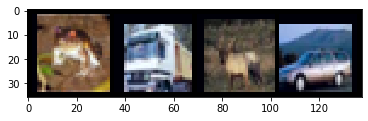

In [ ]:
gridlist = [images[0]*.23 + 0.45,images[1]*0.23 + 0.45,(images[3]*.23)+0.45,(images[4]*.23)+0.45]
blah = utils.make_grid(gridlist)
show(blah)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


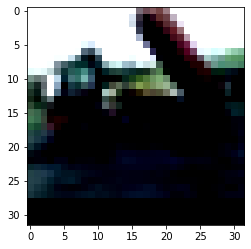

In [ ]:
for k in range(3):
    plt.imshow(utils.make_grid(testplotimages[k]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


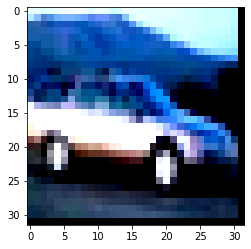

In [ ]:
testimage2.size()
plt.imshow(testimage2*.5+0.,)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TypeError: ignored

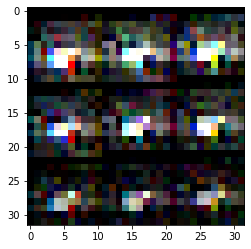

In [ ]:
images, labels = next(iter(train_set))
model_1.eval()
plt.imshow((0.5*images[3].reshape(32,32,3))+0.5)
plt.imshow(images[3])
#img=images[3].view(images[3].size(0), -1)
#softmax=nn.Softmax(dim=1)
# with torch.no_grad():
#     print(model_1(images))

In [ ]:
32*32

1024

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#we need to define an index function that determines whether an example has been seen before
#one idea: go through train set, assign each example a unique identifier
#when training, find the example in the list with the unique identifier
#update forget array at that location
#there are no repeats in each batch?
#since there are no repeats in each batch, we can get away with something simpler.
#we just have to keep track of it at each epoch.

images, labels = next(iter(train_set))
l = model_1_forget_cuda(images.cuda())

In [ ]:
softmaxfunc=nn.Softmax(dim=1)
testt =softmaxfunc(l[1]).round()
print(testt)

In [ ]:
images, labels = next(iter(train_set))
labels

tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
        2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9,
        6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6,
        1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1,
        2, 2, 9, 2, 6, 6, 1, 9])

In [ ]:
randlist = torch.rand(round(0.2*len(labels)))
newvals = torch.randint(0, 9, (len(labels),))
indices = torch.randint(0, len(labels), )
for i in range(len(labels)):


tensor([1, 4, 3, 5, 2, 0, 8, 2, 3, 2, 1, 5, 7, 3, 7, 6, 5, 4, 1, 4, 6, 7, 0, 5,
        8, 1, 6, 7, 8, 3, 7, 3, 0, 2, 6, 7, 8, 6, 8, 2, 3, 2, 4, 3, 1, 3, 1, 6,
        3, 8, 2, 7, 6, 8, 5, 1, 0, 5, 4, 0, 6, 7, 8, 3, 0, 8, 8, 0, 6, 5, 8, 4,
        7, 7, 4, 0, 1, 1, 5, 6, 6, 0, 7, 7, 7, 6, 4, 0, 7, 1, 0, 8, 7, 1, 4, 5,
        5, 6, 7, 1, 7, 1, 4, 1, 4, 8, 3, 6, 8, 5, 2, 1, 3, 5, 6, 8, 7, 1, 1, 0,
        8, 2, 2, 5, 0, 5, 8, 6])

In [ ]:
import random
random.randint(0,9)

4

In [ ]:
indices = torch.randint(0, len(labels), (round(0.2*len(labels))+1,))
print(indices)
newlabels = torch.clone(labels)

for idx in indices:
    newlabels[idx] = random.randint(0,9)

print(labels)
print(newlabels)
print(labels-newlabels)

tensor([124,  72,  40,  67,  11,   7, 121,  91,  93,   3,  75,  16, 116, 125,
         65,   7,   6,   5,  35,  88,  93, 114, 106, 103,  61,  57,  35])
tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
        2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9,
        6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6,
        1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1,
        2, 2, 9, 2, 6, 6, 1, 9])
tensor([6, 9, 9, 4, 1, 7, 3, 7, 8, 3, 4, 0, 7, 2, 9, 9, 4, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 2, 3, 7, 3, 3, 7, 2, 2, 7, 1, 1, 1, 2,
        2, 0, 9, 5, 7, 9, 2, 2, 5, 6, 4, 3, 1, 8, 8, 2, 1, 1, 4, 7, 7, 8, 5, 9,
        9, 7, 3, 4, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 6, 4, 2, 1, 8, 7, 1, 6,
        1, 1, 4, 1, 8, 3, 9, 4, 6, 1, 6, 5, 2, 9, 9, 8, 1, 7, 4, 0, 5, 6, 9, 1,
        2, 0, 9

In [ ]:
newlabels[3] = 3
newlabels[3]

tensor(3)

# Playing with Gradient Variances

Our goal here is to see if important examples are picked out by the variance of the gradient. Let's start with something simple first before we get into ResNets and CIFAR10. We'll look at MNIST dataset + FF network.

The toy experiment below aims to address the following question: how correlated are variance-of-gradients with example difficulty?

In the first part, we split the MNIST training data into a training set 55,000 and a validation set of 5,000. 

First, we calculate the variance of gradients over 10 training iterations and averaged over five initializations of the network. Note that we're specifically interested in gradients of the model outputs with respect to *weights*. Later, we'll want to compare these gradients against those used in, e.g., the paper by Hooker and collaborators. Each example is thus assigned a VoG value. Look at cosine similarity across times?

Next, we reset the network and train normally except the training dataset is pruned (for example, keep 75%, 50%, 20% of top VoG examples). For each one, we can look at train, test, and validation accuracy. We can also look at which ones in validation set it does the worst on. We can also correlate the VoG values with forgetting scores.


In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

In [ ]:
model = nn.Sequential(
    nn.Linear(28 * 28, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64,10)
).cuda()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum = 0.9)
loss = nn.CrossEntropyLoss()
train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
train_size = 55000
val_size = 5000
train, val = random_split(train_data, [train_size, val_size]) #randomly split dataset into train, validation
train_loader = DataLoader(train, batch_size=32)
val_loader = DataLoader(val, batch_size=32)

Now let's compute the variances and store them.

Note that for each example, we're going to compute the gradients of the model outputs w.r.t. model parameters d y_i / d w_{jk}. This gives us for each layer a matrix of dimension 10 x (dimensions of parameters for that layer).

We could associate each example with a scalar value (for example, we could just sum over all parameters and components of model outputs i.e. sum over i, j, and k) or a vector value (sum over only j, k). The advantage of keeping a vector 




In [ ]:
nb_ep_gradient = 10 #number of iterations over which we compute gradient variances

acc_ot = list() #accuracy over training time
loss_ot = list() #loss over training time
grad_var = torch.zeros([train_size, nb_ep_gradient]) #this will store the gradient variances for each example


for epoch in range(nb_ep_gradient):
    losses = list()
    accuracies = list()
    model.train()

    for batch in train_loader:
        x,y = batch
        batch_size = x.size(0)
        x = x.view(batch_size, -1).cuda()

        out = model(x)

        J = loss(l, y.cuda())
        model.zero_grad()
        J.backward()
        optimizer.step()

        losses.append(J.item())
        accuracies.append(y.eq(out.detach().argmax(dim=1).cpu()).float().mean())

    print(f'Epoch {epoch +1}, train loss: {torch.tensor(losses).mean():.2f}')
    print(f'Training accuracy: {torch.tensor(accuracies).mean():.2f}')

    acc_ot.append(torch.tensor(accuracies).mean())
    loss_ot.append(torch.tensor(losses).mean())


In [ ]:
import torch

In [ ]:
torch.tensor()

# Gradient scratch

In [ ]:
x,y = next(iter(train_loader))
batch_size = x.size(0)
x = x.view(batch_size, -1).cuda()

In [ ]:
output = model(x)
J = loss(output, y.cuda())
model.zero_grad()
J.backward()
optimizer.step()

In [ ]:
len(output[1])

10

In [ ]:
from torch.autograd import grad
output = model(x)
test = torch.zeros(10)
for i in range(10):
    print(i)
    print(grad(output[1][i], model.parameters()))

NameError: ignored

In [ ]:
grad(output[2][0], model.parameters(), retain_graph = True)

RuntimeError: ignored

In [ ]:
result = 0
for grads in gradients:
    result += grads.sum()

In [ ]:
result

tensor(52.6584, device='cuda:0')

In [ ]:
d_output_dw = output[1].sum().backward()

RuntimeError: ignored

In [ ]:
import torch
from torch.autograd import grad
import torch.nn as nn

# Create some dummy data.
x = torch.ones(2, 2, requires_grad=True)
gt = torch.ones_like(x) * 16 - 0.5  # "ground-truths" 

# We will use MSELoss as an example.
loss_fn = nn.MSELoss()

# Do some computations.
v = x + 2
y = v ** 2

# Compute loss.
loss = loss_fn(y, gt)

print(f'Loss: {loss}')

# Now compute gradients:
d_loss_dx = grad(outputs=loss, inputs=x)
print(f'dloss/dx:\n {d_loss_dx}')

Loss: 42.25
dloss/dx:
 (tensor([[-19.5000, -19.5000],
        [-19.5000, -19.5000]]),)


In [ ]:
print(gt)

tensor([[15.5000, 15.5000],
        [15.5000, 15.5000]])


In [ ]:
((x+2)**2 - gt)*(x+2)

tensor([[-19.5000, -19.5000],
        [-19.5000, -19.5000]], grad_fn=<MulBackward0>)

# Refactoring Forgetting Code

Steps:

1. Remove config parser, just read from command line. Separate training step and data analysis step.
2. Remove job system, we're just interested in training X number of models.
3. Add pruning flag
4. Processing should rank examples and compute metrics.

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainHParams:
    """
    This class contains the training hyperparameter details. These include:
    
    -dataset: the name of the dataset
    -model: the model to train
    -output_location: where to store the results
    -lr: learning rate (default 1e-3)
    -forget_thres: how many times an example needs to be forgotten to be recorded (default 3)
    -granularity: when to log metrics, either 'by_iter' or 'by_ep' (default by iteration)
    -momentum (defualt 0.9)
    -num_ep: number of epochs to train (default 20)
    -chkpoint_step: how often to save (default every 5ep)
    It also contains a method for outputting this information to a .CSV file.

    It takes as input TrainArgs (training arguments) and fills out the training hyperparameters.

    """

    model: str
    dataset: str
    output_location: str

    lr: float = 1e-3
    momentum: float = 0.9
    num_ep: int = 20
    chkpoint_step: int = 5
    
    #robustness params
    forget_thres: int = 3
    granularity: str = 'by_iter'

    def save_to_file(self, output_location: str) -> None:
        pass

In [ ]:
test = TrainHParams('hi', 'bye', 'test')

In [ ]:
test.__dict__

{'chkpoint_step': 5,
 'dataset': 'bye',
 'forget_thres': 3,
 'granularity': 'by_iter',
 'lr': 0.001,
 'model': 'hi',
 'momentum': 0.9,
 'num_ep': 20,
 'output_location': 'test'}

In [ ]:
test = TrainHParams('foo', 'bar', 'dir')

In [ ]:
type(20)

int

In [ ]:
test_dict = {'hm': str, 'hi': str, '2': int}

In [ ]:
import argparse

class Train:
	def __init__(self):
		pass

	def add_args(parser: argparse.ArgumentParser):
		allowed_params = {'--lr': float, '--save': bool}

		print('keys:')
		print(allowed_params.keys())

		for param in allowed_params.keys():
			parser.add_argument(param,
							    type = allowed_params[param],
							    help = 'help text')

In [ ]:
globalargs = {'train': Train}
parser = argparse.ArgumentParser(description='Do stuff.')
#parser.add_argument()


for global_arg in globalargs:
    print(f'Adding {global_arg}')
    train_group = parser.add_argument_group(global_arg, 'train a model')
    globalargs[global_arg].add_args(train_group)

Adding train
keys:
dict_keys(['--lr', '--save'])


In [ ]:
!rm -r Forget

In [ ]:
!rm -r open_lth

In [ ]:
!git clone https://github.com/facebookresearch/open_lth.git
!git clone https://github.com/nikhilanand91/Forget.git

Cloning into 'open_lth'...
remote: Enumerating objects: 112, done.
remote: Total 112 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (112/112), 88.23 KiB | 279.00 KiB/s, done.
Resolving deltas: 100% (18/18), done.
Cloning into 'Forget'...
remote: Enumerating objects: 316, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 316 (delta 131), reused 260 (delta 78), pack-reused 0
Receiving objects: 100% (316/316), 58.30 KiB | 9.72 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [ ]:
!python Forget/robust.py train --model 'cifar_resnet_20' --dataset 'cifar10' --output_location '/content/'


--------------------------------------------------
           Training hyperparameters:
--------------------------------------------------
     Model name: cifar_resnet_20
     Datset: cifar10
     Output directory: /content/
     Optimizer: SGD
     Learning rate: 0.001
     Momentum: 0.9
     No. of train epochs: 10ep
     Checkpoint every: 5ep
--------------------------------------------------

Files already downloaded and verified
tensor(0.2950)
tensor(0.3549)
tensor(0.3931)
tensor(0.4215)
Traceback (most recent call last):
  File "Forget/robust.py", line 31, in <module>
  File "Forget/robust.py", line 28, in main
    runner.run()
  File "/content/Forget/training/train_runner.py", line 53, in run
    train.train_loop(train_hparams = self.train_params)
  File "/content/Forget/training/train.py", line 40, in train_loop
    batch_accuracy.append(y.eq(outputs.detach().argmax(dim=1).cpu()).float().mean())
KeyboardInterrupt


In [ ]:
import torch

a = torch.randn(5,5)
b = torch.randn(5,5)

In [ ]:
a

tensor([[-0.4259,  0.4888, -0.5155, -1.0209, -0.0493],
        [ 0.4785, -0.8111,  1.3032, -1.1130,  1.3356],
        [ 0.0283, -1.8231, -0.3822, -0.1252,  1.0184],
        [ 1.6683, -2.7644,  0.9075, -0.4638, -0.1695],
        [-0.4201,  0.8403,  0.1470, -0.2414,  0.0555]])

In [ ]:
b

tensor([[ 0.2116,  1.3016, -0.2657,  0.4517,  0.3203],
        [-0.2667,  0.0156, -0.2504, -0.0493, -1.2371],
        [-0.7678,  0.2582, -0.0264, -0.2437, -0.7065],
        [ 1.1704,  1.9239,  1.5507, -1.1681, -2.2122],
        [-1.0314,  0.0984,  0.3103, -0.1407,  0.2355]])

In [ ]:
hash(a)

139670894778224

In [ ]:
c = torch.tensor([[-0.4259,  0.4888, -0.5155, -1.0209, -0.0493],
        [ 0.4785, -0.8111,  1.3032, -1.1130,  1.3356],
        [ 0.0283, -1.8231, -0.3822, -0.1252,  1.0184],
        [ 1.6683, -2.7644,  0.9075, -0.4638, -0.1695],
        [-0.4201,  0.8403,  0.1470, -0.2414,  0.0555]])

In [ ]:
c

tensor([[-0.4259,  0.4888, -0.5155, -1.0209, -0.0493],
        [ 0.4785, -0.8111,  1.3032, -1.1130,  1.3356],
        [ 0.0283, -1.8231, -0.3822, -0.1252,  1.0184],
        [ 1.6683, -2.7644,  0.9075, -0.4638, -0.1695],
        [-0.4201,  0.8403,  0.1470, -0.2414,  0.0555]])

In [ ]:
hash(c)

139666501707440

In [ ]:
hash(a) == hash(c)

False

In [ ]:
test = []
test.append(4)
print(test)

[4]


In [ ]:
from torch.utils.data import Sampler
import random

class RandomSampler(Sampler):
	def __init__(self, data_source):
		self.data_source = data_source
		self.shuffle()
		self.idx = None

	def shuffle(self):
		self.idx = list(range(len(self.data_source)))
		self.seed = random.randint(0, 2**32-1)
		random.Random(self.seed).shuffle(self.idx)
		return self.idx
		
	def __iter__(self):
		return iter(self.idx)

	def get_order(self):
		return self.idx

	def __len__(self):
		return len(self.data_source)

In [ ]:
from dataclasses import dataclass, field
from torchvision import datasets, transforms
from typing import List
from torch.utils.data import DataLoader

dataset = datasets.CIFAR10(root = '/',
                                train = True, 
                                download = True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /cifar-10-python.tar.gz to /


In [ ]:
mysampler = RandomSampler(dataset)

In [ ]:
mysampler.shuffle()

[48796,
 23298,
 32602,
 26124,
 40088,
 28479,
 34781,
 12851,
 2414,
 76,
 42008,
 37601,
 21280,
 3652,
 20023,
 42362,
 47993,
 42801,
 30962,
 25989,
 14899,
 30898,
 20913,
 18525,
 19872,
 26380,
 10834,
 47625,
 34945,
 30001,
 34364,
 8086,
 28684,
 3211,
 35353,
 2396,
 7825,
 39139,
 42523,
 38673,
 34449,
 15628,
 47535,
 26132,
 33883,
 40070,
 28391,
 39984,
 6097,
 4427,
 6660,
 44855,
 27541,
 28418,
 49927,
 48442,
 6064,
 26068,
 45774,
 20774,
 18006,
 36527,
 6158,
 27918,
 33381,
 47754,
 709,
 45984,
 35441,
 35366,
 20931,
 35396,
 39422,
 13277,
 45644,
 16393,
 41191,
 31213,
 34468,
 38539,
 34517,
 31734,
 14982,
 31292,
 1010,
 6882,
 48347,
 26922,
 14387,
 21738,
 9259,
 20971,
 34156,
 17056,
 44918,
 6187,
 17255,
 11928,
 38224,
 7690,
 27376,
 33957,
 33782,
 3741,
 49104,
 11755,
 958,
 28240,
 6596,
 26389,
 13711,
 39906,
 16018,
 26972,
 11532,
 27866,
 41026,
 33485,
 40027,
 6789,
 41818,
 15347,
 11987,
 14003,
 49505,
 16199,
 31396,
 35831,
 1

In [ ]:
mydataloader = DataLoader(dataset, batch_size = 32, sampler = mysampler)

In [ ]:
mysampler.get_order()

In [ ]:
test = iter(range(10))
test2 = iter(range(10))

for i, j in zip(test, test2):
    print(i,j)

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9


In [ ]:
type(4)

int

In [ ]:
type(range(5))

range

In [ ]:
!git clone https://github.com/nikhilanand91/Forget.git

Cloning into 'Forget'...
remote: Enumerating objects: 456, done.
remote: Counting objects: 100% (456/456), done.
remote: Compressing objects: 100% (303/303), done.
remote: Total 456 (delta 231), reused 349 (delta 127), pack-reused 0
Receiving objects: 100% (456/456), 75.91 KiB | 9.49 MiB/s, done.
Resolving deltas: 100% (231/231), done.


In [ ]:
!rm -r Forget/

In [ ]:
!python Forget/robust.py train --model 'cifar_resnet_20' --dataset 'cifar10' --output_location '/testdir/'

Files already downloaded and verified
tensor(0.3106)
tensor(0.3632)
tensor(0.3969)
tensor(0.4230)
tensor(0.4445)
tensor(0.4628)
tensor(0.4789)
tensor(0.4933)
tensor(0.5063)
tensor(0.5181)
Saving to /testdir/CorrectExamples.pkl
Done!
Saving to /testdir/ExampleOrder.pkl
Done!


In [ ]:
my_list = range(10)
chunk_size = 2
def chunk(chunk_size):
    return [my_list[i:i + chunk_size] for i in range(0, len(my_list), chunk_size)]

In [ ]:
import pickle
file = open('/testdir/CorrectExamples.pkl', 'rb')
loaded_object = pickle.load(file)

In [ ]:
list(loaded_object.keys())[-1]

(9, 3909)

In [ ]:
print(loaded_object[0,80][0:100])
print(len(loaded_object[0,80]))

tensor([1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
        1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 1., 0., 1., 1.])
50000


In [ ]:
ct = 0
for i in loaded_object[0, 0]:
    if i==1. or i==1:
        ct+=1
print(ct/50000)

0.62498


In [ ]:
ct = 0
for i in loaded_object[9, 3909]:
    if i==1. or i==1:
        ct+=1
print(ct/50000)

0.62498


In [ ]:
all(loaded_object[0, 0] == loaded_object[9, 3909])

True

In [ ]:
print(ct)

31249


In [ ]:
def test(cond):
    return 2 if cond else 4

In [ ]:
test(0)

4

In [ ]:
test = {}
test[3,4] = 3

In [ ]:
mykeys = [key for key in list(test.keys()) if key[0] == 3]

In [ ]:
mykeys

[(3, 4)]

# Pruning